In [1]:
from scipy.io import savemat
import argparse
import pickle
import os
import torch
import cmath
import scipy.special
import os
import torch.nn as nn
from matplotlib.patches import Ellipse
import shutil
import math
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def kernel_ode(X,Y,l=1,freq=0.6,damping=0.05):

    def hfcn(l,gamma_q,gamma_p,t,tp):
        out=(gfcn(l,gamma_q,tp,t)-cmath.exp(-gamma_p*t)*gfcn(l,gamma_q,tp,0))/(gamma_q+gamma_p)
        return out

    def gfcn(l,gamma_q,t,tp):
        out=2*cmath.exp(l**2*gamma_q**2/4)*cmath.exp(-gamma_q*(t-tp))-cmath.exp(-(t-tp)**2/l**2)*scipy.special.wofz(1j*zfcn(l,t,tp,gamma_q))-cmath.exp(-tp**2/l**2)*cmath.exp(-gamma_q*t)*scipy.special.wofz(-1j*zfcn(l,0,tp,gamma_q))
        return out

    def zfcn(l,t,tp,gamma_q):
        out=(t-tp)/l-(l*gamma_q)/2
        return out
    
    d_ode=freq**2
    c_ode=2*damping*freq
    alpha=c_ode/2
    w=np.sqrt(4*d_ode-c_ode**2)/2
    
    length_X=np.size(X)
    length_Y=np.size(Y)
    
    Sigma=np.zeros([length_X, length_Y])

    for i in range(length_X):
        for k in range(length_Y):
            t=X[i]
            tp=Y[k]
            gamma=alpha+1j*w
            gamma_t=alpha-1j*w
            Sigma[i,k]=(np.sqrt(np.pi*l**2)/8/w**2*(hfcn(l,gamma_t,gamma,t,tp)+hfcn(l,gamma,gamma_t,tp,t)+hfcn(l,gamma,gamma_t,t,tp)+hfcn(l,gamma_t,gamma,tp,t)-hfcn(l,gamma_t,gamma_t,t,tp)-hfcn(l,gamma_t,gamma_t,tp,t)-hfcn(l,gamma,gamma,t,tp)-hfcn(l,gamma,gamma,tp,t))).real 
            #0.001*np.exp(-0.5*(t-tp)*(t-tp))+5*
            #Sigma[i,k]=np.exp(-0.5*(t-tp)*(t-tp)/l/l)
    return Sigma

In [3]:
class BallDataset(torch.utils.data.Dataset):
    def __init__(self, trajs, figs):
        self.trajs = trajs.view(-1, 2)
        _, _, px, py = figs.shape
        self.figs = figs.view(-1, px * py)

    def __getitem__(self, index):
        x = self.figs[index]
        y = self.trajs[index]

        return x.float(), y.float()

    def __len__(self):
        return self.trajs.size(0)

In [4]:
def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
        cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
        if not torch.sum(cond):
            break
        t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
    return t

class VAEEncoder(torch.nn.Module):
    def __init__(self, batch, tmax, px, py):
        super(VAEEncoder,self).__init__()
        self.batch = batch
        self.tmax = tmax
        self.px = px
        self.py = py

        self.encoder = nn.Sequential(
            nn.Linear(px * py, 500),     
            nn.Tanh(),
            nn.Linear(500, 4)
        )

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = truncated_normal(m.weight.data, std=1.0 / math.sqrt(float(m.in_features))+0.0000001)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        out = self.encoder(x)
        out = out.view(self.batch, -1, 4)
        mean = out[:, :, :2]
        var = torch.exp(out[:, :, 2:])
        return mean, var

class VAEDecoder(torch.nn.Module):
    def __init__(self, batch, tmax, px, py):
        super(VAEDecoder,self).__init__()
        self.batch = batch
        self.tmax = tmax
        self.px = px
        self.py = py

        self.decoder = nn.Sequential(
            nn.Linear(2, 500),
            nn.Tanh(),
            nn.Linear(500, px * py),
        )

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = truncated_normal(m.weight.data, std=1.0 / math.sqrt(float(m.in_features))) #CHANGE +0.0000001
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        out = self.decoder(x)
        out = out.view(-1, self.px, self.py)
        return out

In [5]:
def gauss_cross_entropy(mu1, var1, mu2, var2):
    """
    Computes the element-wise cross entropy
    Given q(z) ~ N(z| mu1, var1)
    returns E_q[ log N(z| mu2, var2) ]
    args:
        mu1:  mean of expectation (batch, tmax, 2) tf variable
        var1: var  of expectation (batch, tmax, 2) tf variable
        mu2:  mean of integrand (batch, tmax, 2) tf variable
        var2: var of integrand (batch, tmax, 2) tf variable

    returns:
        cross_entropy: (batch, tmax, 2) tf variable
    """

    term0 = 1.8378770664093453 # log(2*pi)
    term1 = torch.log(torch.abs(var2)) #CHANGE 0.001
    term2 = (var1 + mu1**2 - 2 * mu1 * mu2 + mu2**2) / (torch.abs(var2)) #CHANGE 0.001

    cross_entropy = -0.5*(term0 + term1 + term2)

    return cross_entropy

In [6]:
global_nx = 0
global_ny = 0
global_K_x = None
global_K_y = None

def build_1d_gp(X, Y, varY, X_test,args_l1,args_l2,args_d1,args_d2, lt=5, xaxis=True):
    """
    Takes input-output dataset and returns post mean, var, marginal lhood.
    This is standard GP regression (in this application X is time, Y is 
    recognition network means with noise as recognition netowrk variance).

    Args:
        X: inputs tensor (batch, npoints)
        Y: outputs tensor (batch, npoints)
        varY: noise of outputs tensor (batch, npoints)
        X_test: (batch, ns) input points to compute post mean + var

    Returns:
        p_m: (batch, ns) post mean at X_test
        p_v: (batch, ns) post var at X_test
        logZ: (batch) marginal lhood of each dataset in batch
    """
    global global_nx
    global global_ny
    global global_K_x
    global global_K_y

    # Prepare all constants
    batch, n = X.shape
    ns = X_test.shape[1]
    
    
    # lhood term 1/3
    lhood_pi_term = n * torch.log(torch.tensor([2*np.pi]))
    
    # data cov matrix
    new_X = np.arange(n)

    # Recompute covariance matrix if it is the first time of if the input size changed
    if xaxis:
        if global_K_x is None:
            one_kernel = kernel_ode(new_X, new_X, l=lt, freq=args_l1, damping=args_d1)
            global_K_x = one_kernel
        else:
            one_kernel = global_K_x
    else:
        if global_K_y is None:
            one_kernel = kernel_ode(new_X, new_X, l=lt, freq=args_l2, damping=args_d2)
            global_K_y = one_kernel
        else:
            one_kernel = global_K_y
    #if not np.all(np.linalg.eigvals(one_kernel) > 0):
    #    raise ValueError

    K_array = [torch.tensor(one_kernel) for _ in range(batch)]
    K = torch.stack(K_array)
    K = K.type(torch.FloatTensor)  
    chol_K = torch.linalg.cholesky(K + torch.diag_embed(varY) ) # (batch, n, n)

    # print("chol_K = ", chol_K)

    # lhood term 2/3
    lhood_logdet_term = 2*torch.sum(torch.log(torch.diagonal(chol_K, dim1=-2, dim2=-1)), 1) # (batch)

    # lhood term 3/3
    Y = torch.reshape(Y, (batch, n, 1))
    iKY = torch.cholesky_solve(Y, chol_K) # (batch, n, 1)
    lh_quad_term = torch.matmul(torch.reshape(Y, (batch, 1, n)), iKY) # (batch, 1, 1)
    lh_quad_term = torch.reshape(lh_quad_term, (batch, ))

    # log P(Y|X) = -1/2 * ( n log(2 pi) + Y inv(K+noise) Y + log det(K+noise))
    gp_lhood = -0.5*(lhood_pi_term + lh_quad_term + lhood_logdet_term)

    # Compute posterior mean and variances
    if np.array_equal(X,X_test):
        #K_array = [torch.tensor(one_kernel) for _ in range(batch)]
        #Ks = torch.stack(K_array)
        Ks = K
        iK_Ks = torch.cholesky_solve(Ks, chol_K) # (batch, n, ns)
         # Covariance matrix for posterior variance. Can be simplified for stationary kernels
        diagK = [torch.diag(torch.diag(torch.tensor(one_kernel))) for _ in range(batch)]
        diagK = torch.stack(diagK)
        diagK = diagK.type(torch.FloatTensor)
        p_v = torch.sum(diagK - (Ks * iK_Ks), 1) # (batch, ns)
    else:
        test_X = np.arange(ns)
        if xaxis:
            one_kernel = kernel_ode(new_X, test_X, l=lt, freq=args_l1, damping=args_d1)
        else:
            one_kernel = kernel_ode(new_X, test_X, l=lt, freq=args_l2, damping=args_d2)    
        K_array = [torch.tensor(one_kernel) for _ in range(batch)]
        Ks = torch.stack(K_array)
        Ks = Ks.type(torch.FloatTensor)
        iK_Ks = torch.cholesky_solve(Ks, chol_K) # (batch, n, ns)
         # Covariance matrix for posterior variance. Can be simplified for stationary kernels
        if xaxis:
            one_kernel = kernel_ode(test_X, test_X, l=lt, freq=args_l1, damping=args_d1)
        else:
            one_kernel = kernel_ode(test_X, test_X, l=lt, freq=args_l2, damping=args_d2) 
        diagK = [torch.diag(torch.diag(torch.tensor(one_kernel))) for _ in range(batch)]
        diagK = torch.stack(diagK)
        diagK = diagK.type(torch.FloatTensor)
        p_v = torch.diagonal(diagK - torch.matmul(torch.transpose(Ks,1,2),iK_Ks), dim1=1, dim2=2) # (batch, ns)
    
    Ks_t = torch.transpose(Ks, 1, 2) # (batch, ns, n)

    # posterior mean
    p_m = torch.matmul(Ks_t, iKY)
    p_m = torch.reshape(p_m, (batch, ns))

    
    #Ks_iK_Ks = torch.sum(Ks * iK_Ks, 1) # (batch, ns)

    # posterior variance
    p_v = torch.reshape(p_v, (batch, ns))
    p_v = p_v+0.00001*torch.ones(p_v.shape)
    
    return p_m, p_v, gp_lhood

In [7]:
def MSE_scale(X, Y, VX=None):
    """
    Given X, rotate it onto Y
    args:
        X: np array (batch, tmax, 2)
        Y: np array (batch, tmax, 2)
        VX: variance of X values (batch, tmax, 2)

    returns:
        X_rot: rotated X (batch, tmax, 2)
        W: nparray (2, 2)
        B: nparray (2, 1)
        MSE: ||X_rot - Y||^2
        VX_rot: rotated cov matrices (default zeros)
    """

    batch, tmax, _ = X.shape

    X1 = X[:,:,0].reshape(batch*tmax, 1)
    Y1 = Y[:,:,0].reshape(batch*tmax, 1)
    X2 = X[:,:,1].reshape(batch*tmax, 1)
    Y2 = Y[:,:,1].reshape(batch*tmax, 1)

    X = X.reshape((batch*tmax, 2)).numpy()

    Y = Y.reshape(batch*tmax, 2)

    W1, MSE1, _, _ = np.linalg.lstsq(X1, Y1, rcond=None)
    W2, MSE2, _, _ = np.linalg.lstsq(X2, Y2, rcond=None)

    W=np.array([[W1.item(), 0], [0, W2.item()]])
    MSE=MSE1 + MSE2

    try:
        MSE = MSE[0] + MSE[1]
    except:
        MSE = np.nan

    X_rot = np.matmul(X, W)
    X_rot = X_rot.reshape(batch, tmax, 2)


    VX_rot = np.zeros((batch, tmax, 2, 2))
    if VX is not None:
        W_rot = W[:2,:]
        W_rot_t = np.transpose(W[:2,:])
        for b in range(batch):
            for t in range(tmax):
                VX_i = np.diag(VX[b,t,:])
                VX_i = np.matmul(W_rot, VX_i)
                VX_i = np.matmul(VX_i, W_rot_t)
                VX_rot[b,t,:,:] = VX_i

    return X_rot, W, MSE, VX_rot

def MSE_rotation(X, Y, VX=None):
    """
    Given X, rotate it onto Y
    args:
        X: np array (batch, tmax, 2)
        Y: np array (batch, tmax, 2)
        VX: variance of X values (batch, tmax, 2)

    returns:
        X_rot: rotated X (batch, tmax, 2)
        W: nparray (2, 2)
        B: nparray (2, 1)
        MSE: ||X_rot - Y||^2
        VX_rot: rotated cov matrices (default zeros)
    """

    batch, tmax, _ = X.shape

    X = X.reshape((batch*tmax, 2))


    X = np.hstack([X, np.ones((batch*tmax, 1))])

    
    Y = Y.reshape(batch*tmax, 2)

    W, MSE, _, _ = np.linalg.lstsq(X, Y, rcond=None)

    try:
        MSE = MSE[0] + MSE[1]
    except:
        MSE = np.nan

    X_rot = np.matmul(X, W)
    X_rot = X_rot.reshape(batch, tmax, 2)


    VX_rot = np.zeros((batch, tmax, 2, 2))
    if VX is not None:
        W_rot = W[:2,:]
        W_rot_t = np.transpose(W[:2,:])
        for b in range(batch):
            for t in range(tmax):
                VX_i = np.diag(VX[b,t,:])
                VX_i = np.matmul(W_rot, VX_i)
                VX_i = np.matmul(VX_i, W_rot_t)
                VX_rot[b,t,:,:] = VX_i

    return X_rot, W, MSE, VX_rot

def plot_latents(truevids, truepath, reconvids=None, reconpath=None, reconvar=None, ax=None, nplots=4, paths=None):
    """
    Plots an array of input videos and reconstructions.
    args:
        truevids: (batch, tmax, px, py) np array of videos
        truepath: (batch, tmax, 2) np array of latent positions
        reconvids: (batch, tmax, px, py) np array of videos
        reconpath: (batch, tmax, 2) np array of latent positions
        reconvar: (batch, tmax, 2, 2) np array, cov mat 
        ax: (optional) list of lists of axes objects for plotting
        nplots: int, number of rows of plot, each row is one video
        paths: (batch, tmax, 2) np array optional extra array to plot

    returns:
        fig: figure object with all plots

    """

    if ax is None:
        _, ax = plt.subplots(nplots,3, figsize=(6, 8))
    
    for axi in ax:
        for axj in axi:
            axj.clear()

    _, tmax, _, _ = truevids.shape


    # get axis limits for the latent space
    xmin = np.min([truepath[:nplots,:,0].min(), 
                   reconpath[:nplots,:,0].min()]) -0.1
    xmin = np.min([xmin, -2.5])
    xmax = np.max([truepath[:nplots,:,0].max(), 
                   reconpath[:nplots,:,0].max()]) +0.1
    xmax = np.max([xmax, 2.5])

    ymin = np.min([truepath[:nplots,:,1].min(), 
                   reconpath[:nplots,:,1].min()]) -0.1
    ymin = np.min([ymin, -2.5])
    ymax = np.max([truepath[:nplots,:,1].max(), 
                   reconpath[:nplots,:,1].max()]) +0.1
    ymax = np.max([xmax, 2.5])

    def make_heatmap(vid):
        """
        args:
            vid: tmax, px, py
        returns:
            flat_vid: px, py
        """
        vid = np.array([(t+4)*v for t,v in enumerate(vid)])
        flat_vid = np.max(vid, 0)*(1/(4+tmax))
        return flat_vid
    
    if reconvar is not None:
        E = np.linalg.eig(reconvar[:nplots,:,:,:])
        H = np.sqrt(E[0][:,:,0])
        W = np.sqrt(E[0][:,:,1])
        A = np.arctan2(E[1][:,:,0,1], E[1][:,:,0,0])*(360/(2*np.pi))

    def plot_set(i):
        # i is batch element = plot column

        # top row of plots is true data heatmap
        tv = make_heatmap(truevids[i,:,:,:])
        ax[0][i].imshow(1-tv, origin='lower', cmap='Greys')
        ax[0][i].axis('off')


        # middle row is trajectories
        ax[1][i].plot(truepath[i,:,0], truepath[i,:,1])
        ax[1][i].set_xlim([xmin, xmax])
        ax[1][i].set_ylim([ymin, ymax])
        ax[1][i].scatter(truepath[i,-1,0], truepath[i,-1,1])


        if reconpath is not None:
            ax[1][i].plot(reconpath[i,:,0], reconpath[i,:,1])
            ax[1][i].scatter(reconpath[i,-1,0], reconpath[i,-1,1])

        if paths is not None:
            ax[1][i].plot(paths[i,:,0], paths[i,:,1])
            ax[1][i].scatter(paths[i,-1,0], paths[i,-1,1])
        
        if reconvar is not None:
            ells = [Ellipse(xy=reconpath[i,t,:], 
                            width=W[i,t], 
                            height=H[i,t], 
                            angle=A[i,t]) for t in range(tmax)]
            for e in ells:
                ax[1][i].add_artist(e)
                e.set_clip_box(ax[1][i].bbox)
                e.set_alpha(0.25)
                e.set_facecolor('C1')

        # Third row is reconstructed video
        if reconvids is not None:
            rv = make_heatmap(reconvids[i,:,:,:])
            ax[2][i].imshow(1-rv, origin='lower', cmap='Greys')
            ax[2][i].axis('off')
    
    
    for i in range(nplots):
        plot_set(i)
    
    return ax

In [8]:
def run_experiment(args_steps,args_modellt,args_base_dir,args_l1,args_l2,args_d1,args_d2):
    # CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")


    # Data synthesis settings
    model_lt = args_modellt

    # Load/ceate batches of reproducible videos
    with open(args_base_dir + "/Test_Batches.pkl", "rb") as f:
        Test_Batches = pickle.load(f)

    with open(args_base_dir + "/Test_Batches_extrapolate.pkl", "rb") as f:
        Test_Batches_extrapolate = pickle.load(f)

    # Read parameters
    batch, tmax, px, py = Test_Batches[0][1].shape

    # Create train/test dataset and corresponding loaders
    T = torch.arange(tmax)
    batch_T = torch.cat([T.view(1,tmax) for i in range(batch)], 0) # (batch, tmax)

    TT, TD = Test_Batches[0]
    dataset_train = BallDataset(torch.tensor(TT), torch.tensor(TD))
    TT, TD = Test_Batches_extrapolate[0]
    dataset_test = BallDataset(torch.tensor(TT), torch.tensor(TD))
    
    _, tmax1, _, _ = Test_Batches_extrapolate[0][1].shape
    
    batch_size_train = batch * tmax
    batch_size_test = batch * tmax1
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False)

    # Create encoder and decoder
    encoder = VAEEncoder(batch, tmax, px, py).to(device)
    encoder.apply(encoder.initialize_weights)
    decoder = VAEDecoder(batch, tmax, px, py).to(device)
    decoder.apply(decoder.initialize_weights)

    # Set optimizer
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    # Train loop
    for epoch in range(args_steps):
        # Train
        encoder.train()
        decoder.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            qnet_mu, qnet_var = encoder(data.to(device))
            if(np.isnan(qnet_var.detach().numpy()).any()):
                print(full_lhoodx)
                print(full_lhoody)
                print(sin_elbo_ce)

            ####################################################################################
            #################### PriorKL 1/3: FULL APPROX POST AND LIKELIHOOD ##################

            # posterior and lhood for full dataset
            p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,:,0], qnet_var[:,:,0], batch_T,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=True)
            p_my, p_vy, full_lhoody = build_1d_gp(batch_T, qnet_mu[:,:,1], qnet_var[:,:,1], batch_T,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=False)

            full_p_mu = torch.stack([p_mx, p_my], 2)
            full_p_var = torch.stack([p_vx, p_vy], 2)

            full_lhood = full_lhoodx + full_lhoody

            ####################################################################################
            ########################### PriorKL 2/3: CROSS ENTROPY TERMS #######################

            # cross entropy term
            sin_elbo_ce = gauss_cross_entropy(full_p_mu, full_p_var, qnet_mu, qnet_var) #(batch, tmax, 2)
            sin_elbo_ce = torch.sum(sin_elbo_ce, (1, 2)) # (batch)

            ####################################################################################
            ################################ Prior KL 3/3 ######################################

            sin_elbo_prior_kl = full_lhood - sin_elbo_ce
            sin_elbo_prior_kl = torch.mean(sin_elbo_prior_kl)
            # print(torch.mean(full_lhood).item(), torch.mean(-sin_elbo_ce).item())
            
            ####################################################################################
            ########################### RECONSTRUCTION TERMS ###################################

            epsilon = torch.randn((batch, tmax, 2))
            latent_samples = full_p_mu + epsilon * torch.sqrt(full_p_var) #CHANGE +0.0000001
            pred_vid_batch_logits = decoder(latent_samples)
            pred_vid = torch.sigmoid(pred_vid_batch_logits)
            recon_err = nn.BCEWithLogitsLoss(reduction='sum')(pred_vid_batch_logits, data.view(-1, px, py))
            sin_elbo_recon = recon_err / batch

            # Total loss
            loss = sin_elbo_recon - 100.*sin_elbo_prior_kl #CHANGE

            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
            #torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)
            optimizer.step()

            if (epoch + 0) % 50 == 0:
                print('Train Epoch: {} \tLoss: {:.6f}\t {:.6f}\t {:.6f}'.format(
                        epoch, loss.item(), sin_elbo_recon.item(), -100.*sin_elbo_prior_kl.item()))
                mdic = {"epoch": epoch, "loss": loss.item(), "sin_elbo_recon": sin_elbo_recon.item(), "sin_elbo_prior_kl": sin_elbo_prior_kl.item()}
                savemat('data/train_epoch_' + str(epoch) + '.mat', mdic)
        # Test
        if (epoch + 0) % 1000 == 0:
            encoder.eval()
            decoder.eval()
            test_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    qnet_mu, qnet_var = encoder(data.to(device))

                    T_test = torch.arange(tmax1)
                    batch_T_test = torch.cat([T_test.view(1, tmax1) for i in range(batch)], 0) # (batch, tmax)

                    p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,T,0], qnet_var[:,T,0], batch_T_test,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=True)
                    p_my, p_vy, full_lhoody = build_1d_gp(batch_T, qnet_mu[:,T,1], qnet_var[:,T,1], batch_T_test,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=False)

                    full_p_mu = torch.stack([p_mx, p_my], 2)
                    full_p_var = torch.stack([p_vx, p_vy], 2)

                    epsilon = torch.randn((batch, tmax1, 2))
                    latent_samples = full_p_mu + epsilon * torch.sqrt(torch.clamp(full_p_var, 0, None)) #CHANGE +0.0000001 
                    pred_vid_batch_logits = decoder(latent_samples)
                    pred_vid = torch.sigmoid(pred_vid_batch_logits).view(batch, tmax1, px, py)

                    # Initialise a plots
                    # this plot displays a  batch of videos + latents + reconstructions
                    plt.clf()
                    fig, ax = plt.subplots(4,4, figsize=(7, 7), constrained_layout=True)

                    TT, TD = Test_Batches_extrapolate[0]

                    rp, W, MSE, rv = MSE_scale(full_p_mu, TT, full_p_var)
                    #rp, W, MSE, rv = MSE_rotation(full_p_mu, TT, full_p_var)
                    
                    plot_latents(TD[:,0:tmax,:,:], TT[:,0:tmax,:], pred_vid.numpy()[:,0:tmax,:,:], rp[:,0:tmax,:], rv[:,0:tmax,:,:], ax=ax, nplots=4)

                    plt.draw()
                    fig.suptitle(str(epoch)+' ELBO: ' + str(-loss.item()))
                    plt.show()

                    test_T = np.arange(tmax1)
                    id = 1

                    plt.clf()
                    plt.plot(test_T, TT[id, :, 0], 'k+', ms=14)
                    plt.plot(test_T, rp[id, :, 0], 'r')
                    plt.gca().fill_between(test_T, rp[id, :, 0]-2*rv[id, :, 0, 0], rp[id, :, 0]+2*rv[id, :, 0, 0], color="#ffff00")
                    plt.title('x Mean predictions plus 2 st.deviations')
                    plt.show()

                    plt.clf()
                    plt.plot(test_T, TT[id, :, 1], 'k+', ms=14)
                    plt.plot(test_T, rp[id, :, 1], 'r')
                    plt.gca().fill_between(test_T, rp[id, :, 1]-2*rv[id, :, 1, 1], rp[id, :, 1]+2*rv[id, :, 1, 1], color="#ffff00")
                    plt.title('y Mean predictions plus 2 st.deviations')
                    plt.show()

                    test_loss += nn.MSELoss()(torch.tensor(rp).view(-1, 2), target.to(device))
                    
                    mdic1 = {"epoch": epoch, "loss": loss.item(), "test_T": test_T, "true_path": TT, "pred_path": rp, "pred_path_var": rv}
                    savemat('data/test_epoch_' + str(epoch) + '.mat', mdic1)

            test_loss /= len(test_loader.dataset)
            print('\nTest set: Avg. loss: {:.4f}\n'.format(
                test_loss))

Train Epoch: 0 	Loss: 34804.191406	 33557.343750	 1246.848774


<Figure size 640x480 with 0 Axes>

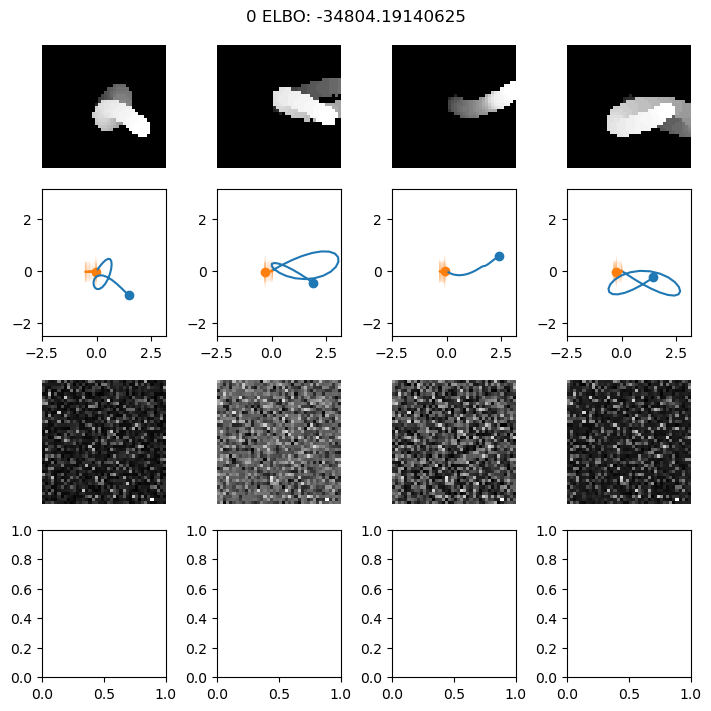

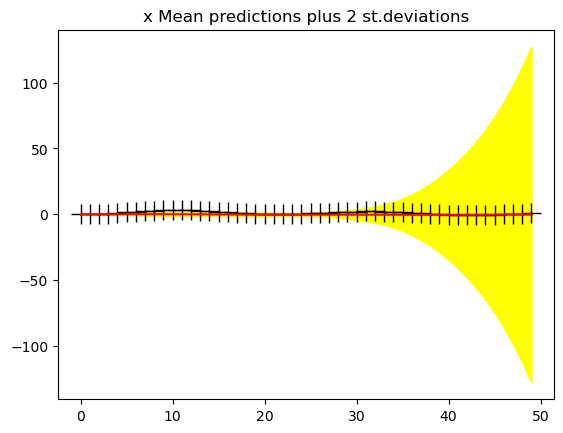

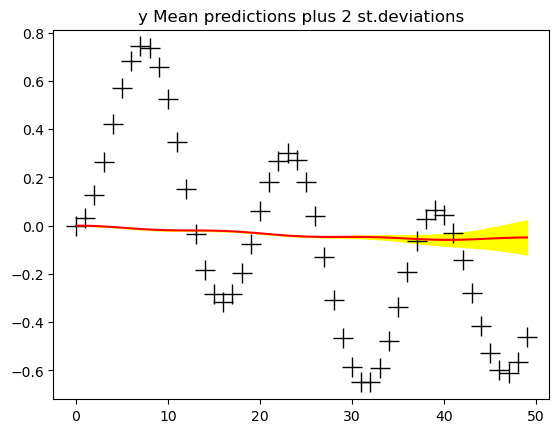


Test set: Avg. loss: 0.0004

Train Epoch: 50 	Loss: 5642.914062	 4713.879883	 929.034138
Train Epoch: 100 	Loss: 4991.567383	 4247.751953	 743.815327
Train Epoch: 150 	Loss: 4499.660645	 3825.866211	 673.794603
Train Epoch: 200 	Loss: 4072.699219	 3465.759766	 606.939411
Train Epoch: 250 	Loss: 3769.387207	 3215.356201	 554.031134
Train Epoch: 300 	Loss: 3597.485840	 3053.870850	 543.615103
Train Epoch: 350 	Loss: 3493.115967	 2930.887207	 562.228775
Train Epoch: 400 	Loss: 3378.627930	 2859.955078	 518.672848
Train Epoch: 450 	Loss: 3313.536621	 2786.264160	 527.272320
Train Epoch: 500 	Loss: 3186.333496	 2669.367920	 516.965580
Train Epoch: 550 	Loss: 3042.245361	 2484.388428	 557.856941
Train Epoch: 600 	Loss: 2996.642090	 2370.710693	 625.931406
Train Epoch: 650 	Loss: 2897.242188	 2298.885742	 598.356581
Train Epoch: 700 	Loss: 2861.139648	 2224.058838	 637.080669
Train Epoch: 750 	Loss: 2780.494629	 2139.802246	 640.692282
Train Epoch: 800 	Loss: 2709.952637	 2056.273438	 653.67

<Figure size 640x480 with 0 Axes>

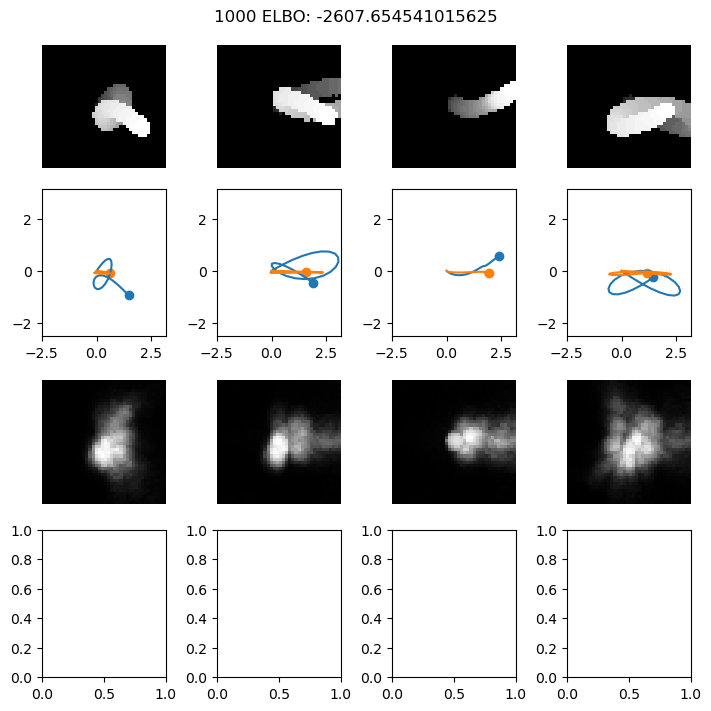

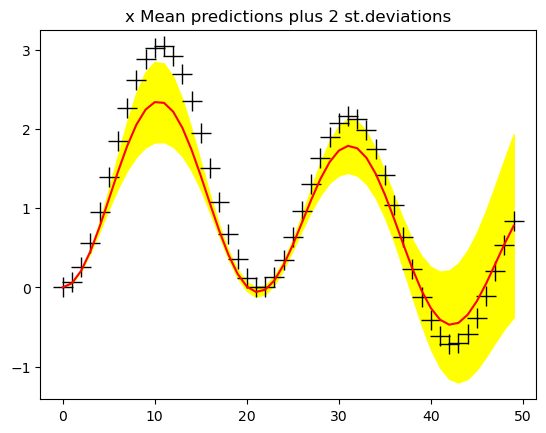

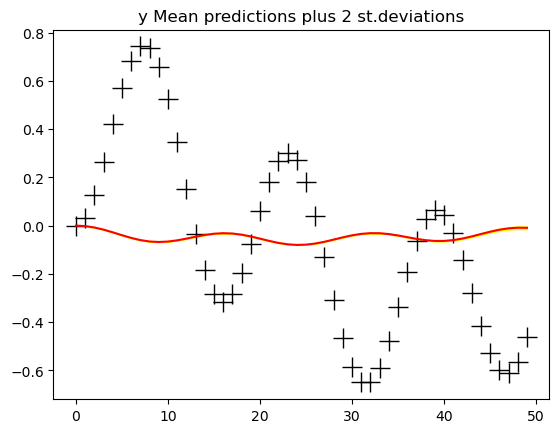


Test set: Avg. loss: 0.0001

Train Epoch: 1050 	Loss: 2580.359863	 1906.801514	 673.558235
Train Epoch: 1100 	Loss: 2598.068604	 1879.445679	 718.622971
Train Epoch: 1150 	Loss: 2546.302734	 1872.141235	 674.161577
Train Epoch: 1200 	Loss: 2525.942871	 1830.687378	 695.255566
Train Epoch: 1250 	Loss: 2512.177734	 1803.554321	 708.623314
Train Epoch: 1300 	Loss: 2500.078857	 1795.022217	 705.056572
Train Epoch: 1350 	Loss: 2479.044189	 1792.461670	 686.582518
Train Epoch: 1400 	Loss: 2481.363037	 1774.677979	 706.685114
Train Epoch: 1450 	Loss: 2473.154785	 1785.110596	 688.044071
Train Epoch: 1500 	Loss: 2436.080322	 1737.905029	 698.175335
Train Epoch: 1550 	Loss: 2431.015381	 1733.968384	 697.046947
Train Epoch: 1600 	Loss: 2439.344971	 1738.055298	 701.289606
Train Epoch: 1650 	Loss: 2428.202881	 1722.796875	 705.406046
Train Epoch: 1700 	Loss: 2432.169434	 1735.315674	 696.853781
Train Epoch: 1750 	Loss: 2414.027344	 1720.223145	 693.804121
Train Epoch: 1800 	Loss: 2397.404297	 16

<Figure size 640x480 with 0 Axes>

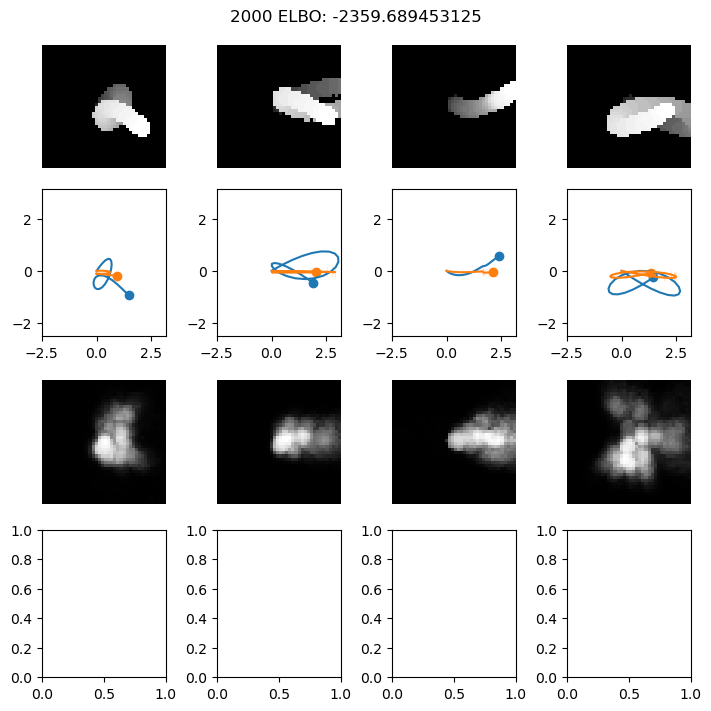

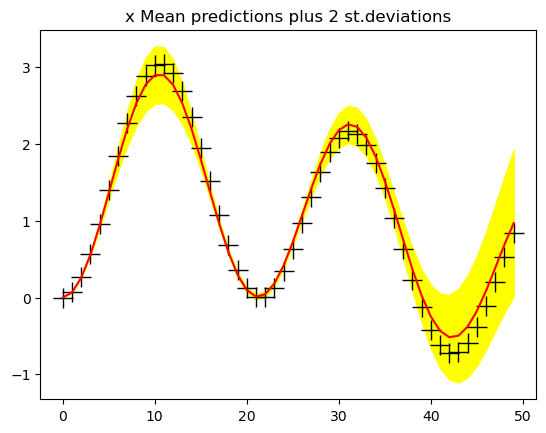

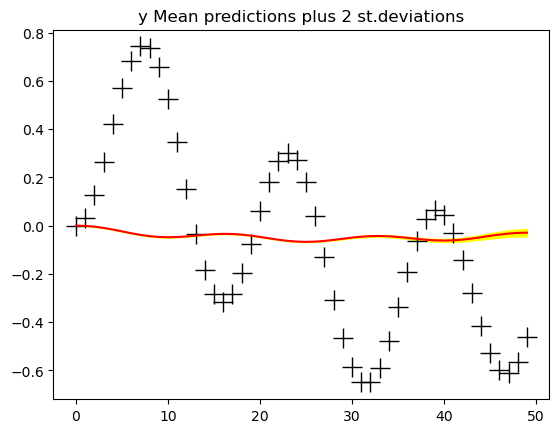


Test set: Avg. loss: 0.0001

Train Epoch: 2050 	Loss: 2332.797119	 1628.703125	 704.093933
Train Epoch: 2100 	Loss: 2333.541260	 1622.981934	 710.559368
Train Epoch: 2150 	Loss: 2321.897705	 1612.716553	 709.181166
Train Epoch: 2200 	Loss: 2316.646973	 1611.246460	 705.400372
Train Epoch: 2250 	Loss: 2296.530273	 1592.831055	 703.699207
Train Epoch: 2300 	Loss: 2288.095459	 1574.739746	 713.355780
Train Epoch: 2350 	Loss: 2274.336914	 1566.121704	 708.215332
Train Epoch: 2400 	Loss: 2250.235352	 1546.855591	 703.379774
Train Epoch: 2450 	Loss: 2238.552734	 1520.261353	 718.291521
Train Epoch: 2500 	Loss: 2215.415527	 1502.006348	 713.409042
Train Epoch: 2550 	Loss: 2205.636719	 1492.485840	 713.150978
Train Epoch: 2600 	Loss: 2194.864746	 1463.955200	 730.909538
Train Epoch: 2650 	Loss: 2182.493408	 1455.748901	 726.744509
Train Epoch: 2700 	Loss: 2172.071289	 1445.653442	 726.417923
Train Epoch: 2750 	Loss: 2170.304443	 1429.753906	 740.550518
Train Epoch: 2800 	Loss: 2160.856689	 14

<Figure size 640x480 with 0 Axes>

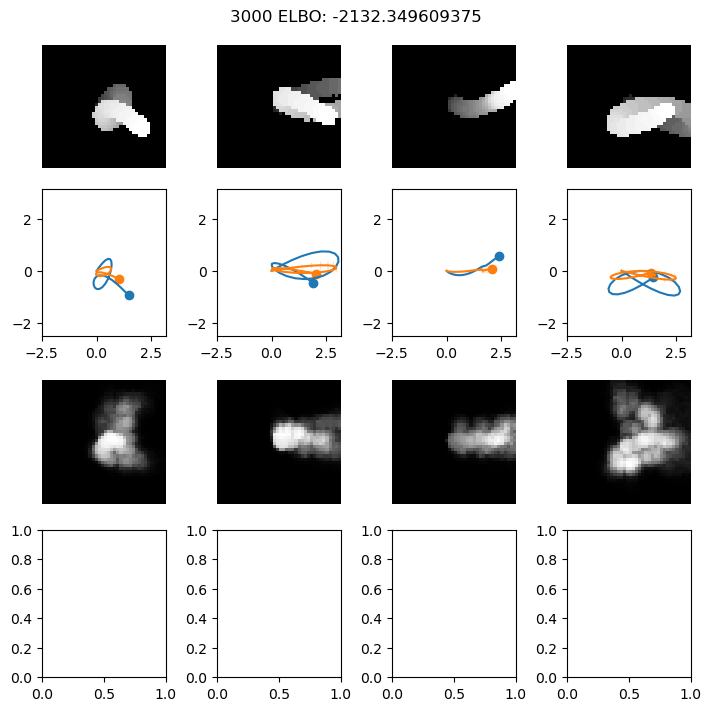

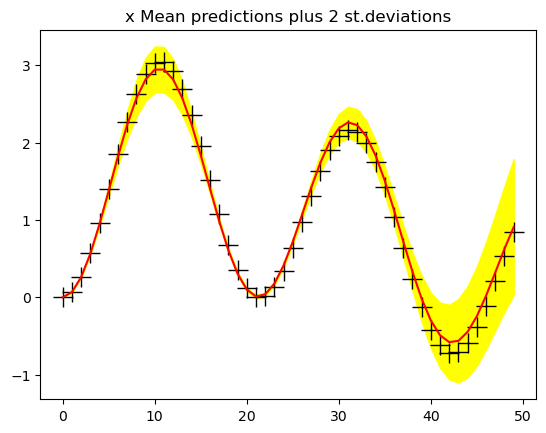

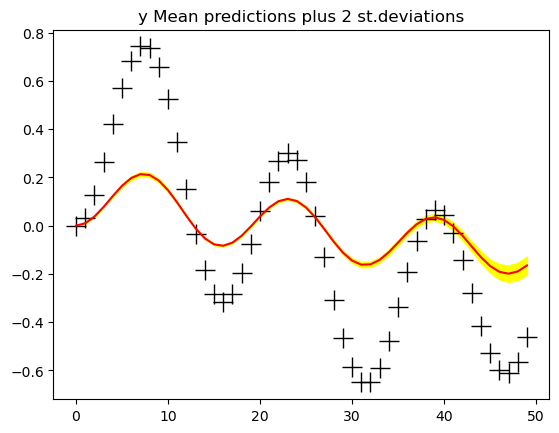


Test set: Avg. loss: 0.0001

Train Epoch: 3050 	Loss: 2136.737793	 1391.741821	 744.995928
Train Epoch: 3100 	Loss: 2144.075439	 1395.464722	 748.610735
Train Epoch: 3150 	Loss: 2144.207520	 1391.650513	 752.557087
Train Epoch: 3200 	Loss: 2138.341064	 1379.824585	 758.516550
Train Epoch: 3250 	Loss: 2128.114746	 1359.543579	 768.571186
Train Epoch: 3300 	Loss: 2114.849121	 1351.897827	 762.951374
Train Epoch: 3350 	Loss: 2119.239502	 1336.621094	 782.618475
Train Epoch: 3400 	Loss: 2123.807861	 1360.926880	 762.880993
Train Epoch: 3450 	Loss: 2119.842529	 1339.937866	 779.904747
Train Epoch: 3500 	Loss: 2124.867432	 1357.036255	 767.831135
Train Epoch: 3550 	Loss: 2098.426025	 1328.416992	 770.009041
Train Epoch: 3600 	Loss: 2108.297363	 1323.031860	 785.265398
Train Epoch: 3650 	Loss: 2112.982178	 1341.335938	 771.646261
Train Epoch: 3700 	Loss: 2099.753418	 1323.814941	 775.938559
Train Epoch: 3750 	Loss: 2104.839355	 1312.109253	 792.730141
Train Epoch: 3800 	Loss: 2102.292725	 12

<Figure size 640x480 with 0 Axes>

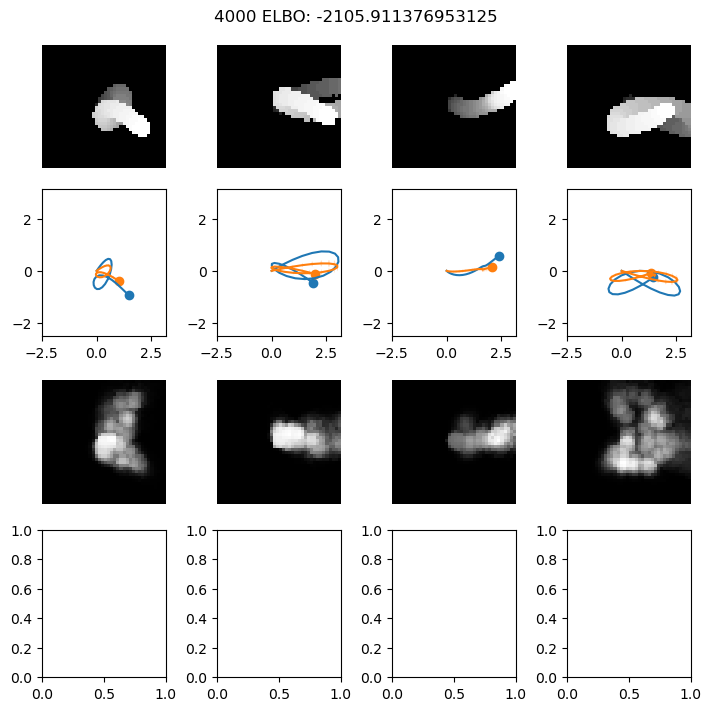

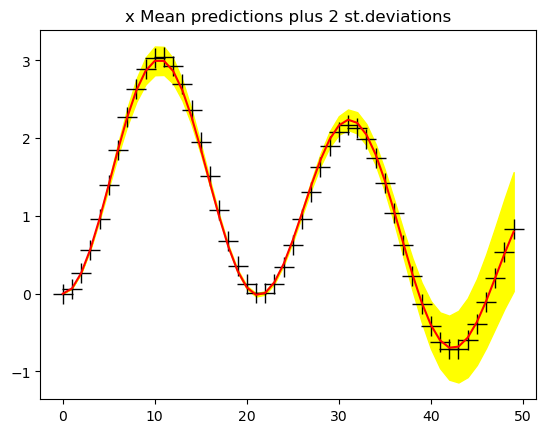

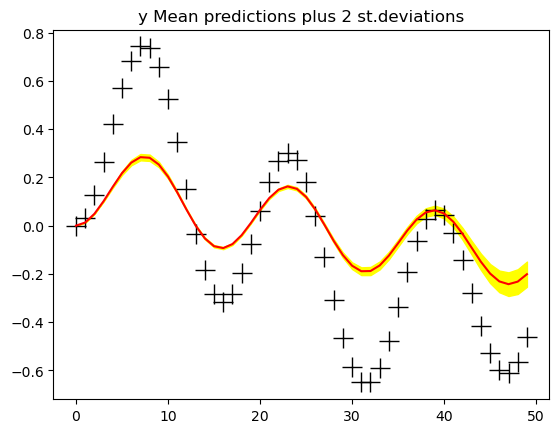


Test set: Avg. loss: 0.0001

Train Epoch: 4050 	Loss: 2092.952637	 1304.176758	 788.776016
Train Epoch: 4100 	Loss: 2088.189453	 1294.590332	 793.599176
Train Epoch: 4150 	Loss: 2080.866211	 1280.122681	 800.743484
Train Epoch: 4200 	Loss: 2078.567871	 1265.834351	 812.733555
Train Epoch: 4250 	Loss: 2081.809570	 1278.850342	 802.959347
Train Epoch: 4300 	Loss: 2073.281982	 1267.723145	 805.558872
Train Epoch: 4350 	Loss: 2074.913818	 1258.740479	 816.173363
Train Epoch: 4400 	Loss: 2065.980469	 1251.504517	 814.475918
Train Epoch: 4450 	Loss: 2060.071533	 1254.490845	 805.580616
Train Epoch: 4500 	Loss: 2069.866455	 1240.926758	 828.939724
Train Epoch: 4550 	Loss: 2067.137451	 1246.720825	 820.416546
Train Epoch: 4600 	Loss: 2052.708008	 1233.292480	 819.415569
Train Epoch: 4650 	Loss: 2062.059570	 1235.480591	 826.579094
Train Epoch: 4700 	Loss: 2069.599121	 1237.921631	 831.677341
Train Epoch: 4750 	Loss: 2052.789307	 1238.638184	 814.151192
Train Epoch: 4800 	Loss: 2048.178711	 12

<Figure size 640x480 with 0 Axes>

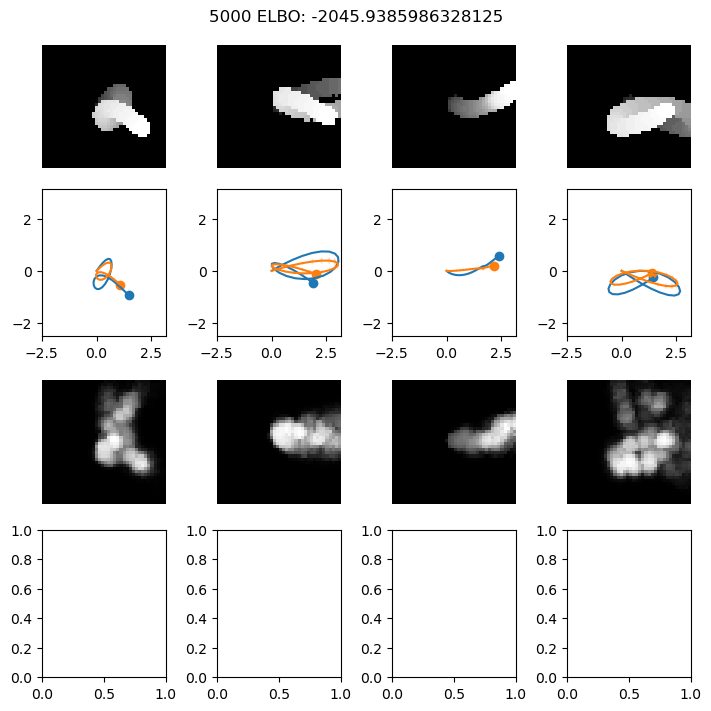

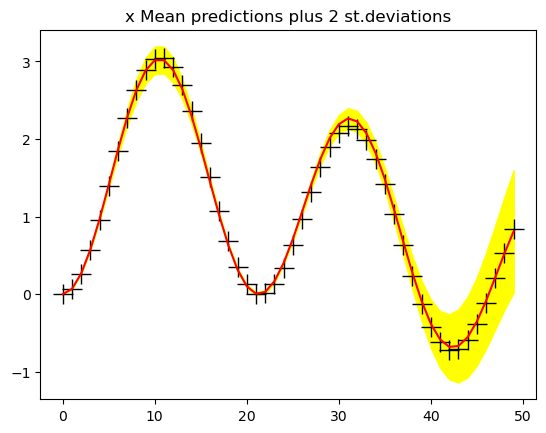

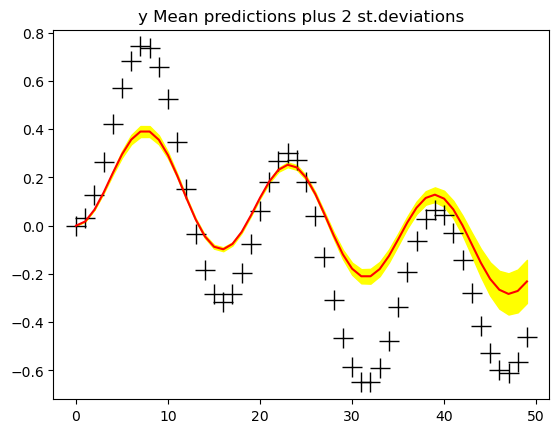


Test set: Avg. loss: 0.0001

Train Epoch: 5050 	Loss: 2048.411865	 1199.260010	 849.151802
Train Epoch: 5100 	Loss: 2033.545044	 1187.877197	 845.667839
Train Epoch: 5150 	Loss: 2038.016724	 1184.205200	 853.811550
Train Epoch: 5200 	Loss: 2045.548584	 1192.541504	 853.007030
Train Epoch: 5250 	Loss: 2041.948975	 1185.647583	 856.301308
Train Epoch: 5300 	Loss: 2046.523315	 1185.212769	 861.310577
Train Epoch: 5350 	Loss: 2047.454712	 1199.255371	 848.199368
Train Epoch: 5400 	Loss: 2017.126221	 1160.670532	 856.455612
Train Epoch: 5450 	Loss: 2018.730103	 1154.432617	 864.297485
Train Epoch: 5500 	Loss: 2019.054443	 1163.888306	 855.166054
Train Epoch: 5550 	Loss: 2026.976807	 1158.462158	 868.514729
Train Epoch: 5600 	Loss: 2021.293213	 1156.618042	 864.675236
Train Epoch: 5650 	Loss: 2021.051636	 1144.663208	 876.388454
Train Epoch: 5700 	Loss: 1996.763428	 1111.394775	 885.368729
Train Epoch: 5750 	Loss: 2023.581055	 1141.255127	 882.325840
Train Epoch: 5800 	Loss: 2013.879639	 11

<Figure size 640x480 with 0 Axes>

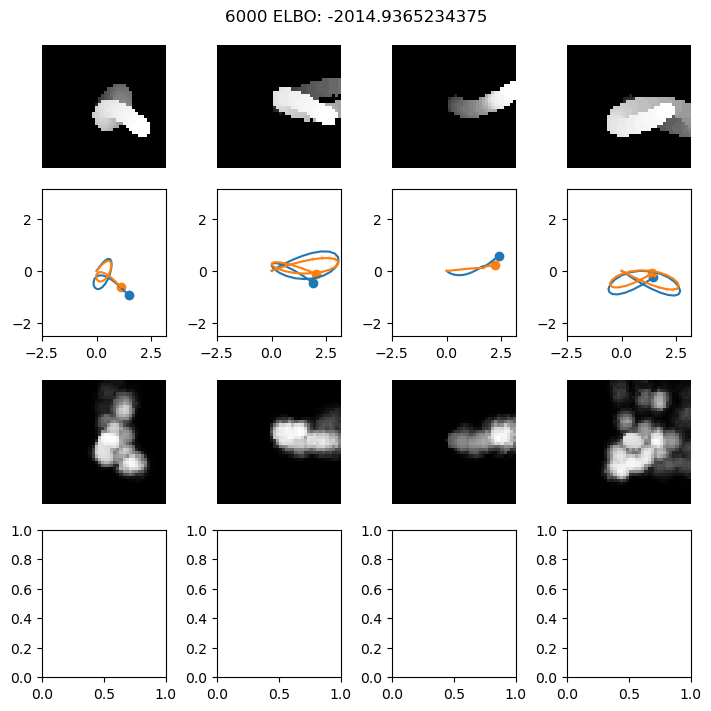

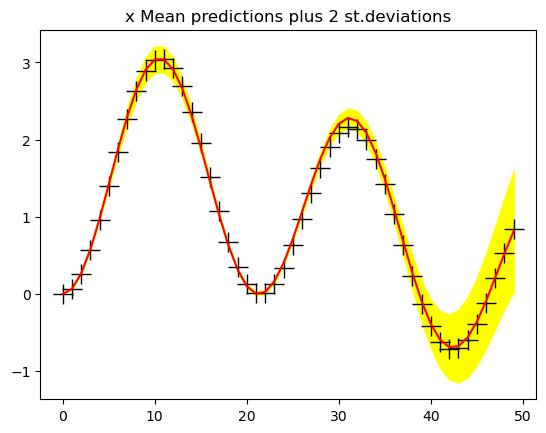

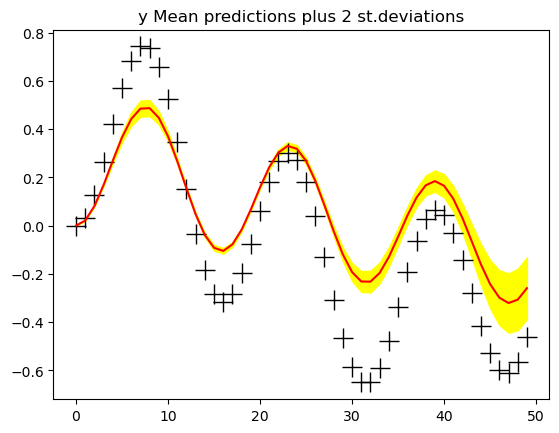


Test set: Avg. loss: 0.0001

Train Epoch: 6050 	Loss: 2008.521606	 1122.162231	 886.359406
Train Epoch: 6100 	Loss: 1993.779297	 1110.723877	 883.055496
Train Epoch: 6150 	Loss: 2007.955322	 1131.163696	 876.791668
Train Epoch: 6200 	Loss: 2006.634277	 1112.084106	 894.550228
Train Epoch: 6250 	Loss: 2012.759277	 1123.742432	 889.016819
Train Epoch: 6300 	Loss: 2001.759277	 1099.809570	 901.949692
Train Epoch: 6350 	Loss: 2008.653564	 1105.877930	 902.775669
Train Epoch: 6400 	Loss: 1997.324463	 1095.785278	 901.539230
Train Epoch: 6450 	Loss: 2003.568848	 1084.689209	 918.879700
Train Epoch: 6500 	Loss: 2003.023315	 1089.457520	 913.565826
Train Epoch: 6550 	Loss: 2003.301880	 1092.844727	 910.457134
Train Epoch: 6600 	Loss: 2002.977539	 1093.865967	 909.111595
Train Epoch: 6650 	Loss: 1995.301758	 1085.270996	 910.030842
Train Epoch: 6700 	Loss: 1990.955322	 1078.089355	 912.865925
Train Epoch: 6750 	Loss: 1996.624023	 1096.461914	 900.162125
Train Epoch: 6800 	Loss: 1991.001465	 10

<Figure size 640x480 with 0 Axes>

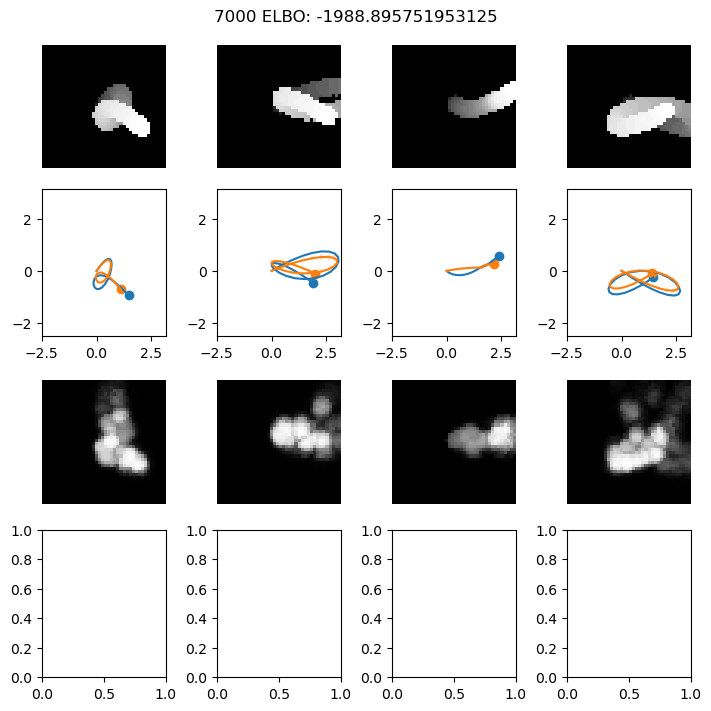

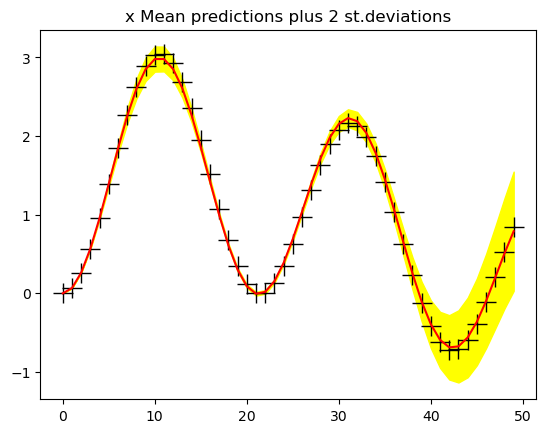

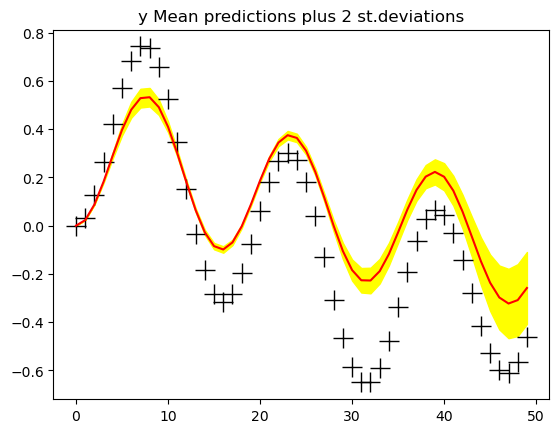


Test set: Avg. loss: 0.0001

Train Epoch: 7050 	Loss: 1997.016235	 1082.925049	 914.091206
Train Epoch: 7100 	Loss: 1992.687988	 1058.484253	 934.203720
Train Epoch: 7150 	Loss: 1985.271851	 1064.045044	 921.226788
Train Epoch: 7200 	Loss: 1982.561768	 1045.756226	 936.805534
Train Epoch: 7250 	Loss: 1993.385010	 1071.978271	 921.406746
Train Epoch: 7300 	Loss: 1976.822266	 1044.945435	 931.876850
Train Epoch: 7350 	Loss: 1968.143555	 1051.499390	 916.644096
Train Epoch: 7400 	Loss: 1982.358032	 1045.733154	 936.624908
Train Epoch: 7450 	Loss: 1994.958252	 1071.218140	 923.740101
Train Epoch: 7500 	Loss: 1974.466797	 1025.151367	 949.315357
Train Epoch: 7550 	Loss: 1977.375977	 1047.622070	 929.753876
Train Epoch: 7600 	Loss: 1981.985840	 1051.456909	 930.528927
Train Epoch: 7650 	Loss: 1992.318359	 1050.828613	 941.489697
Train Epoch: 7700 	Loss: 1983.567383	 1049.311035	 934.256363
Train Epoch: 7750 	Loss: 1964.207764	 1020.456787	 943.750954
Train Epoch: 7800 	Loss: 1972.284668	 10

<Figure size 640x480 with 0 Axes>

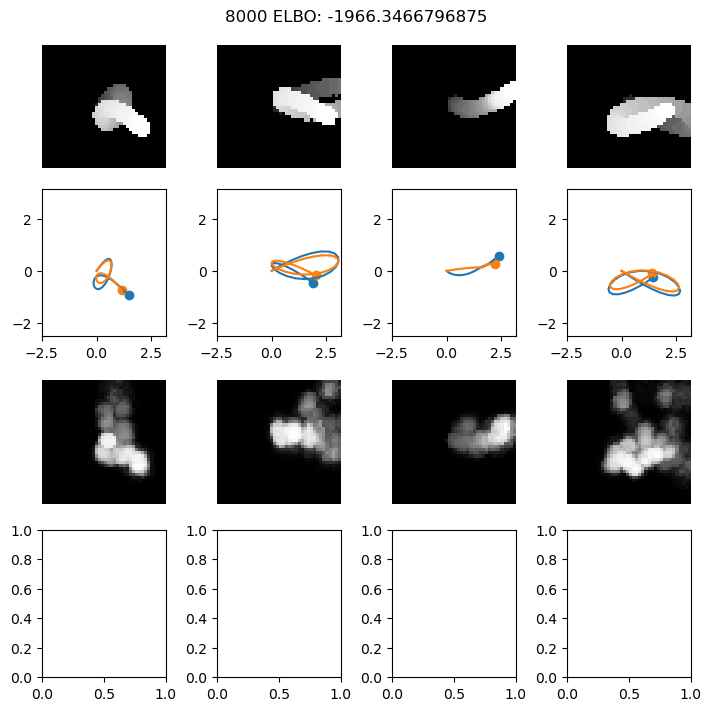

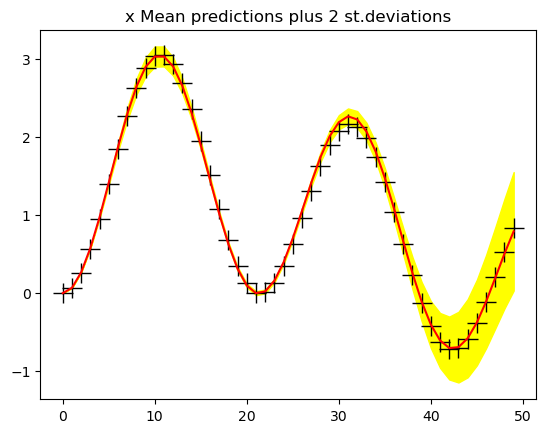

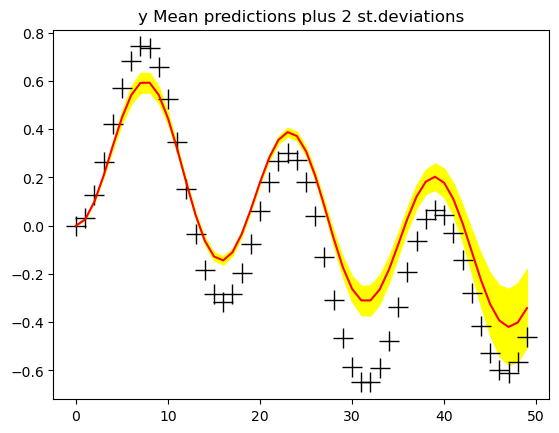


Test set: Avg. loss: 0.0001

Train Epoch: 8050 	Loss: 1979.807617	 1027.151001	 952.656651
Train Epoch: 8100 	Loss: 1983.854126	 1022.353455	 961.500645
Train Epoch: 8150 	Loss: 1968.286377	 1002.218689	 966.067600
Train Epoch: 8200 	Loss: 1961.053223	 1010.255310	 950.797844
Train Epoch: 8250 	Loss: 1975.709717	 1018.757568	 956.952190
Train Epoch: 8300 	Loss: 1960.908691	 1013.385559	 947.523212
Train Epoch: 8350 	Loss: 1964.406738	 1005.368774	 959.037876
Train Epoch: 8400 	Loss: 1965.691895	 992.112732	 973.579121
Train Epoch: 8450 	Loss: 1960.672363	 1003.505676	 957.166672
Train Epoch: 8500 	Loss: 1965.239014	 1014.108337	 951.130676
Train Epoch: 8550 	Loss: 1961.435547	 1013.259827	 948.175716
Train Epoch: 8600 	Loss: 1976.597290	 1022.892578	 953.704739
Train Epoch: 8650 	Loss: 1970.798584	 1019.727783	 951.070881
Train Epoch: 8700 	Loss: 1973.379639	 1015.375854	 958.003807
Train Epoch: 8750 	Loss: 1978.762451	 1019.135498	 959.626961
Train Epoch: 8800 	Loss: 1964.988770	 100

<Figure size 640x480 with 0 Axes>

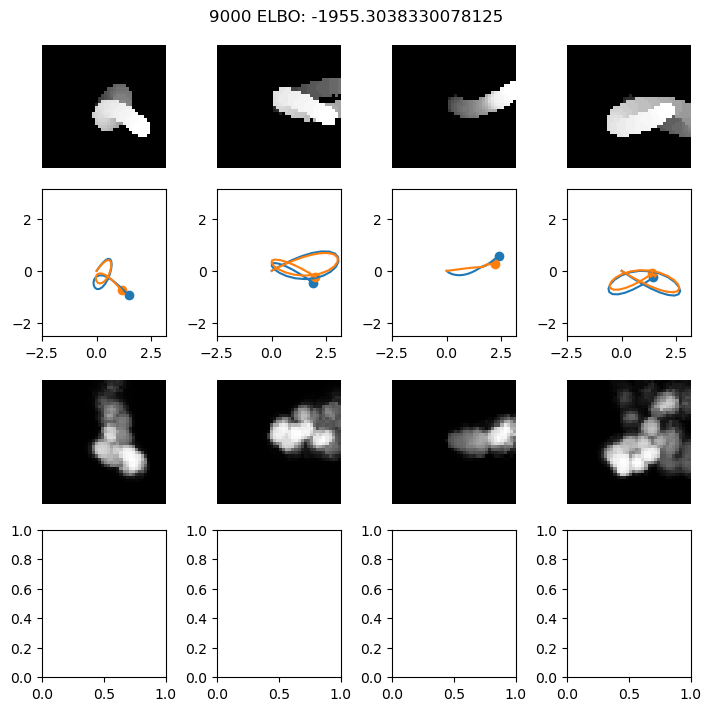

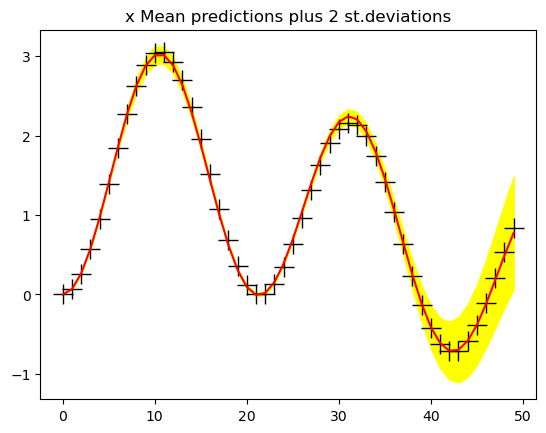

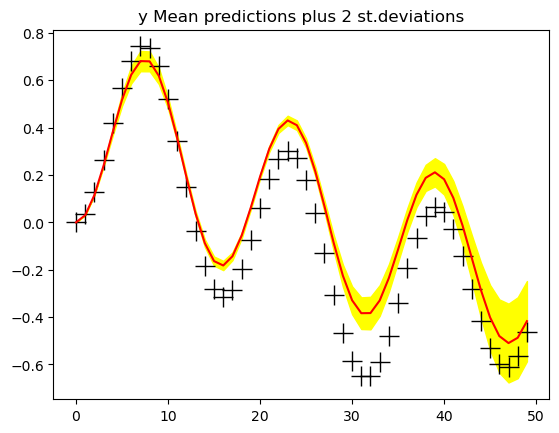


Test set: Avg. loss: 0.0001

Train Epoch: 9050 	Loss: 1963.241211	 983.683838	 979.557419
Train Epoch: 9100 	Loss: 1960.196045	 997.474976	 962.721157
Train Epoch: 9150 	Loss: 1968.521973	 988.800781	 979.721165
Train Epoch: 9200 	Loss: 1956.893311	 990.233276	 966.660023
Train Epoch: 9250 	Loss: 1965.637573	 1005.214600	 960.422993
Train Epoch: 9300 	Loss: 1959.453857	 989.362183	 970.091629
Train Epoch: 9350 	Loss: 1968.535522	 1000.113281	 968.422222
Train Epoch: 9400 	Loss: 1961.160889	 1001.858887	 959.302044
Train Epoch: 9450 	Loss: 1960.907715	 990.495911	 970.411873
Train Epoch: 9500 	Loss: 1959.638306	 990.013123	 969.625187
Train Epoch: 9550 	Loss: 1957.721802	 963.597839	 994.123936
Train Epoch: 9600 	Loss: 1970.973877	 1002.072205	 968.901730
Train Epoch: 9650 	Loss: 1967.782349	 994.865967	 972.916412
Train Epoch: 9700 	Loss: 1953.819336	 978.267822	 975.551510
Train Epoch: 9750 	Loss: 1972.463135	 1009.472046	 962.991047
Train Epoch: 9800 	Loss: 1958.380737	 996.784607	 

<Figure size 640x480 with 0 Axes>

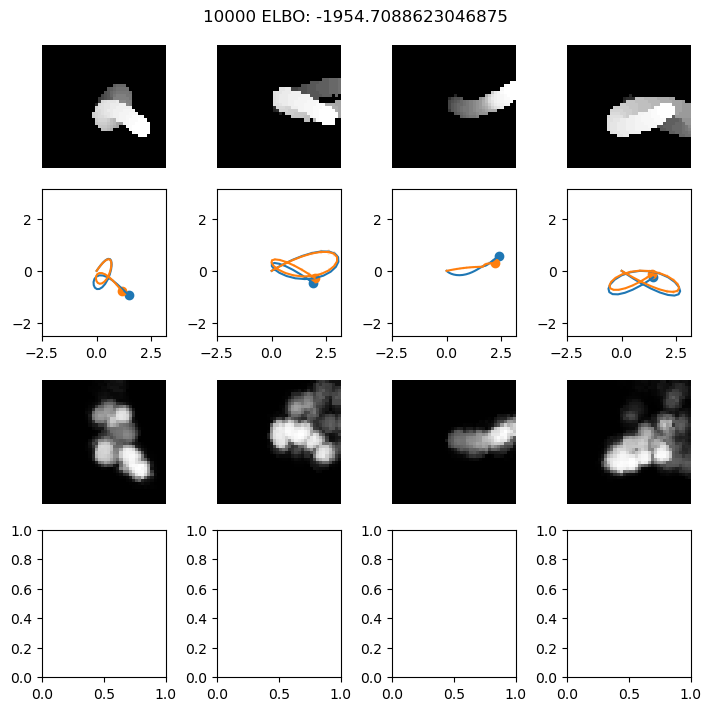

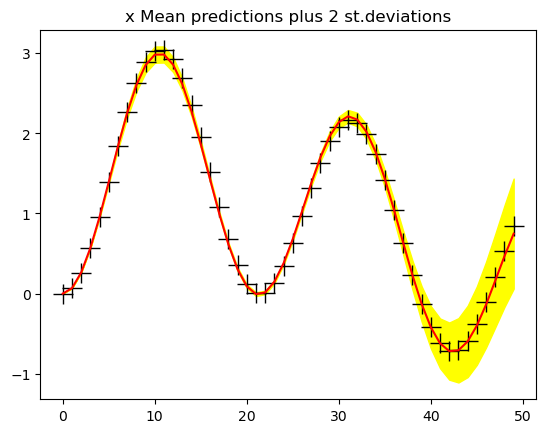

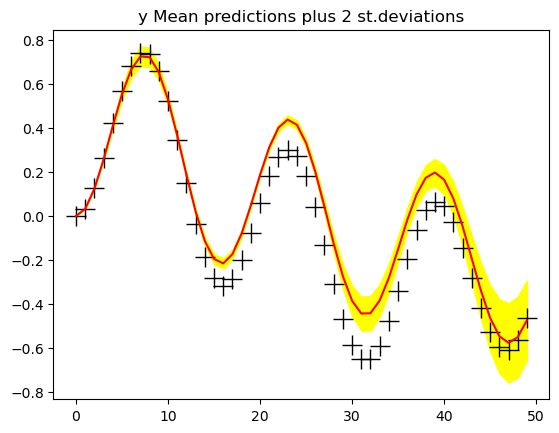


Test set: Avg. loss: 0.0001

Train Epoch: 10050 	Loss: 1957.289307	 971.224121	 986.065102
Train Epoch: 10100 	Loss: 1957.878174	 972.990051	 984.888172
Train Epoch: 10150 	Loss: 1934.584473	 954.786926	 979.797459
Train Epoch: 10200 	Loss: 1963.215088	 997.370789	 965.844345
Train Epoch: 10250 	Loss: 1943.341797	 971.083984	 972.257805
Train Epoch: 10300 	Loss: 1961.298462	 978.563965	 982.734489
Train Epoch: 10350 	Loss: 1933.091797	 950.867004	 982.224751
Train Epoch: 10400 	Loss: 1951.726318	 971.080994	 980.645275
Train Epoch: 10450 	Loss: 1960.288330	 982.978577	 977.309799
Train Epoch: 10500 	Loss: 1947.700684	 966.811279	 980.889320
Train Epoch: 10550 	Loss: 1957.725098	 970.063599	 987.661457
Train Epoch: 10600 	Loss: 1945.754028	 955.336670	 990.417385
Train Epoch: 10650 	Loss: 1933.352539	 954.457520	 978.894997
Train Epoch: 10700 	Loss: 1955.292725	 964.427124	 990.865612
Train Epoch: 10750 	Loss: 1950.544067	 953.184814	 997.359276
Train Epoch: 10800 	Loss: 1946.985229	 9

<Figure size 640x480 with 0 Axes>

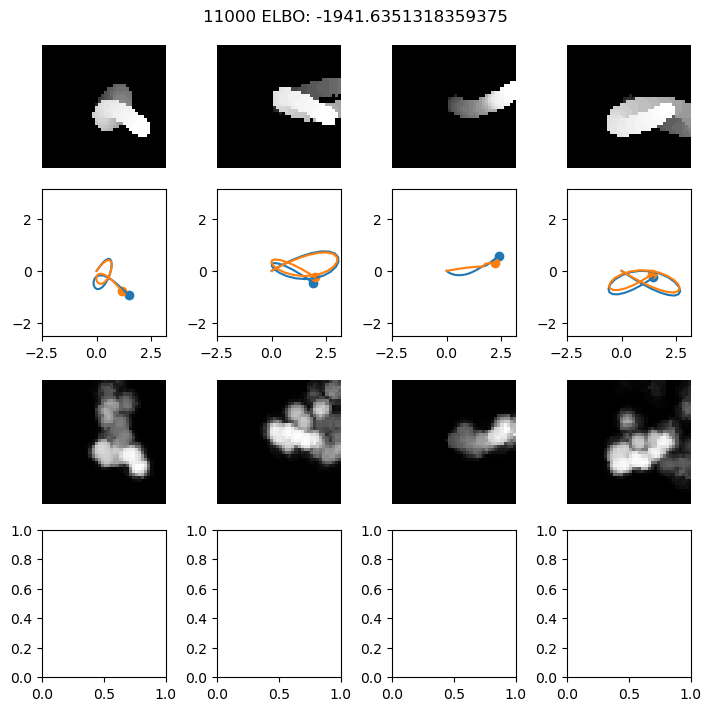

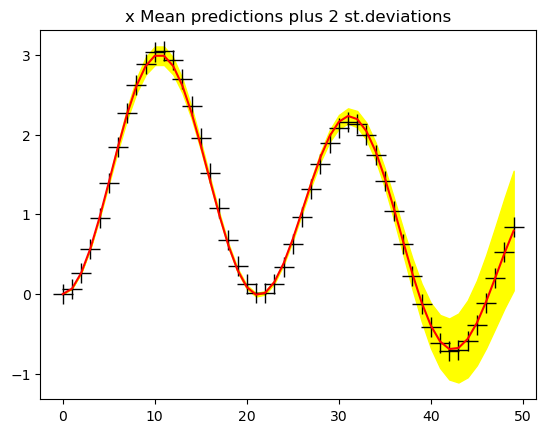

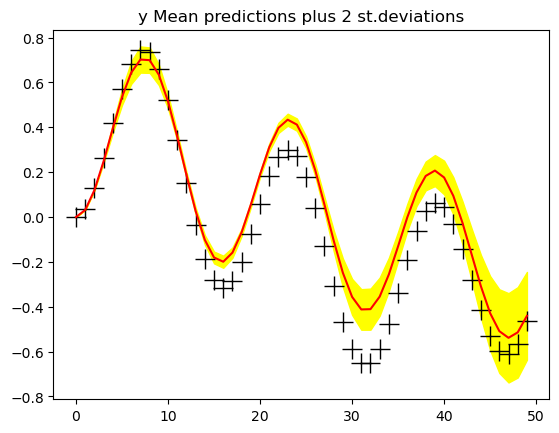


Test set: Avg. loss: 0.0001

Train Epoch: 11050 	Loss: 1946.908936	 965.646118	 981.262779
Train Epoch: 11100 	Loss: 1932.959473	 936.314392	 996.645164
Train Epoch: 11150 	Loss: 1949.208984	 940.300598	 1008.908463
Train Epoch: 11200 	Loss: 1945.618896	 970.556702	 975.062180
Train Epoch: 11250 	Loss: 1953.176025	 951.627502	 1001.548481
Train Epoch: 11300 	Loss: 1961.567871	 965.688293	 995.879555
Train Epoch: 11350 	Loss: 1950.073730	 959.617737	 990.455914
Train Epoch: 11400 	Loss: 1946.378662	 964.169922	 982.208729
Train Epoch: 11450 	Loss: 1937.912598	 943.168274	 994.744301
Train Epoch: 11500 	Loss: 1946.949951	 977.832581	 969.117451
Train Epoch: 11550 	Loss: 1946.583008	 944.065613	 1002.517414
Train Epoch: 11600 	Loss: 1950.102295	 944.188293	 1005.914021
Train Epoch: 11650 	Loss: 1928.551880	 935.973450	 992.578411
Train Epoch: 11700 	Loss: 1962.658813	 970.421509	 992.237282
Train Epoch: 11750 	Loss: 1933.682373	 940.367493	 993.314838
Train Epoch: 11800 	Loss: 1936.05468

<Figure size 640x480 with 0 Axes>

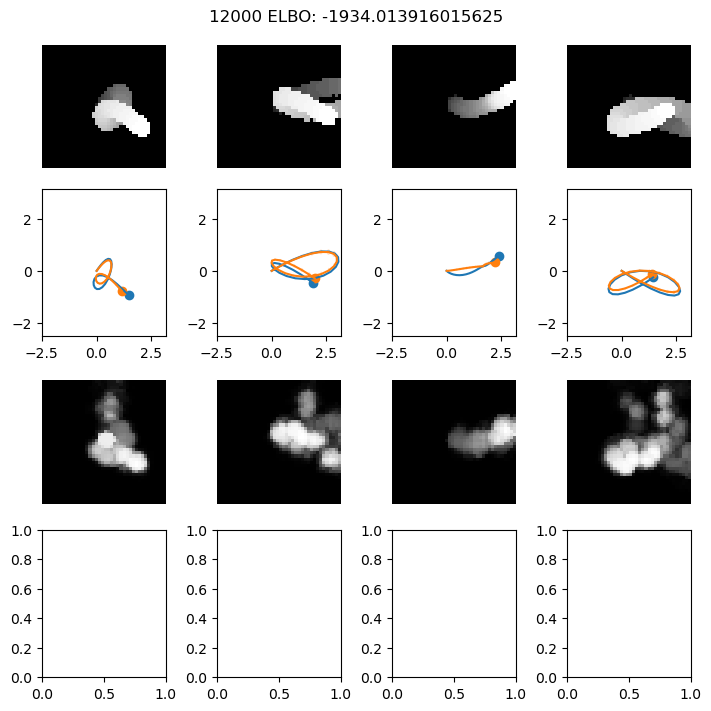

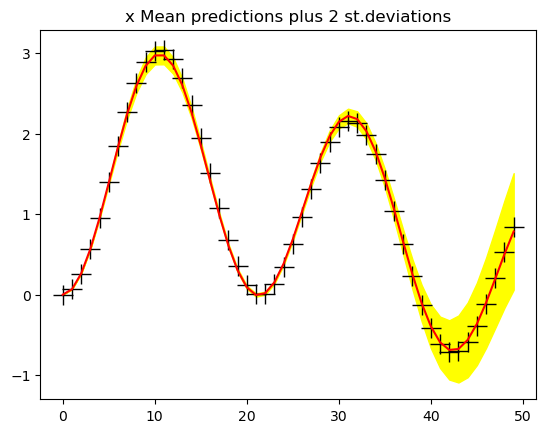

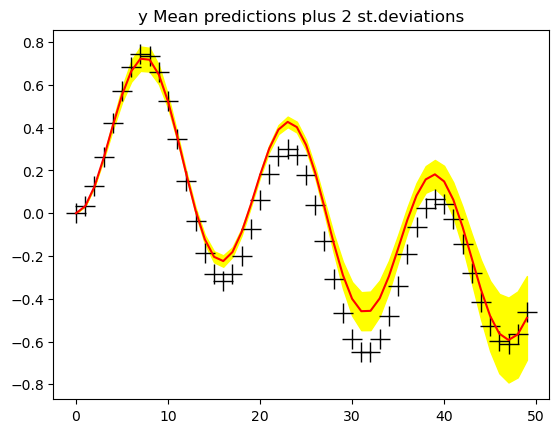


Test set: Avg. loss: 0.0001

Train Epoch: 12050 	Loss: 1929.854248	 936.397278	 993.457031
Train Epoch: 12100 	Loss: 1931.909912	 926.660767	 1005.249119
Train Epoch: 12150 	Loss: 1938.393799	 934.484131	 1003.909683
Train Epoch: 12200 	Loss: 1936.585327	 946.695496	 989.889812
Train Epoch: 12250 	Loss: 1951.042969	 959.097168	 991.945839
Train Epoch: 12300 	Loss: 1942.873901	 944.720764	 998.153114
Train Epoch: 12350 	Loss: 1954.822266	 959.975098	 994.847107
Train Epoch: 12400 	Loss: 1933.231201	 938.219055	 995.012093
Train Epoch: 12450 	Loss: 1946.779663	 939.919678	 1006.859970
Train Epoch: 12500 	Loss: 1939.912476	 938.313721	 1001.598740
Train Epoch: 12550 	Loss: 1929.980347	 943.342590	 986.637783
Train Epoch: 12600 	Loss: 1944.496582	 955.445557	 989.050961
Train Epoch: 12650 	Loss: 1947.095093	 939.142517	 1007.952595
Train Epoch: 12700 	Loss: 1938.025391	 931.429749	 1006.595612
Train Epoch: 12750 	Loss: 1930.937622	 937.747437	 993.190193
Train Epoch: 12800 	Loss: 1938.100

<Figure size 640x480 with 0 Axes>

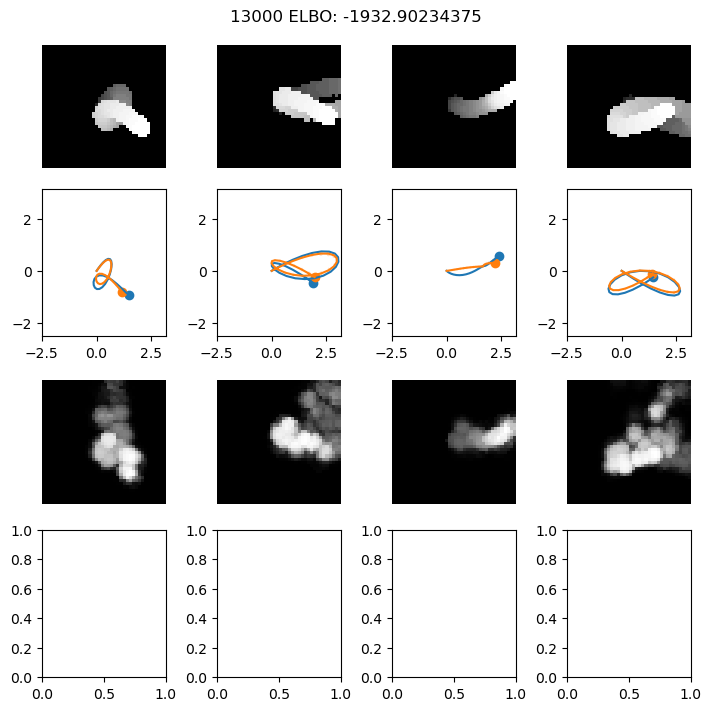

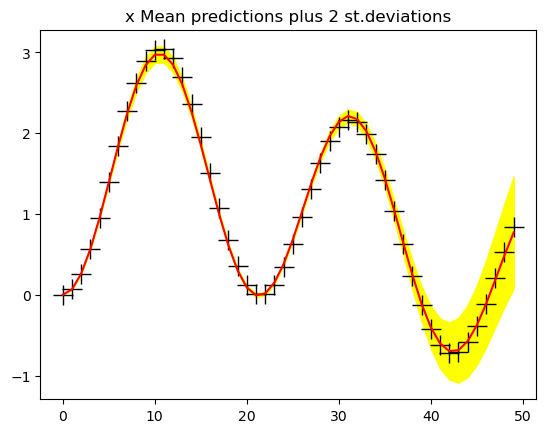

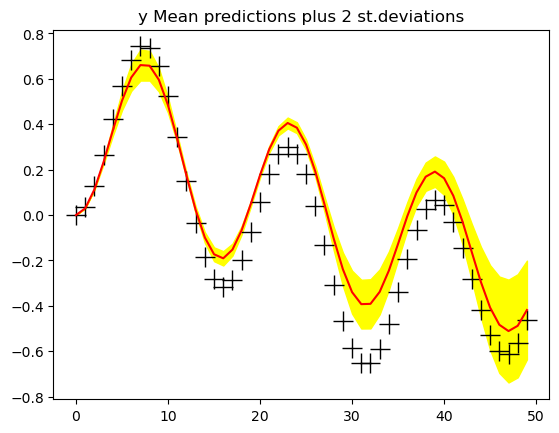


Test set: Avg. loss: 0.0001

Train Epoch: 13050 	Loss: 1948.323486	 961.581665	 986.741734
Train Epoch: 13100 	Loss: 1939.912598	 939.245544	 1000.667000
Train Epoch: 13150 	Loss: 1940.683472	 935.783508	 1004.899979
Train Epoch: 13200 	Loss: 1946.968506	 952.957886	 994.010544
Train Epoch: 13250 	Loss: 1934.542114	 940.378113	 994.163990
Train Epoch: 13300 	Loss: 1942.873291	 955.731567	 987.141800
Train Epoch: 13350 	Loss: 1943.282959	 933.780457	 1009.502411
Train Epoch: 13400 	Loss: 1940.627441	 942.231873	 998.395538
Train Epoch: 13450 	Loss: 1933.655884	 937.863281	 995.792580
Train Epoch: 13500 	Loss: 1938.194336	 922.725403	 1015.468884
Train Epoch: 13550 	Loss: 1931.003662	 925.595337	 1005.408287
Train Epoch: 13600 	Loss: 1938.853760	 929.914001	 1008.939743
Train Epoch: 13650 	Loss: 1926.945557	 926.730103	 1000.215435
Train Epoch: 13700 	Loss: 1926.339233	 908.548462	 1017.790794
Train Epoch: 13750 	Loss: 1928.916260	 923.135803	 1005.780411
Train Epoch: 13800 	Loss: 1938.

<Figure size 640x480 with 0 Axes>

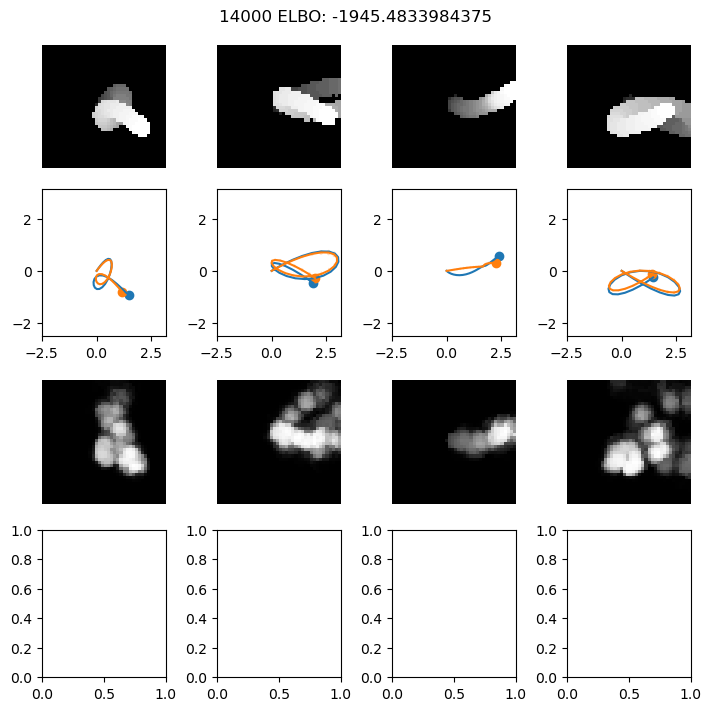

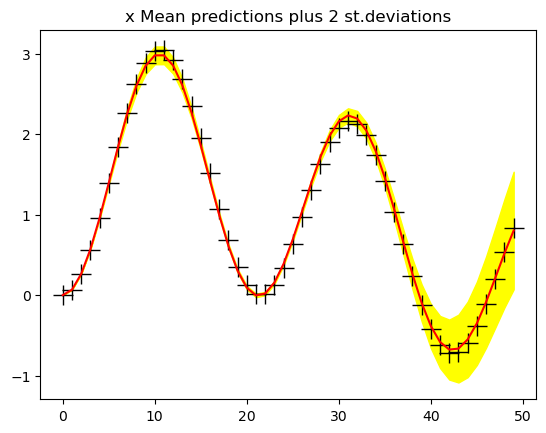

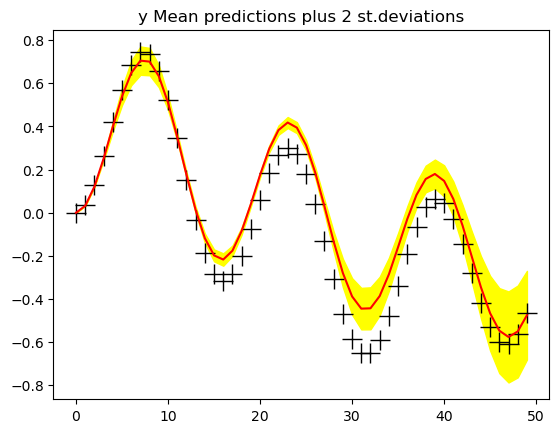


Test set: Avg. loss: 0.0001

Train Epoch: 14050 	Loss: 1939.340088	 921.337952	 1018.002224
Train Epoch: 14100 	Loss: 1942.929443	 934.326904	 1008.602619
Train Epoch: 14150 	Loss: 1935.727417	 933.053223	 1002.674198
Train Epoch: 14200 	Loss: 1935.231445	 930.576172	 1004.655361
Train Epoch: 14250 	Loss: 1925.014160	 922.044556	 1002.969646
Train Epoch: 14300 	Loss: 1931.465820	 921.743652	 1009.722233
Train Epoch: 14350 	Loss: 1921.494141	 920.054504	 1001.439667
Train Epoch: 14400 	Loss: 1936.643433	 933.582825	 1003.060627
Train Epoch: 14450 	Loss: 1932.918701	 917.619324	 1015.299416
Train Epoch: 14500 	Loss: 1937.136353	 933.845154	 1003.291225
Train Epoch: 14550 	Loss: 1946.693115	 940.610107	 1006.083012
Train Epoch: 14600 	Loss: 1916.605957	 903.836243	 1012.769794
Train Epoch: 14650 	Loss: 1934.755859	 930.974304	 1003.781509
Train Epoch: 14700 	Loss: 1932.779053	 926.929443	 1005.849648
Train Epoch: 14750 	Loss: 1938.596069	 922.261414	 1016.334629
Train Epoch: 14800 	Loss:

<Figure size 640x480 with 0 Axes>

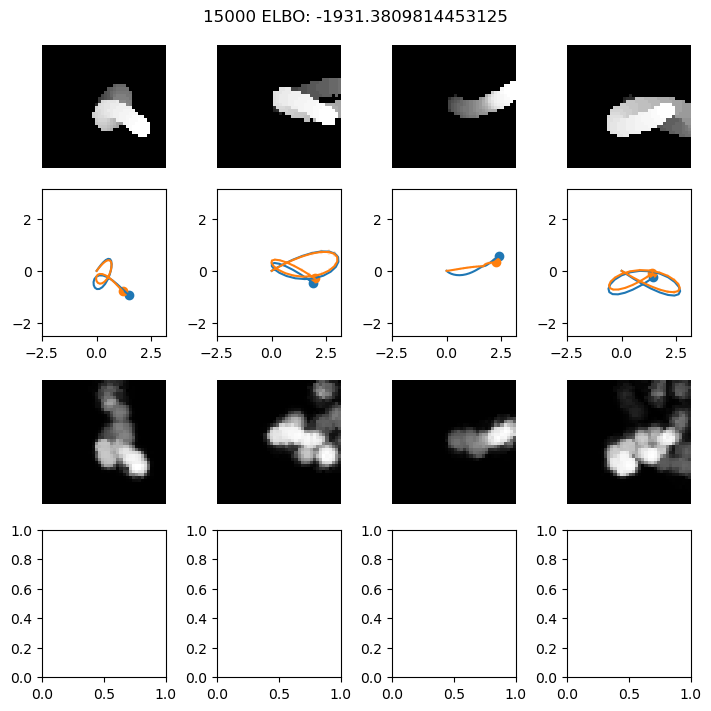

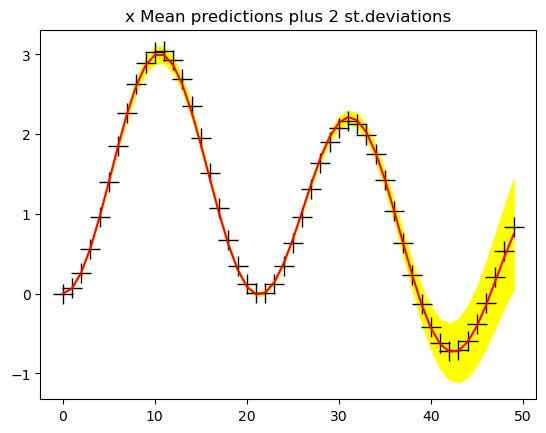

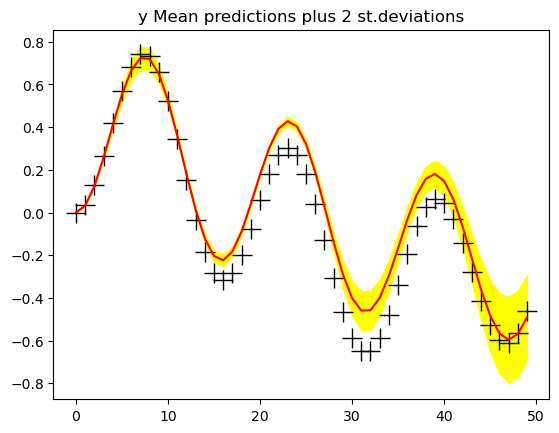


Test set: Avg. loss: 0.0001

Train Epoch: 15050 	Loss: 1929.492676	 907.952820	 1021.539879
Train Epoch: 15100 	Loss: 1948.186035	 940.298889	 1007.887077
Train Epoch: 15150 	Loss: 1939.994019	 923.213074	 1016.780949
Train Epoch: 15200 	Loss: 1931.314331	 934.796692	 996.517658
Train Epoch: 15250 	Loss: 1924.407227	 919.335754	 1005.071545
Train Epoch: 15300 	Loss: 1937.308105	 913.375610	 1023.932457
Train Epoch: 15350 	Loss: 1942.470459	 929.394836	 1013.075542
Train Epoch: 15400 	Loss: 1940.452759	 922.595703	 1017.857075
Train Epoch: 15450 	Loss: 1932.192139	 917.908752	 1014.283466
Train Epoch: 15500 	Loss: 1951.906250	 925.935181	 1025.971031
Train Epoch: 15550 	Loss: 1938.414551	 930.669556	 1007.744980
Train Epoch: 15600 	Loss: 1926.685303	 912.768677	 1013.916588
Train Epoch: 15650 	Loss: 1925.472900	 907.062805	 1018.410015
Train Epoch: 15700 	Loss: 1932.412354	 923.558899	 1008.853436
Train Epoch: 15750 	Loss: 1923.545044	 907.926147	 1015.618896
Train Epoch: 15800 	Loss: 

<Figure size 640x480 with 0 Axes>

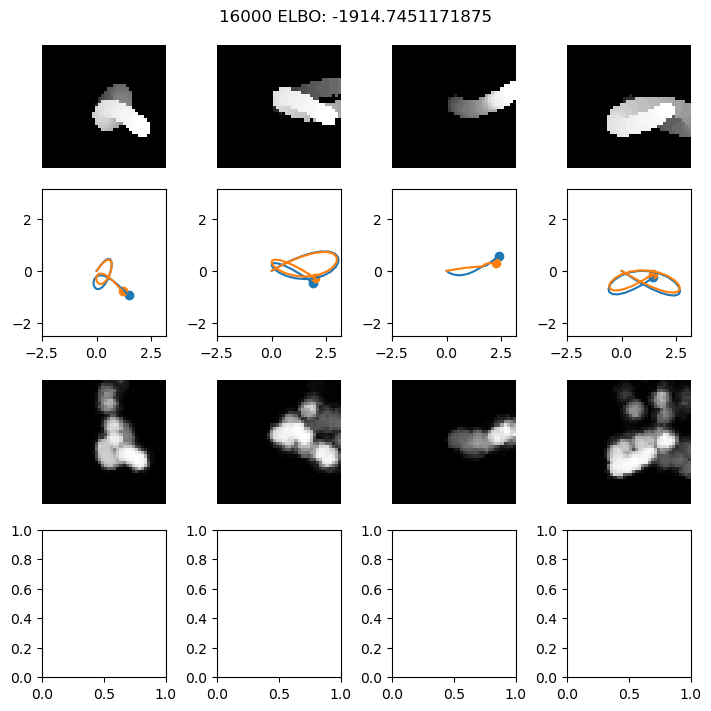

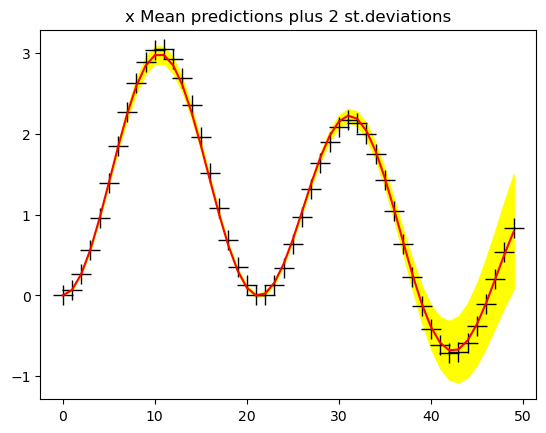

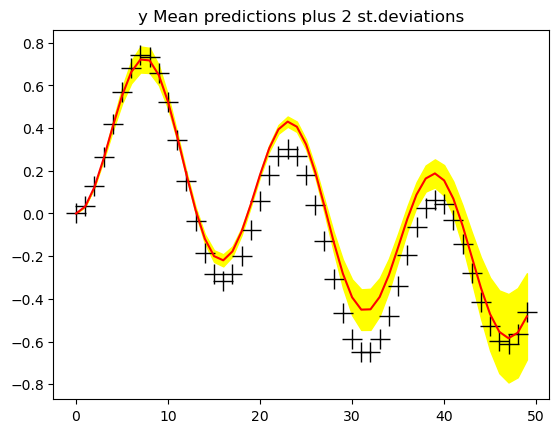


Test set: Avg. loss: 0.0001

Train Epoch: 16050 	Loss: 1930.001221	 917.034668	 1012.966633
Train Epoch: 16100 	Loss: 1938.816650	 925.931152	 1012.885475
Train Epoch: 16150 	Loss: 1929.927979	 914.420654	 1015.507412
Train Epoch: 16200 	Loss: 1921.273438	 905.859436	 1015.414047
Train Epoch: 16250 	Loss: 1941.698486	 922.472473	 1019.226074
Train Epoch: 16300 	Loss: 1936.851318	 928.032349	 1008.819008
Train Epoch: 16350 	Loss: 1935.625732	 920.882202	 1014.743614
Train Epoch: 16400 	Loss: 1936.332275	 919.549683	 1016.782570
Train Epoch: 16450 	Loss: 1928.432129	 909.925781	 1018.506432
Train Epoch: 16500 	Loss: 1947.159668	 929.882874	 1017.276764
Train Epoch: 16550 	Loss: 1942.662842	 915.511536	 1027.151394
Train Epoch: 16600 	Loss: 1921.969727	 890.029846	 1031.939983
Train Epoch: 16650 	Loss: 1938.430176	 922.648499	 1015.781593
Train Epoch: 16700 	Loss: 1943.392334	 917.135071	 1026.257324
Train Epoch: 16750 	Loss: 1933.716553	 910.413696	 1023.302841
Train Epoch: 16800 	Loss:

<Figure size 640x480 with 0 Axes>

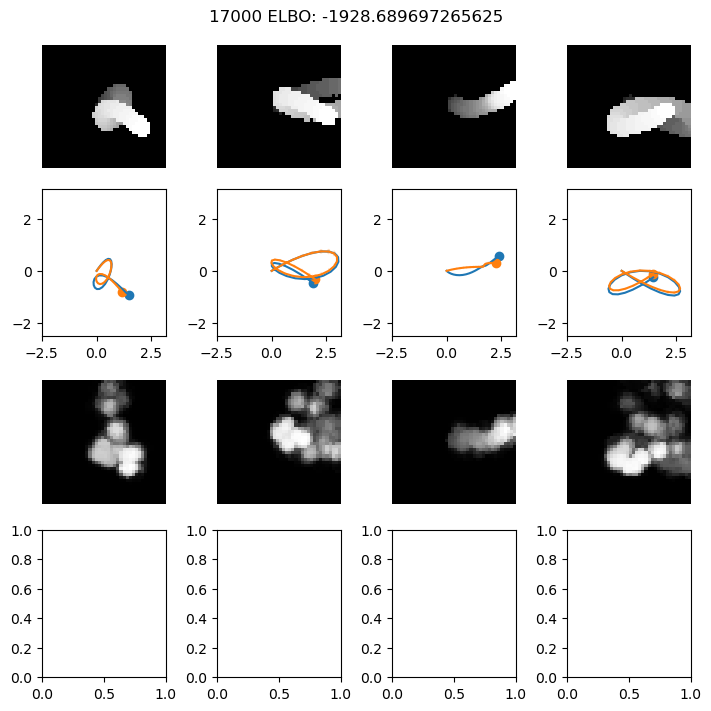

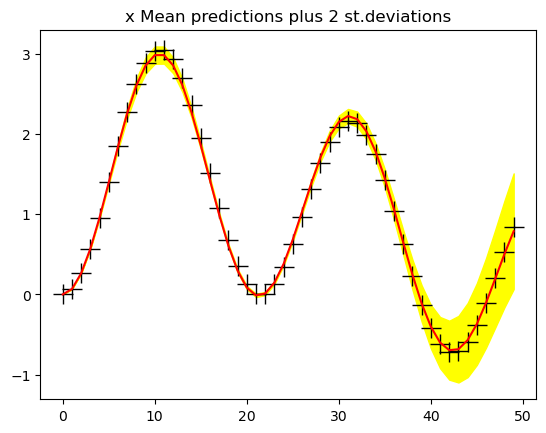

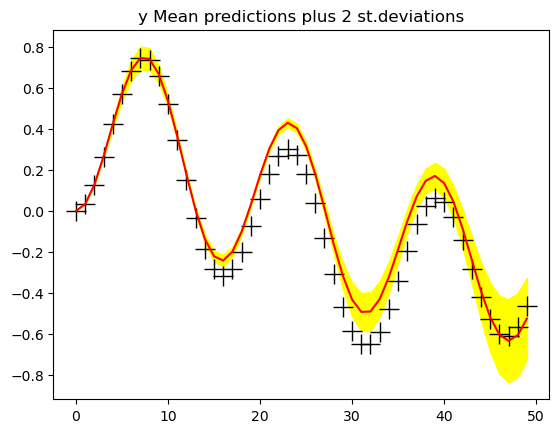


Test set: Avg. loss: 0.0001

Train Epoch: 17050 	Loss: 1919.998413	 898.043335	 1021.955109
Train Epoch: 17100 	Loss: 1936.701782	 929.503662	 1007.198143
Train Epoch: 17150 	Loss: 1933.454956	 912.767578	 1020.687389
Train Epoch: 17200 	Loss: 1934.520264	 909.507019	 1025.013161
Train Epoch: 17250 	Loss: 1922.484985	 903.390015	 1019.094944
Train Epoch: 17300 	Loss: 1932.950928	 920.794312	 1012.156582
Train Epoch: 17350 	Loss: 1935.367310	 906.125366	 1029.241943
Train Epoch: 17400 	Loss: 1922.603516	 881.405457	 1041.197968
Train Epoch: 17450 	Loss: 1930.077881	 918.519043	 1011.558819
Train Epoch: 17500 	Loss: 1939.490967	 918.063965	 1021.427059
Train Epoch: 17550 	Loss: 1925.892822	 914.059326	 1011.833477
Train Epoch: 17600 	Loss: 1933.715210	 905.219116	 1028.496075
Train Epoch: 17650 	Loss: 1931.204346	 918.567505	 1012.636757
Train Epoch: 17700 	Loss: 1922.968262	 910.610840	 1012.357426
Train Epoch: 17750 	Loss: 1936.720947	 902.761963	 1033.959007
Train Epoch: 17800 	Loss:

<Figure size 640x480 with 0 Axes>

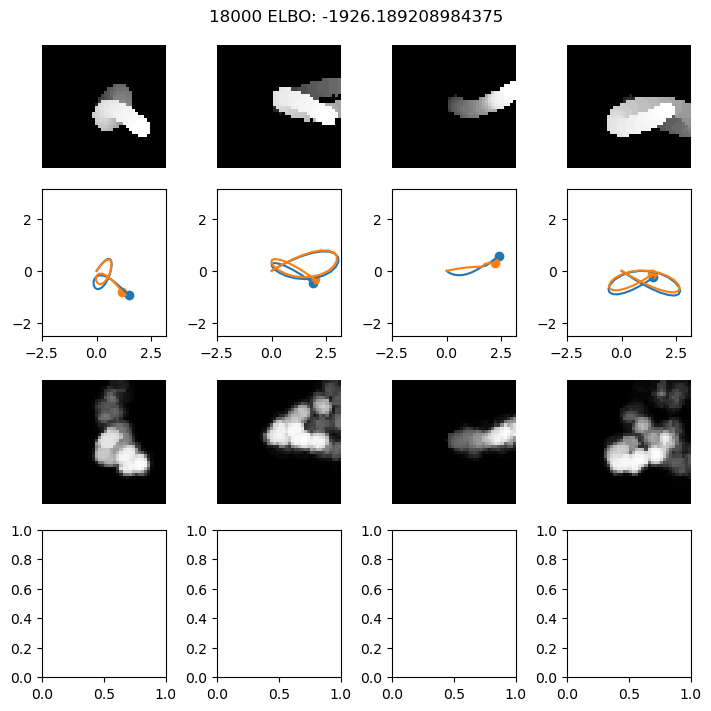

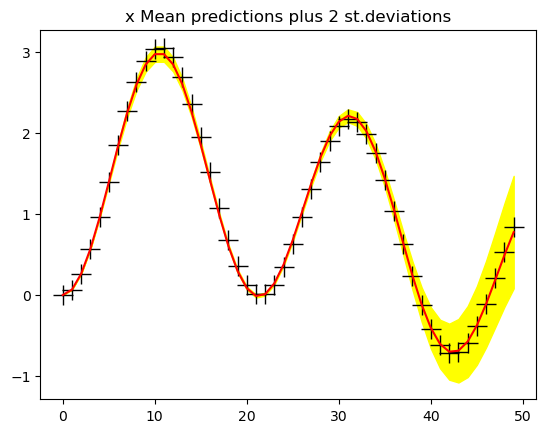

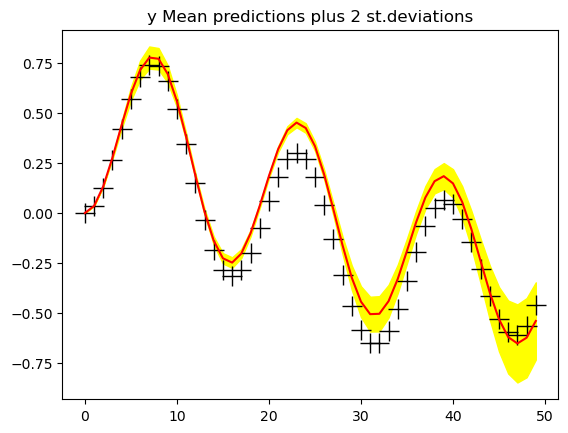


Test set: Avg. loss: 0.0001

Train Epoch: 18050 	Loss: 1925.945923	 906.717285	 1019.228649
Train Epoch: 18100 	Loss: 1929.256836	 902.017517	 1027.239227
Train Epoch: 18150 	Loss: 1929.569458	 898.162598	 1031.406879
Train Epoch: 18200 	Loss: 1937.665039	 924.688293	 1012.976837
Train Epoch: 18250 	Loss: 1930.392334	 913.616150	 1016.776180
Train Epoch: 18300 	Loss: 1936.655029	 908.066467	 1028.588581
Train Epoch: 18350 	Loss: 1914.713989	 897.899658	 1016.814327
Train Epoch: 18400 	Loss: 1921.477539	 908.921265	 1012.556362
Train Epoch: 18450 	Loss: 1916.203003	 888.273804	 1027.929211
Train Epoch: 18500 	Loss: 1929.885254	 914.009705	 1015.875626
Train Epoch: 18550 	Loss: 1933.825684	 901.973572	 1031.852055
Train Epoch: 18600 	Loss: 1939.199097	 914.757202	 1024.441910
Train Epoch: 18650 	Loss: 1918.137451	 879.970764	 1038.166618
Train Epoch: 18700 	Loss: 1929.205933	 908.748108	 1020.457840
Train Epoch: 18750 	Loss: 1926.837524	 893.582642	 1033.254910
Train Epoch: 18800 	Loss:

<Figure size 640x480 with 0 Axes>

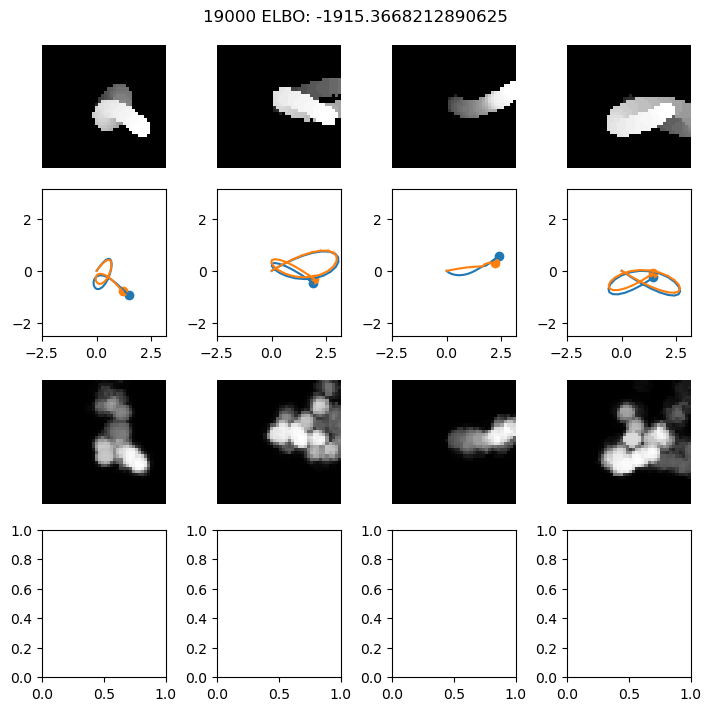

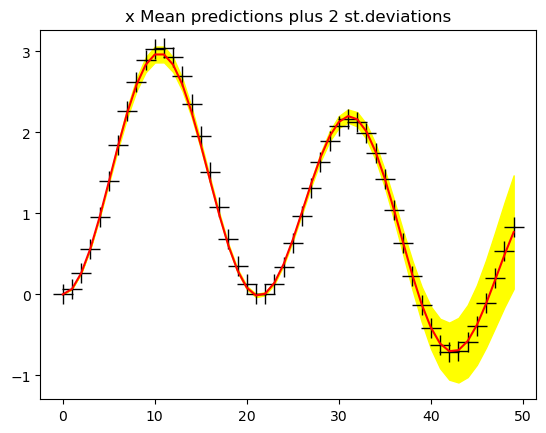

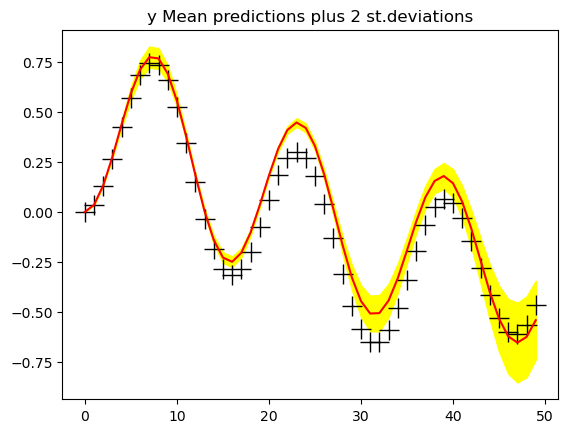


Test set: Avg. loss: 0.0001

Train Epoch: 19050 	Loss: 1925.054443	 900.303650	 1024.750710
Train Epoch: 19100 	Loss: 1922.327271	 897.020142	 1025.307083
Train Epoch: 19150 	Loss: 1930.364746	 896.913696	 1033.451080
Train Epoch: 19200 	Loss: 1931.472900	 907.689148	 1023.783779
Train Epoch: 19250 	Loss: 1934.220825	 917.634827	 1016.586018
Train Epoch: 19300 	Loss: 1928.558594	 906.173279	 1022.385406
Train Epoch: 19350 	Loss: 1921.869629	 910.308289	 1011.561394
Train Epoch: 19400 	Loss: 1921.084351	 896.861816	 1024.222565
Train Epoch: 19450 	Loss: 1922.355225	 882.997864	 1039.357376
Train Epoch: 19500 	Loss: 1935.478027	 904.704529	 1030.773544
Train Epoch: 19550 	Loss: 1943.714844	 925.630798	 1018.083954
Train Epoch: 19600 	Loss: 1932.571167	 909.188721	 1023.382473
Train Epoch: 19650 	Loss: 1925.997925	 894.793579	 1031.204319
Train Epoch: 19700 	Loss: 1928.855225	 906.142273	 1022.712898
Train Epoch: 19750 	Loss: 1916.878418	 883.277649	 1033.600807
Train Epoch: 19800 	Loss:

<Figure size 640x480 with 0 Axes>

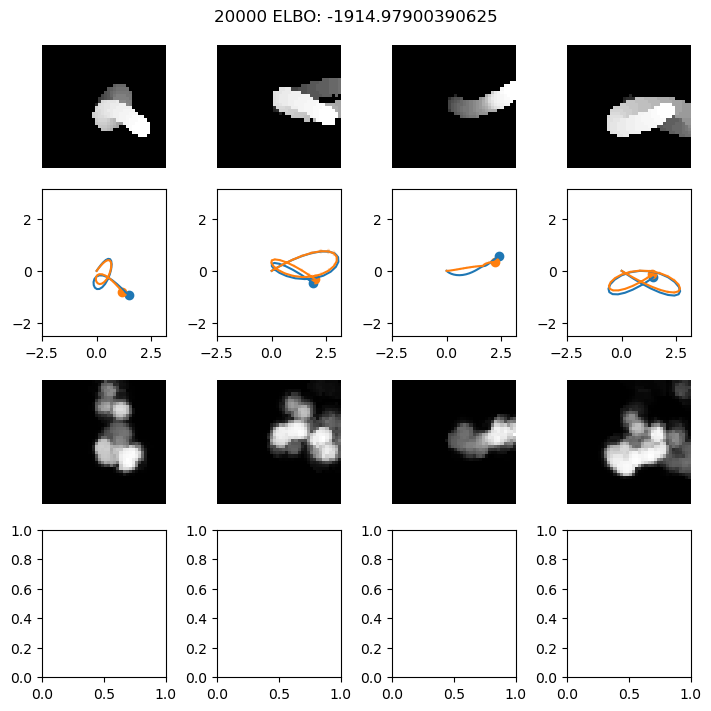

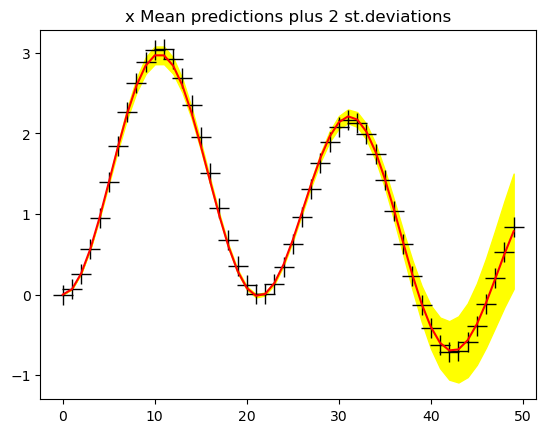

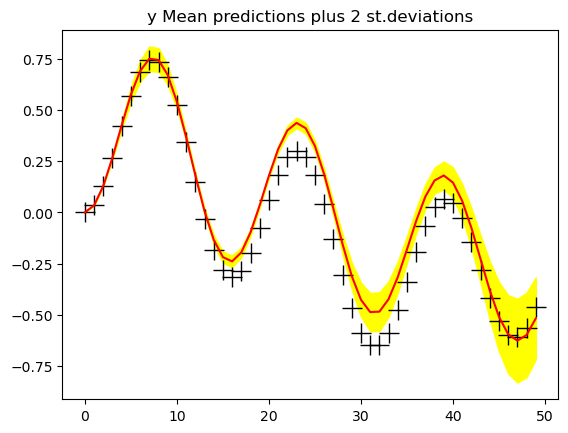


Test set: Avg. loss: 0.0001

Train Epoch: 20050 	Loss: 1932.056396	 908.233459	 1023.822975
Train Epoch: 20100 	Loss: 1926.131104	 902.292969	 1023.838139
Train Epoch: 20150 	Loss: 1934.610840	 911.280640	 1023.330212
Train Epoch: 20200 	Loss: 1953.336182	 925.271851	 1028.064346
Train Epoch: 20250 	Loss: 1922.539062	 901.606567	 1020.932484
Train Epoch: 20300 	Loss: 1930.654053	 886.266174	 1044.387817
Train Epoch: 20350 	Loss: 1920.890625	 890.345215	 1030.545425
Train Epoch: 20400 	Loss: 1921.517822	 881.137573	 1040.380287
Train Epoch: 20450 	Loss: 1911.061646	 883.563965	 1027.497673
Train Epoch: 20500 	Loss: 1937.690430	 907.263733	 1030.426788
Train Epoch: 20550 	Loss: 1928.362915	 918.168518	 1010.194397
Train Epoch: 20600 	Loss: 1929.247070	 904.310486	 1024.936485
Train Epoch: 20650 	Loss: 1912.626221	 871.087830	 1041.538334
Train Epoch: 20700 	Loss: 1949.928833	 927.913330	 1022.015476
Train Epoch: 20750 	Loss: 1915.104492	 879.102600	 1036.001873
Train Epoch: 20800 	Loss:

<Figure size 640x480 with 0 Axes>

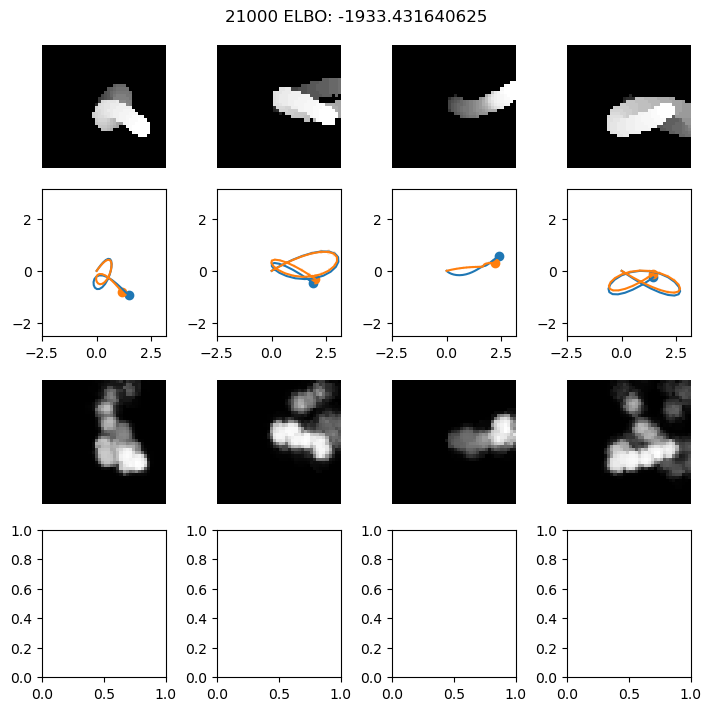

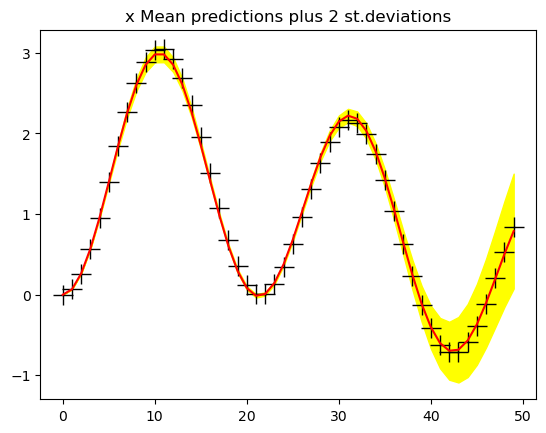

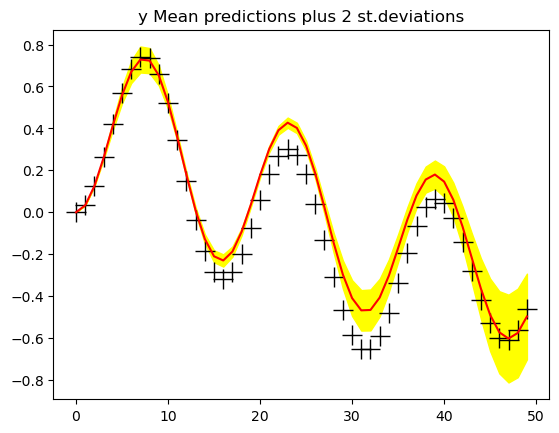


Test set: Avg. loss: 0.0001

Train Epoch: 21050 	Loss: 1927.127441	 893.156982	 1033.970451
Train Epoch: 21100 	Loss: 1926.761719	 882.593567	 1044.168186
Train Epoch: 21150 	Loss: 1922.775269	 887.890015	 1034.885216
Train Epoch: 21200 	Loss: 1918.395020	 879.451904	 1038.943100
Train Epoch: 21250 	Loss: 1917.371094	 882.987122	 1034.383869
Train Epoch: 21300 	Loss: 1913.272339	 877.398804	 1035.873508
Train Epoch: 21350 	Loss: 1925.884399	 881.352051	 1044.532394
Train Epoch: 21400 	Loss: 1934.489380	 905.477417	 1029.011917
Train Epoch: 21450 	Loss: 1922.123291	 887.153748	 1034.969521
Train Epoch: 21500 	Loss: 1937.468994	 901.688049	 1035.781002
Train Epoch: 21550 	Loss: 1917.618164	 887.269897	 1030.348301
Train Epoch: 21600 	Loss: 1912.161621	 877.790710	 1034.370804
Train Epoch: 21650 	Loss: 1933.620728	 899.378906	 1034.241867
Train Epoch: 21700 	Loss: 1925.717529	 897.620056	 1028.097439
Train Epoch: 21750 	Loss: 1924.524902	 879.983459	 1044.541359
Train Epoch: 21800 	Loss:

<Figure size 640x480 with 0 Axes>

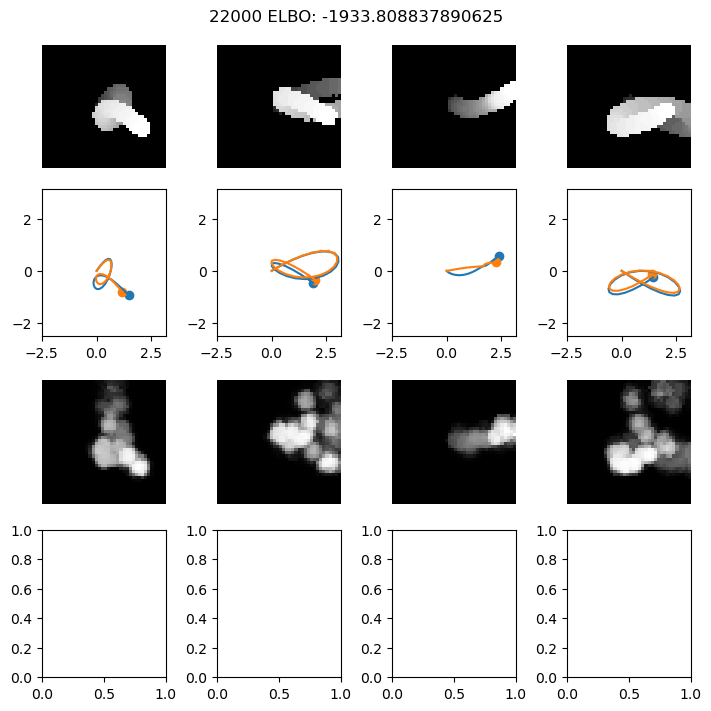

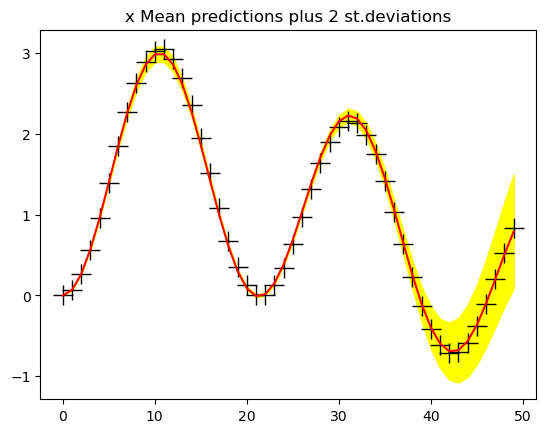

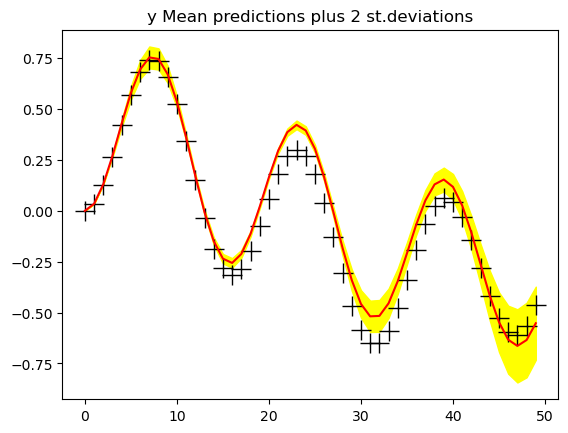


Test set: Avg. loss: 0.0001

Train Epoch: 22050 	Loss: 1927.387695	 892.635254	 1034.752464
Train Epoch: 22100 	Loss: 1916.323242	 872.179382	 1044.143963
Train Epoch: 22150 	Loss: 1922.358643	 896.154236	 1026.204491
Train Epoch: 22200 	Loss: 1926.779419	 889.476807	 1037.302589
Train Epoch: 22250 	Loss: 1908.108887	 869.489014	 1038.619900
Train Epoch: 22300 	Loss: 1916.810303	 881.396667	 1035.413551
Train Epoch: 22350 	Loss: 1924.046387	 892.368286	 1031.678104
Train Epoch: 22400 	Loss: 1909.849365	 869.508545	 1040.340805
Train Epoch: 22450 	Loss: 1917.801025	 888.101746	 1029.699326
Train Epoch: 22500 	Loss: 1934.681396	 900.357056	 1034.324360
Train Epoch: 22550 	Loss: 1914.061279	 879.922424	 1034.138870
Train Epoch: 22600 	Loss: 1926.361450	 879.804688	 1046.556759
Train Epoch: 22650 	Loss: 1924.246582	 900.270569	 1023.976040
Train Epoch: 22700 	Loss: 1904.172852	 860.071716	 1044.101048
Train Epoch: 22750 	Loss: 1928.352539	 887.591064	 1040.761471
Train Epoch: 22800 	Loss:

<Figure size 640x480 with 0 Axes>

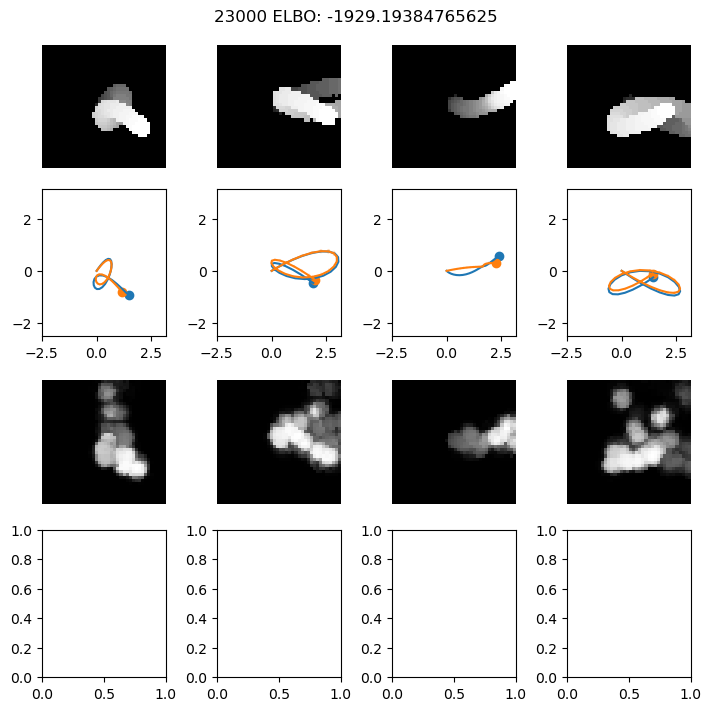

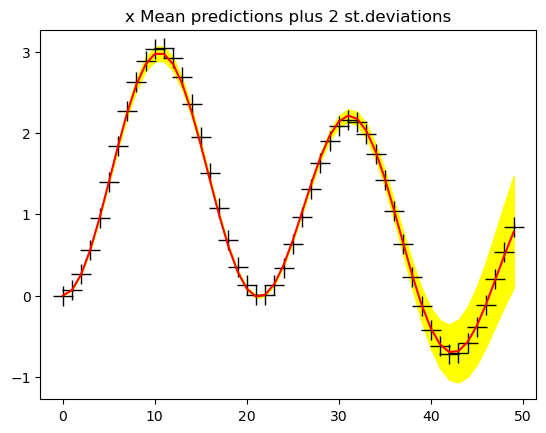

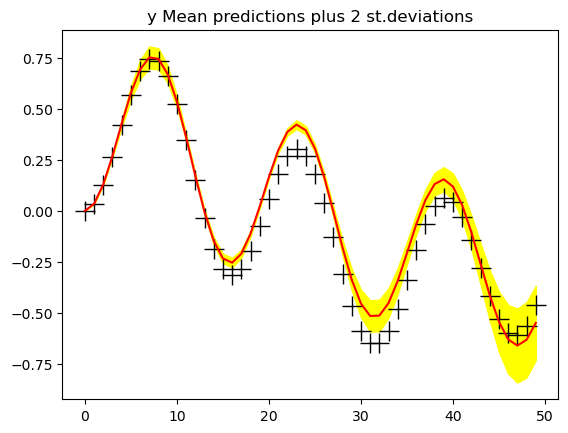


Test set: Avg. loss: 0.0001

Train Epoch: 23050 	Loss: 1924.653931	 880.153809	 1044.500160
Train Epoch: 23100 	Loss: 1940.106201	 921.776428	 1018.329811
Train Epoch: 23150 	Loss: 1914.618408	 882.074402	 1032.543945
Train Epoch: 23200 	Loss: 1927.149048	 885.517090	 1041.631985
Train Epoch: 23250 	Loss: 1935.953125	 893.292725	 1042.660427
Train Epoch: 23300 	Loss: 1927.743652	 890.885925	 1036.857700
Train Epoch: 23350 	Loss: 1931.740967	 886.092834	 1045.648193
Train Epoch: 23400 	Loss: 1922.352783	 878.933289	 1043.419552
Train Epoch: 23450 	Loss: 1935.833740	 903.095459	 1032.738304
Train Epoch: 23500 	Loss: 1922.032471	 885.648682	 1036.383820
Train Epoch: 23550 	Loss: 1928.696777	 886.230469	 1042.466354
Train Epoch: 23600 	Loss: 1931.436157	 896.652832	 1034.783363
Train Epoch: 23650 	Loss: 1923.406006	 869.255371	 1054.150677
Train Epoch: 23700 	Loss: 1916.711914	 892.196533	 1024.515343
Train Epoch: 23750 	Loss: 1921.481445	 885.041077	 1036.440468
Train Epoch: 23800 	Loss:

<Figure size 640x480 with 0 Axes>

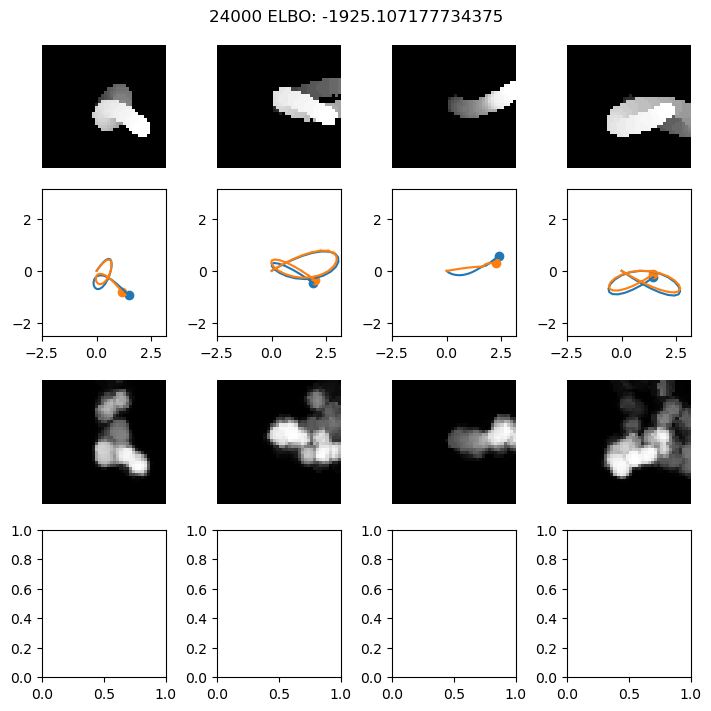

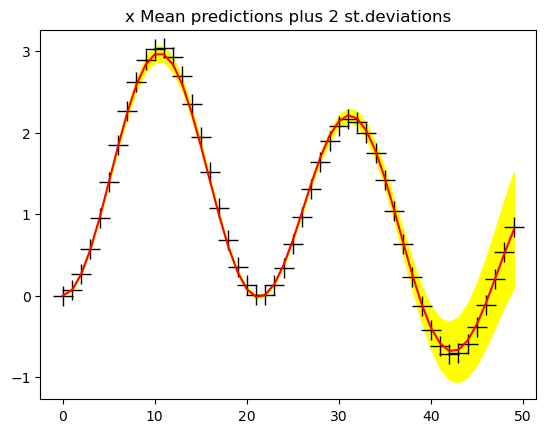

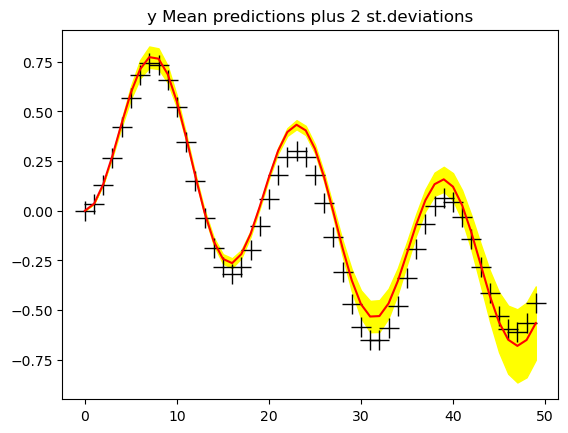


Test set: Avg. loss: 0.0001

Train Epoch: 24050 	Loss: 1931.345703	 876.605164	 1054.740524
Train Epoch: 24100 	Loss: 1923.683838	 873.816467	 1049.867344
Train Epoch: 24150 	Loss: 1907.541748	 866.132874	 1041.408825
Train Epoch: 24200 	Loss: 1927.609131	 889.332336	 1038.276863
Train Epoch: 24250 	Loss: 1931.891235	 898.071899	 1033.819294
Train Epoch: 24300 	Loss: 1912.723389	 869.260254	 1043.463135
Train Epoch: 24350 	Loss: 1920.179199	 872.734192	 1047.445107
Train Epoch: 24400 	Loss: 1921.101196	 884.531616	 1036.569595
Train Epoch: 24450 	Loss: 1938.964600	 920.145996	 1018.818569
Train Epoch: 24500 	Loss: 1926.233643	 884.357361	 1041.876316
Train Epoch: 24550 	Loss: 1921.025879	 888.031433	 1032.994366
Train Epoch: 24600 	Loss: 1913.166626	 867.501221	 1045.665359
Train Epoch: 24650 	Loss: 1922.855957	 883.200256	 1039.655685
Train Epoch: 24700 	Loss: 1918.664795	 882.989685	 1035.675049
Train Epoch: 24750 	Loss: 1911.007568	 867.539124	 1043.468380
Train Epoch: 24800 	Loss:

<Figure size 640x480 with 0 Axes>

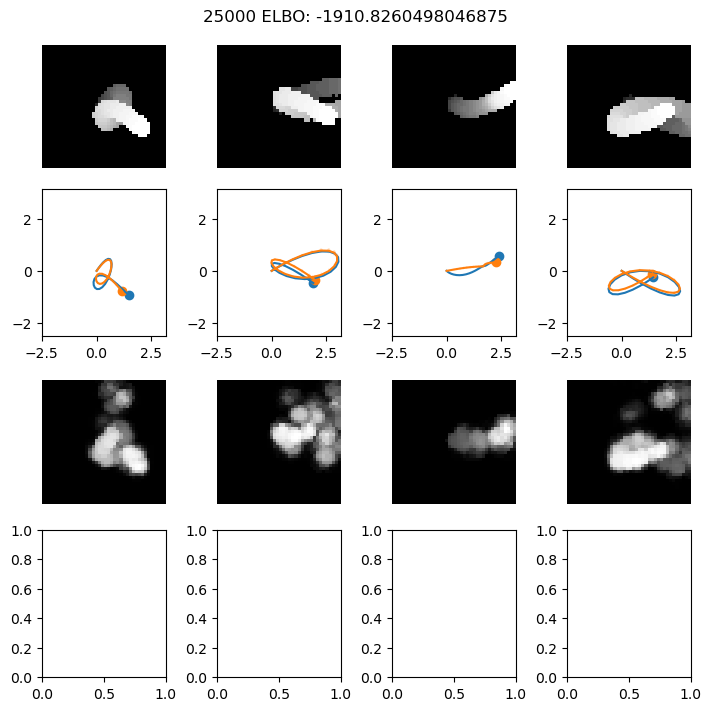

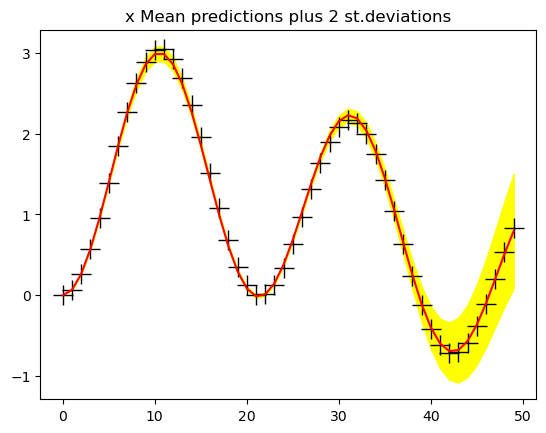

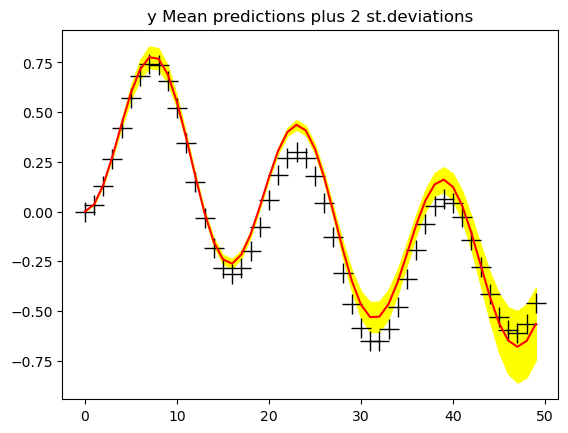


Test set: Avg. loss: 0.0001

Train Epoch: 25050 	Loss: 1921.741333	 872.994141	 1048.747158
Train Epoch: 25100 	Loss: 1931.407471	 887.665649	 1043.741798
Train Epoch: 25150 	Loss: 1925.085693	 887.912720	 1037.172985
Train Epoch: 25200 	Loss: 1913.911133	 870.607239	 1043.303871
Train Epoch: 25250 	Loss: 1929.682617	 885.538574	 1044.144058
Train Epoch: 25300 	Loss: 1925.039429	 895.416870	 1029.622555
Train Epoch: 25350 	Loss: 1911.447998	 868.210144	 1043.237782
Train Epoch: 25400 	Loss: 1914.147461	 877.797180	 1036.350346
Train Epoch: 25450 	Loss: 1920.413330	 879.387939	 1041.025352
Train Epoch: 25500 	Loss: 1919.953857	 886.786926	 1033.166981
Train Epoch: 25550 	Loss: 1928.435059	 875.022522	 1053.412628
Train Epoch: 25600 	Loss: 1921.804932	 886.521484	 1035.283470
Train Epoch: 25650 	Loss: 1925.484863	 887.096619	 1038.388157
Train Epoch: 25700 	Loss: 1915.773926	 885.015686	 1030.758190
Train Epoch: 25750 	Loss: 1913.045654	 866.148254	 1046.897316
Train Epoch: 25800 	Loss:

<Figure size 640x480 with 0 Axes>

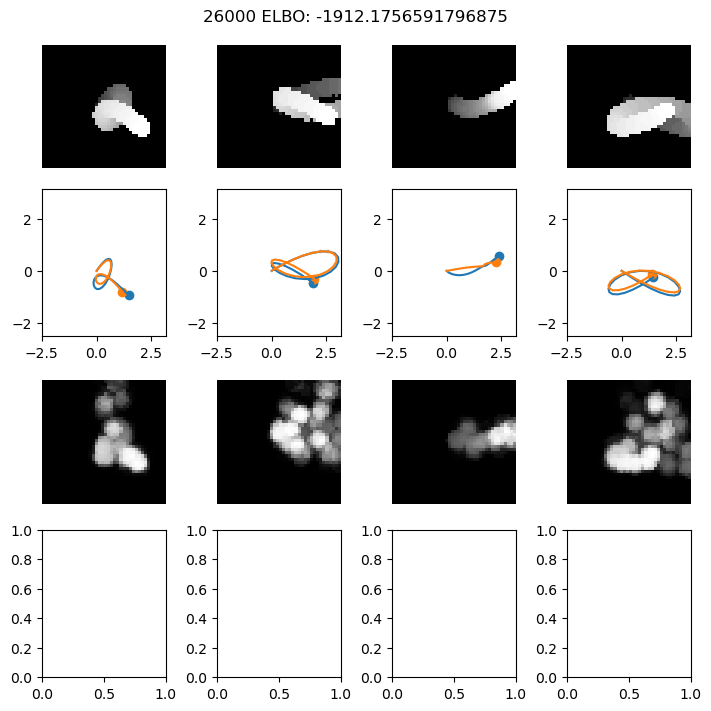

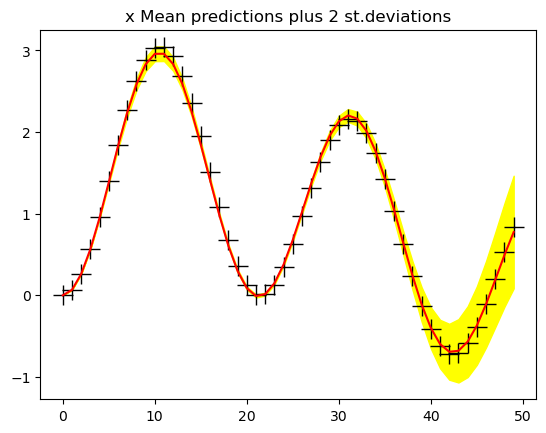

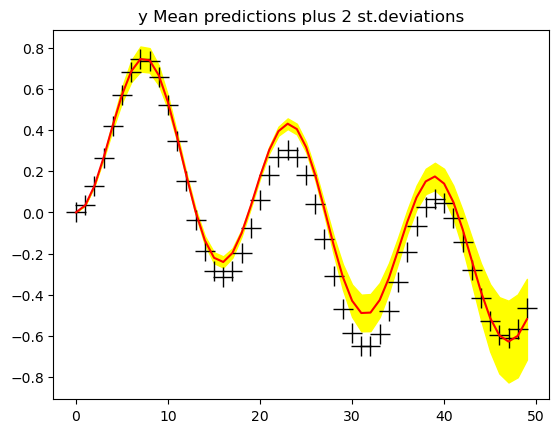


Test set: Avg. loss: 0.0001

Train Epoch: 26050 	Loss: 1930.609863	 894.088806	 1036.520958
Train Epoch: 26100 	Loss: 1924.348267	 879.988770	 1044.359493
Train Epoch: 26150 	Loss: 1927.059082	 886.977966	 1040.081024
Train Epoch: 26200 	Loss: 1921.028198	 890.189453	 1030.838776
Train Epoch: 26250 	Loss: 1925.682617	 883.737671	 1041.944981
Train Epoch: 26300 	Loss: 1912.399292	 877.247192	 1035.152054
Train Epoch: 26350 	Loss: 1923.495605	 874.044983	 1049.450588
Train Epoch: 26400 	Loss: 1924.667236	 887.243408	 1037.423801
Train Epoch: 26450 	Loss: 1926.641357	 881.081726	 1045.559597
Train Epoch: 26500 	Loss: 1922.914062	 872.207825	 1050.706196
Train Epoch: 26550 	Loss: 1937.754639	 898.714844	 1039.039803
Train Epoch: 26600 	Loss: 1912.935303	 881.530151	 1031.405163
Train Epoch: 26650 	Loss: 1924.283203	 878.288330	 1045.994854
Train Epoch: 26700 	Loss: 1921.394287	 867.997009	 1053.397179
Train Epoch: 26750 	Loss: 1917.630615	 870.694519	 1046.936131
Train Epoch: 26800 	Loss:

<Figure size 640x480 with 0 Axes>

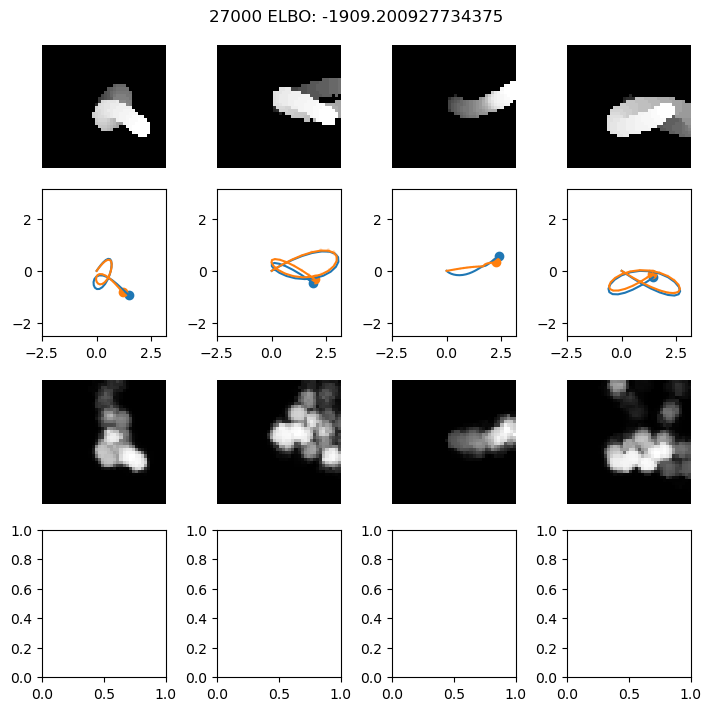

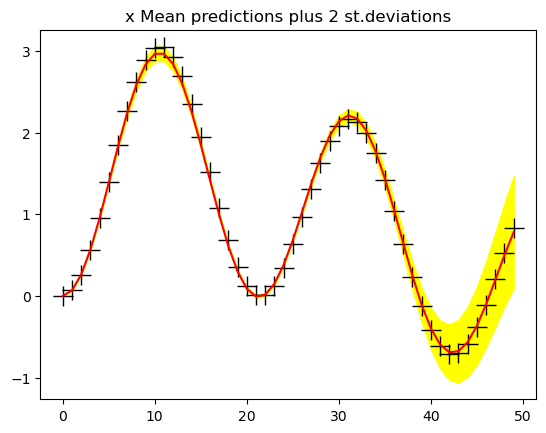

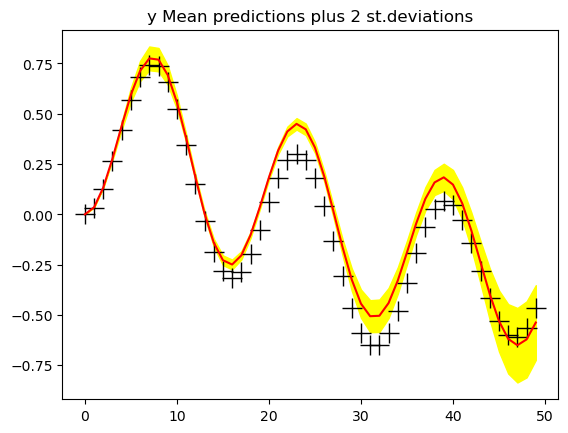


Test set: Avg. loss: 0.0001

Train Epoch: 27050 	Loss: 1931.322510	 893.746033	 1037.576580
Train Epoch: 27100 	Loss: 1914.261475	 872.746643	 1041.514874
Train Epoch: 27150 	Loss: 1914.511597	 873.107666	 1041.403961
Train Epoch: 27200 	Loss: 1921.563965	 855.858582	 1065.705299
Train Epoch: 27250 	Loss: 1925.823975	 870.663208	 1055.160809
Train Epoch: 27300 	Loss: 1914.861084	 874.948608	 1039.912510
Train Epoch: 27350 	Loss: 1908.997681	 865.455078	 1043.542576
Train Epoch: 27400 	Loss: 1914.166382	 869.627319	 1044.539070
Train Epoch: 27450 	Loss: 1914.430908	 875.842590	 1038.588238
Train Epoch: 27500 	Loss: 1925.069824	 890.937439	 1034.132481
Train Epoch: 27550 	Loss: 1920.644043	 876.966858	 1043.677139
Train Epoch: 27600 	Loss: 1926.410889	 886.854675	 1039.556122
Train Epoch: 27650 	Loss: 1921.584229	 882.349670	 1039.234543
Train Epoch: 27700 	Loss: 1917.513672	 884.972351	 1032.541275
Train Epoch: 27750 	Loss: 1913.624268	 866.349548	 1047.274780
Train Epoch: 27800 	Loss:

<Figure size 640x480 with 0 Axes>

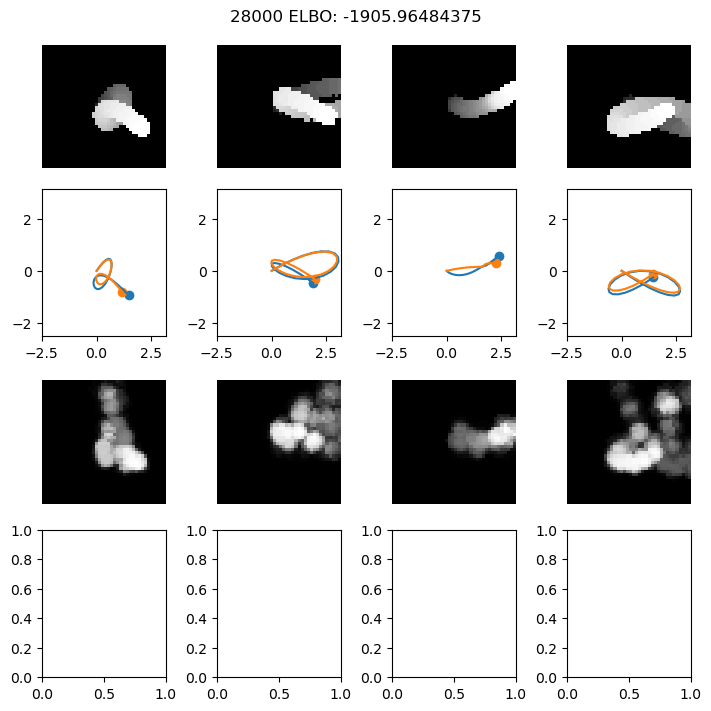

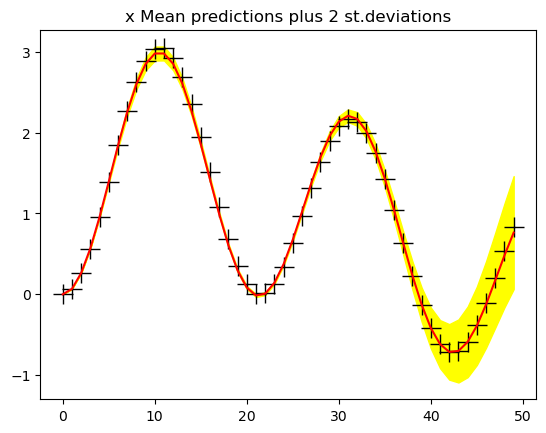

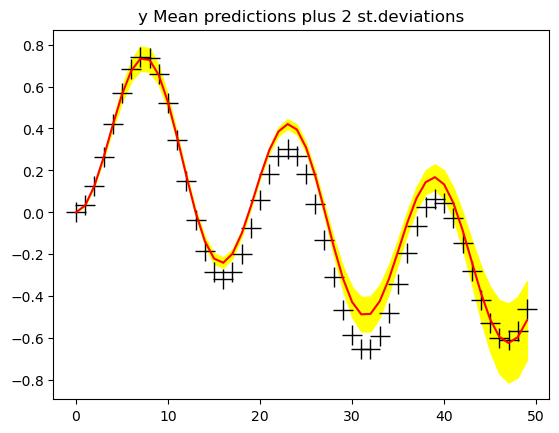


Test set: Avg. loss: 0.0001

Train Epoch: 28050 	Loss: 1905.011963	 856.564209	 1048.447800
Train Epoch: 28100 	Loss: 1917.478516	 860.724792	 1056.753635
Train Epoch: 28150 	Loss: 1931.034424	 878.951538	 1052.082920
Train Epoch: 28200 	Loss: 1921.429932	 879.849548	 1041.580486
Train Epoch: 28250 	Loss: 1912.822021	 867.347961	 1045.473957
Train Epoch: 28300 	Loss: 1932.777100	 883.667358	 1049.109745
Train Epoch: 28350 	Loss: 1926.889160	 879.251404	 1047.637653
Train Epoch: 28400 	Loss: 1929.094849	 893.679932	 1035.414886
Train Epoch: 28450 	Loss: 1917.443359	 874.900085	 1042.543316
Train Epoch: 28500 	Loss: 1936.463867	 897.675964	 1038.787842
Train Epoch: 28550 	Loss: 1922.854004	 890.239746	 1032.614231
Train Epoch: 28600 	Loss: 1931.331665	 901.294189	 1030.037498
Train Epoch: 28650 	Loss: 1926.794434	 891.122986	 1035.671425
Train Epoch: 28700 	Loss: 1926.245117	 880.437012	 1045.808125
Train Epoch: 28750 	Loss: 1935.843628	 889.785645	 1046.057987
Train Epoch: 28800 	Loss:

<Figure size 640x480 with 0 Axes>

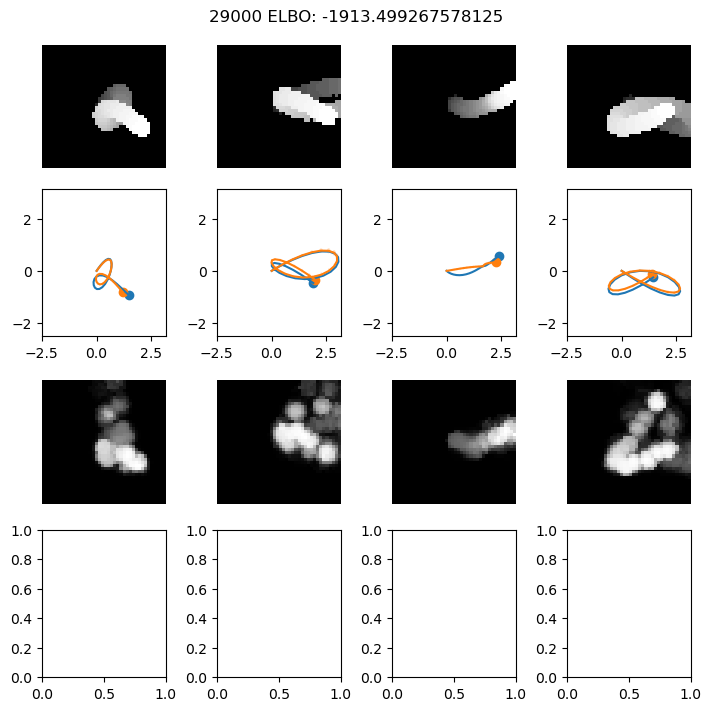

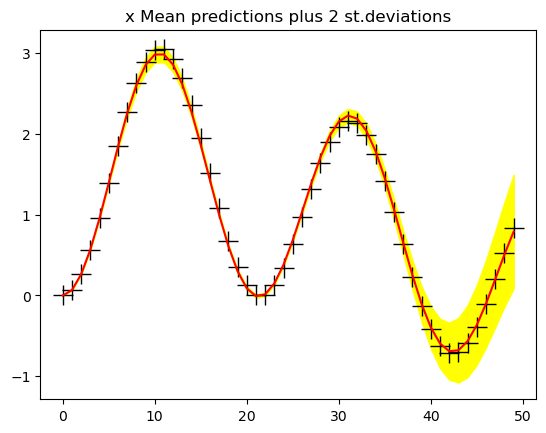

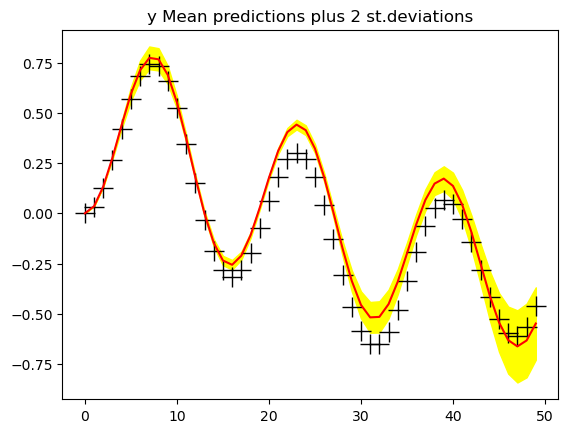


Test set: Avg. loss: 0.0001

Train Epoch: 29050 	Loss: 1913.245605	 878.667175	 1034.578514
Train Epoch: 29100 	Loss: 1916.551636	 855.164795	 1061.386871
Train Epoch: 29150 	Loss: 1918.423218	 863.883179	 1054.540062
Train Epoch: 29200 	Loss: 1912.425415	 859.750854	 1052.674580
Train Epoch: 29250 	Loss: 1931.180542	 885.530151	 1045.650387
Train Epoch: 29300 	Loss: 1913.619141	 868.637024	 1044.982147
Train Epoch: 29350 	Loss: 1918.159668	 882.265442	 1035.894203
Train Epoch: 29400 	Loss: 1924.138184	 885.927551	 1038.210678
Train Epoch: 29450 	Loss: 1928.399902	 862.184631	 1066.215324
Train Epoch: 29500 	Loss: 1918.143311	 873.940186	 1044.203091
Train Epoch: 29550 	Loss: 1906.112305	 858.264221	 1047.848129
Train Epoch: 29600 	Loss: 1922.416504	 868.907166	 1053.509426
Train Epoch: 29650 	Loss: 1905.762207	 859.146179	 1046.615982
Train Epoch: 29700 	Loss: 1926.406250	 887.065857	 1039.340496
Train Epoch: 29750 	Loss: 1910.167236	 854.471252	 1055.695915
Train Epoch: 29800 	Loss:

<Figure size 640x480 with 0 Axes>

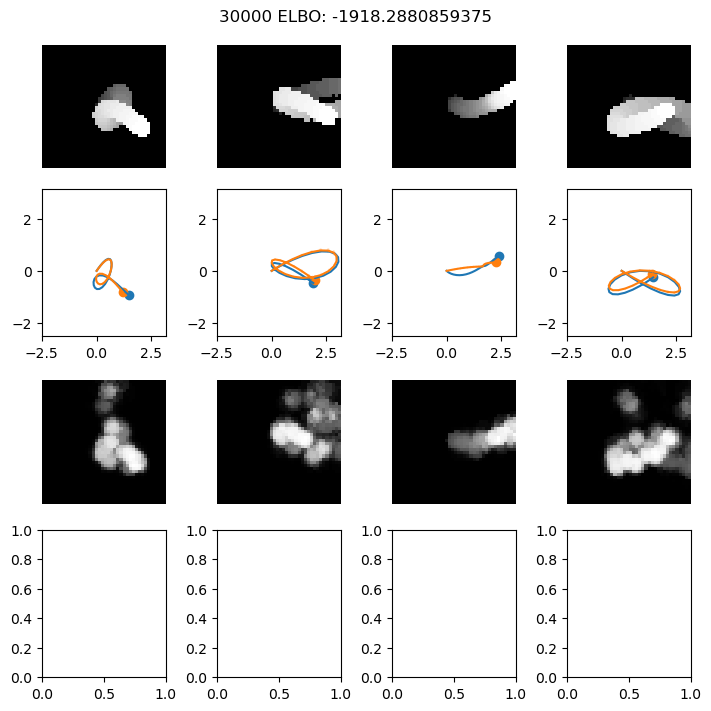

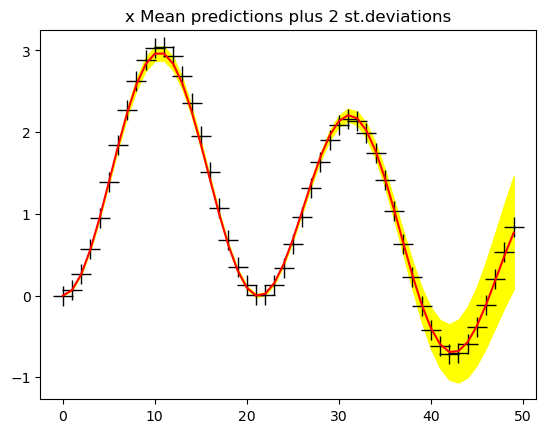

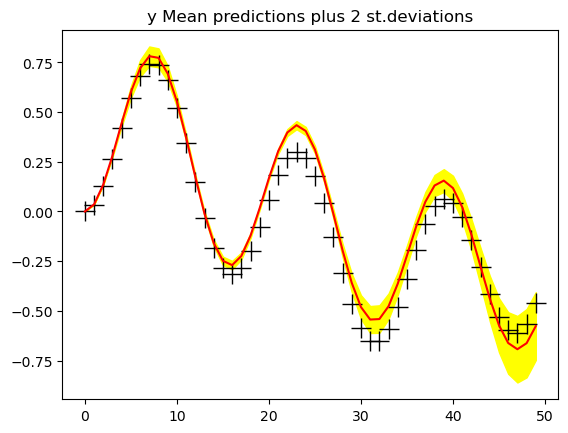


Test set: Avg. loss: 0.0001

Train Epoch: 30050 	Loss: 1921.094604	 872.101929	 1048.992634
Train Epoch: 30100 	Loss: 1923.409912	 879.876587	 1043.533325
Train Epoch: 30150 	Loss: 1908.901978	 858.908203	 1049.993801
Train Epoch: 30200 	Loss: 1930.756836	 882.383850	 1048.373032
Train Epoch: 30250 	Loss: 1926.653076	 878.116577	 1048.536491
Train Epoch: 30300 	Loss: 1936.740967	 898.711731	 1038.029289
Train Epoch: 30350 	Loss: 1916.612061	 872.713989	 1043.898106
Train Epoch: 30400 	Loss: 1923.299927	 886.440186	 1036.859703
Train Epoch: 30450 	Loss: 1908.412354	 859.987488	 1048.424911
Train Epoch: 30500 	Loss: 1928.022949	 875.219543	 1052.803421
Train Epoch: 30550 	Loss: 1917.512207	 873.718018	 1043.794155
Train Epoch: 30600 	Loss: 1921.925171	 877.864868	 1044.060326
Train Epoch: 30650 	Loss: 1917.678467	 871.745483	 1045.932961
Train Epoch: 30700 	Loss: 1923.631348	 877.652405	 1045.979023
Train Epoch: 30750 	Loss: 1915.786133	 877.583984	 1038.202190
Train Epoch: 30800 	Loss:

<Figure size 640x480 with 0 Axes>

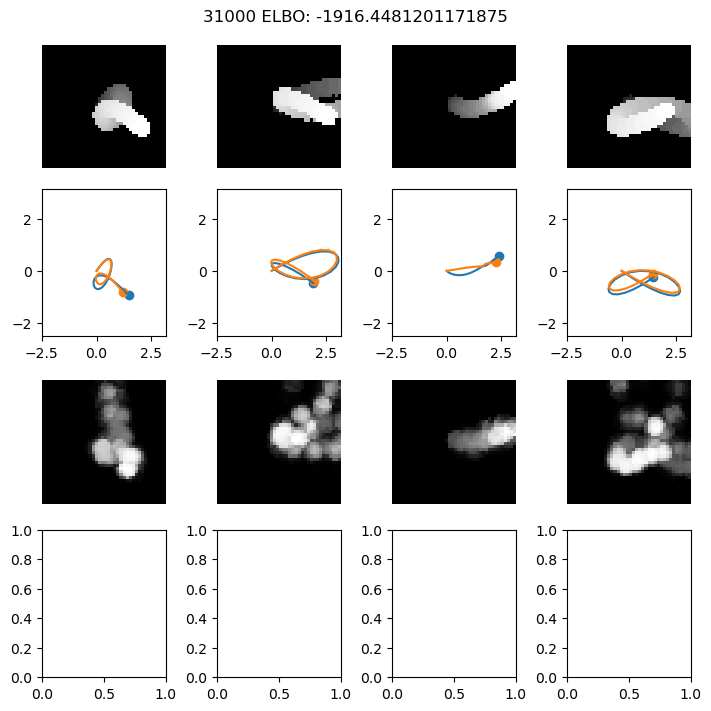

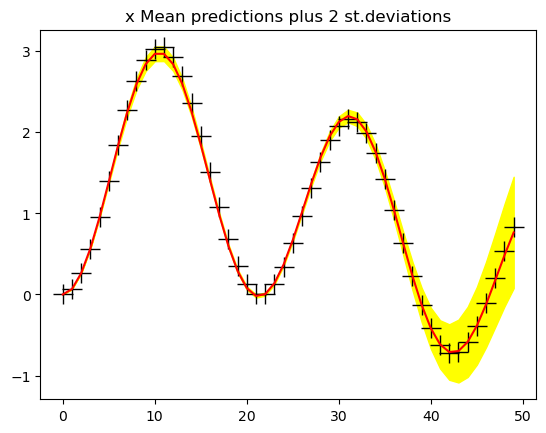

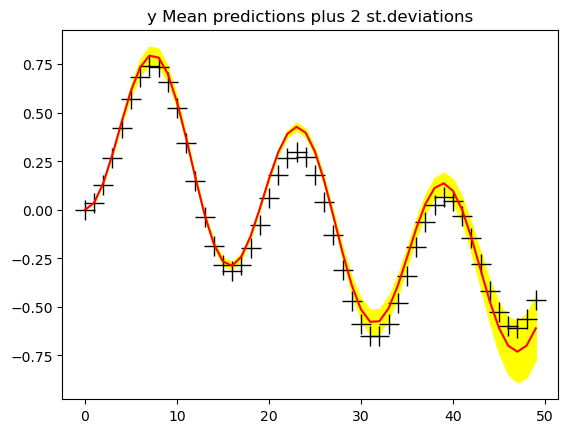


Test set: Avg. loss: 0.0001

Train Epoch: 31050 	Loss: 1922.063232	 873.830017	 1048.233128
Train Epoch: 31100 	Loss: 1912.332520	 881.313660	 1031.018925
Train Epoch: 31150 	Loss: 1931.810547	 884.415833	 1047.394657
Train Epoch: 31200 	Loss: 1928.109009	 866.967163	 1061.141872
Train Epoch: 31250 	Loss: 1925.371338	 882.194824	 1043.176556
Train Epoch: 31300 	Loss: 1911.049561	 864.008301	 1047.041225
Train Epoch: 31350 	Loss: 1927.127930	 871.380554	 1055.747318
Train Epoch: 31400 	Loss: 1900.685791	 850.902161	 1049.783707
Train Epoch: 31450 	Loss: 1912.632324	 860.642212	 1051.990128
Train Epoch: 31500 	Loss: 1915.075928	 850.897278	 1064.178753
Train Epoch: 31550 	Loss: 1928.893555	 892.902588	 1035.991001
Train Epoch: 31600 	Loss: 1909.335449	 860.781860	 1048.553562
Train Epoch: 31650 	Loss: 1915.024170	 876.209167	 1038.815022
Train Epoch: 31700 	Loss: 1919.579346	 872.763367	 1046.815872
Train Epoch: 31750 	Loss: 1921.264648	 871.908752	 1049.355984
Train Epoch: 31800 	Loss:

<Figure size 640x480 with 0 Axes>

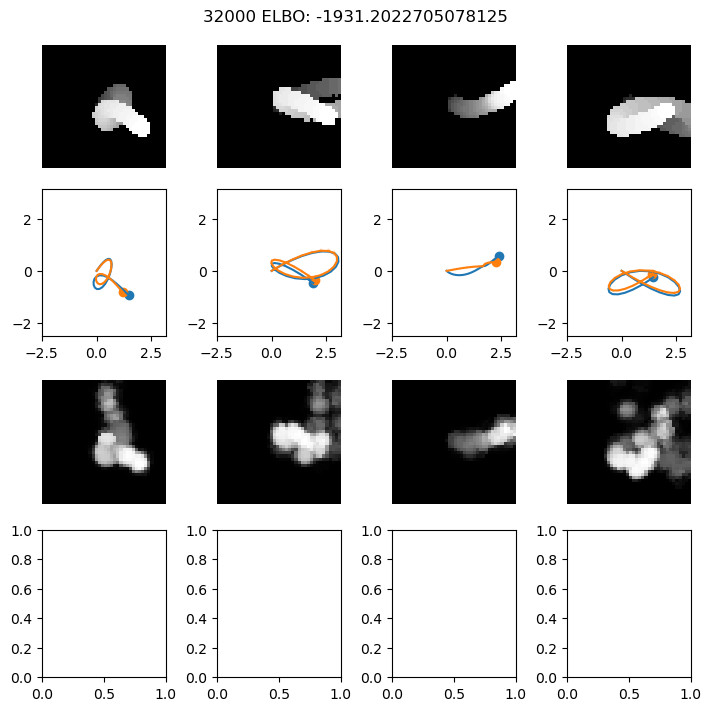

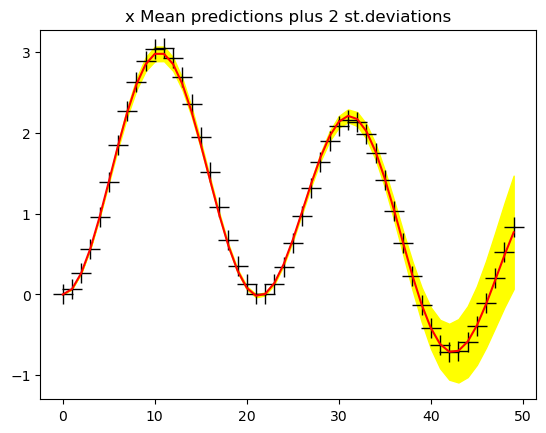

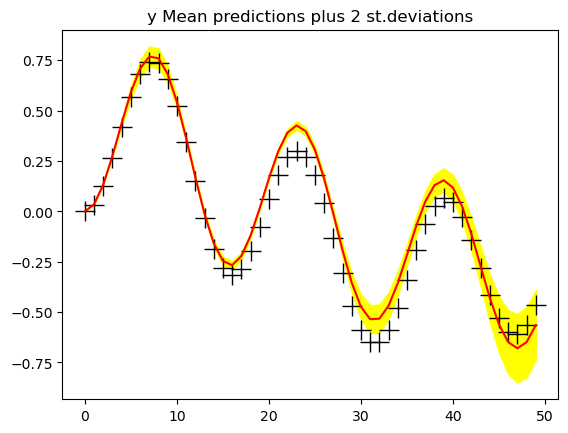


Test set: Avg. loss: 0.0001

Train Epoch: 32050 	Loss: 1921.450684	 877.857666	 1043.593025
Train Epoch: 32100 	Loss: 1908.656860	 853.176270	 1055.480576
Train Epoch: 32150 	Loss: 1918.371582	 861.293762	 1057.077885
Train Epoch: 32200 	Loss: 1899.259644	 865.866821	 1033.392811
Train Epoch: 32250 	Loss: 1927.135254	 888.940674	 1038.194561
Train Epoch: 32300 	Loss: 1927.117065	 884.268921	 1042.848110
Train Epoch: 32350 	Loss: 1907.998535	 859.378967	 1048.619652
Train Epoch: 32400 	Loss: 1921.333252	 867.461548	 1053.871727
Train Epoch: 32450 	Loss: 1918.863892	 870.200928	 1048.662949
Train Epoch: 32500 	Loss: 1902.362305	 857.789368	 1044.573021
Train Epoch: 32550 	Loss: 1913.077393	 870.056702	 1043.020630
Train Epoch: 32600 	Loss: 1924.142578	 883.768738	 1040.373802
Train Epoch: 32650 	Loss: 1929.736328	 870.759705	 1058.976555
Train Epoch: 32700 	Loss: 1920.874390	 864.637329	 1056.237030
Train Epoch: 32750 	Loss: 1903.618164	 849.391418	 1054.226780
Train Epoch: 32800 	Loss:

<Figure size 640x480 with 0 Axes>

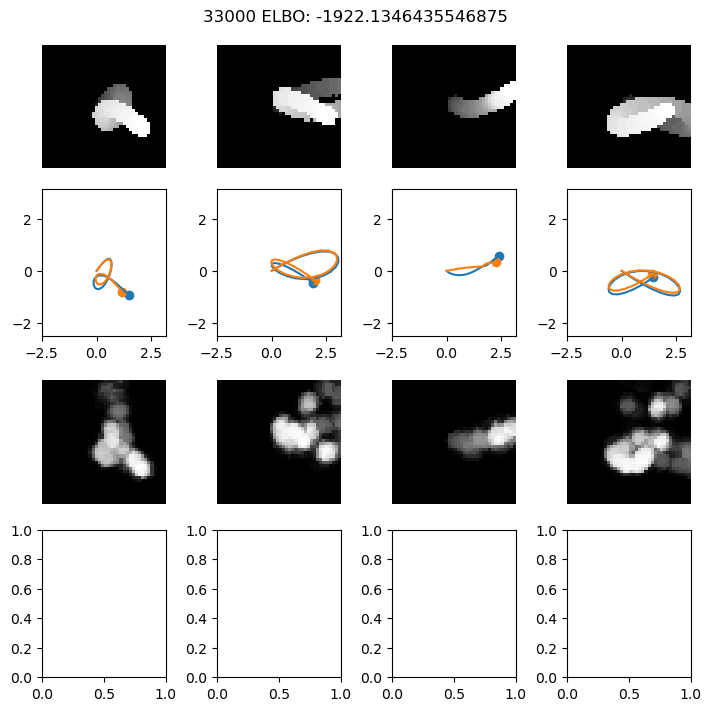

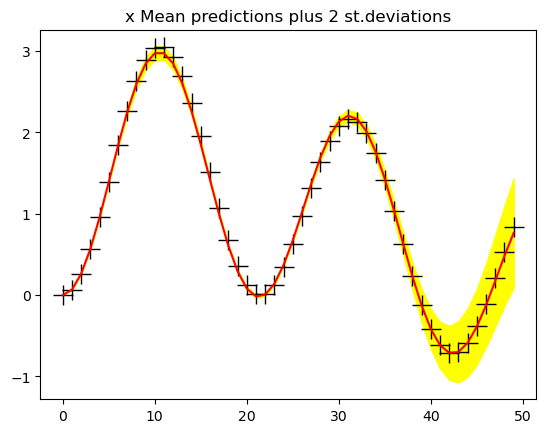

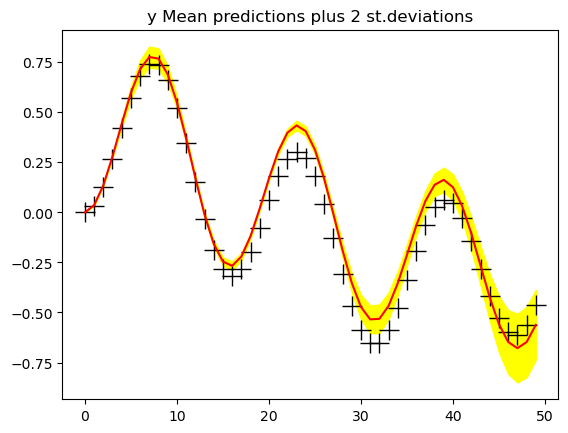


Test set: Avg. loss: 0.0001

Train Epoch: 33050 	Loss: 1923.898682	 875.309082	 1048.589611
Train Epoch: 33100 	Loss: 1928.609619	 870.772522	 1057.837009
Train Epoch: 33150 	Loss: 1923.448975	 871.897583	 1051.551437
Train Epoch: 33200 	Loss: 1905.951294	 849.037964	 1056.913376
Train Epoch: 33250 	Loss: 1923.585938	 881.710022	 1041.875839
Train Epoch: 33300 	Loss: 1922.513794	 871.634155	 1050.879669
Train Epoch: 33350 	Loss: 1911.731445	 876.777039	 1034.954453
Train Epoch: 33400 	Loss: 1907.543457	 858.786743	 1048.756695
Train Epoch: 33450 	Loss: 1931.536011	 886.752319	 1044.783688
Train Epoch: 33500 	Loss: 1911.654541	 862.898743	 1048.755836
Train Epoch: 33550 	Loss: 1921.984375	 865.296814	 1056.687641
Train Epoch: 33600 	Loss: 1928.088623	 883.691650	 1044.396973
Train Epoch: 33650 	Loss: 1927.528809	 877.006897	 1050.521946
Train Epoch: 33700 	Loss: 1909.615967	 862.096619	 1047.519302
Train Epoch: 33750 	Loss: 1919.622559	 874.319214	 1045.303345
Train Epoch: 33800 	Loss:

<Figure size 640x480 with 0 Axes>

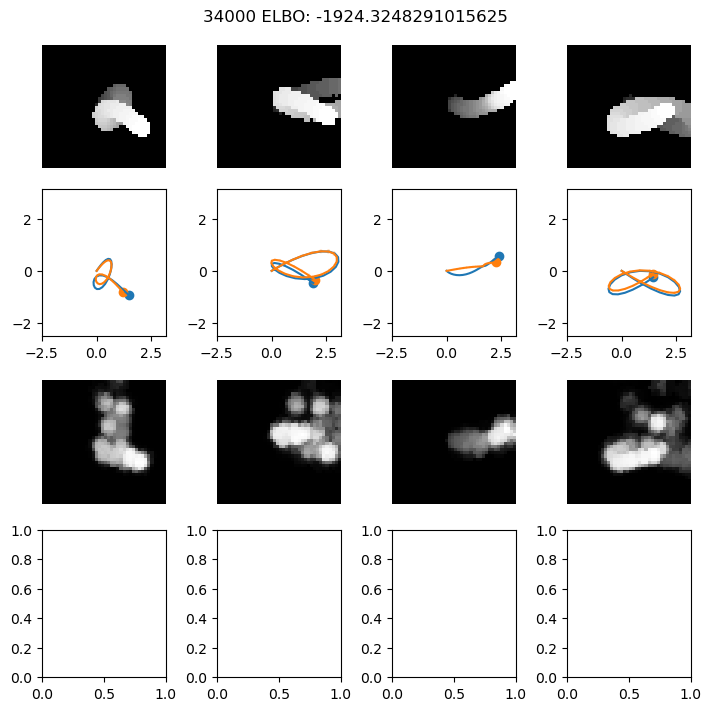

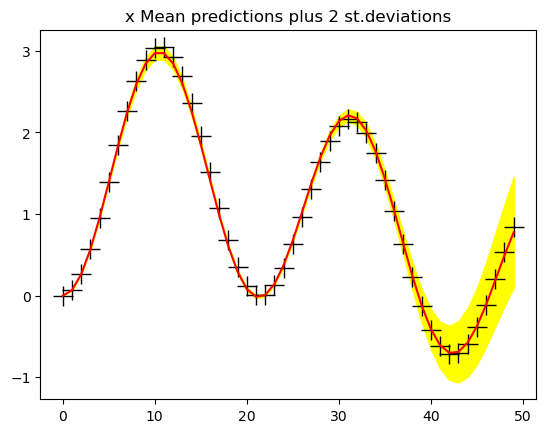

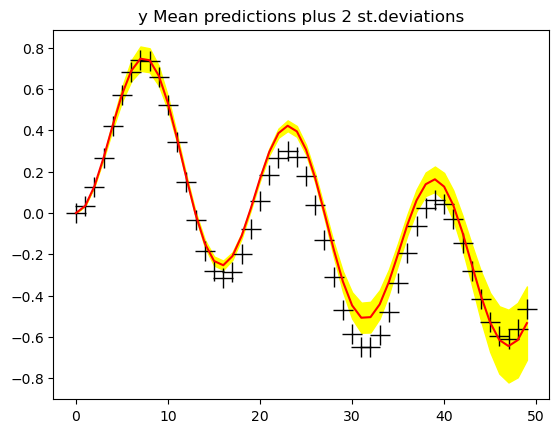


Test set: Avg. loss: 0.0001

Train Epoch: 34050 	Loss: 1916.775513	 872.317505	 1044.458008
Train Epoch: 34100 	Loss: 1915.308838	 868.153992	 1047.154808
Train Epoch: 34150 	Loss: 1926.064453	 875.578857	 1050.485611
Train Epoch: 34200 	Loss: 1932.763916	 871.718750	 1061.045170
Train Epoch: 34250 	Loss: 1904.359619	 846.882874	 1057.476711
Train Epoch: 34300 	Loss: 1925.483521	 874.927368	 1050.556183
Train Epoch: 34350 	Loss: 1925.223633	 871.816345	 1053.407192
Train Epoch: 34400 	Loss: 1921.155518	 874.187988	 1046.967506
Train Epoch: 34450 	Loss: 1920.436157	 873.453735	 1046.982384
Train Epoch: 34500 	Loss: 1907.702759	 848.396973	 1059.305763
Train Epoch: 34550 	Loss: 1922.620361	 866.578064	 1056.042385
Train Epoch: 34600 	Loss: 1897.360840	 845.686401	 1051.674461
Train Epoch: 34650 	Loss: 1925.473633	 863.305481	 1062.168217
Train Epoch: 34700 	Loss: 1929.052734	 887.905518	 1041.147232
Train Epoch: 34750 	Loss: 1905.758423	 856.654663	 1049.103737
Train Epoch: 34800 	Loss:

<Figure size 640x480 with 0 Axes>

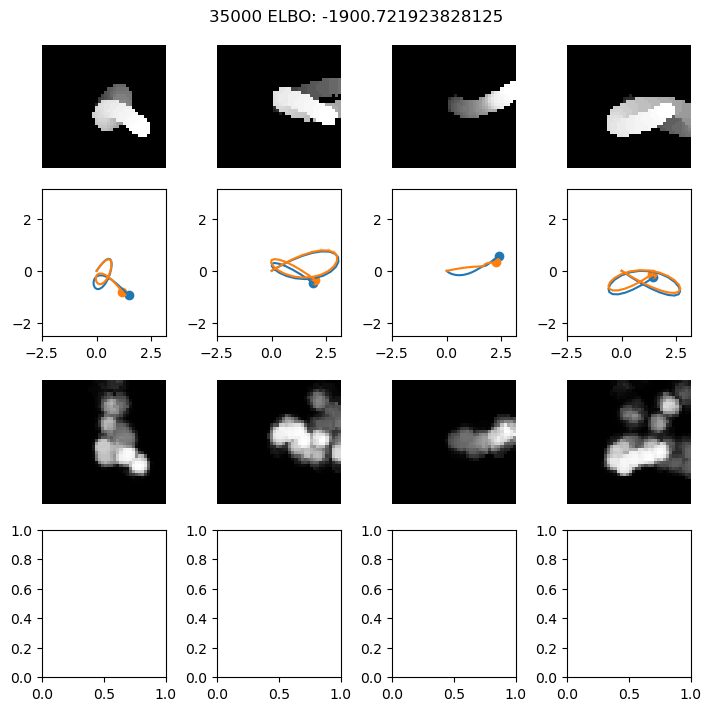

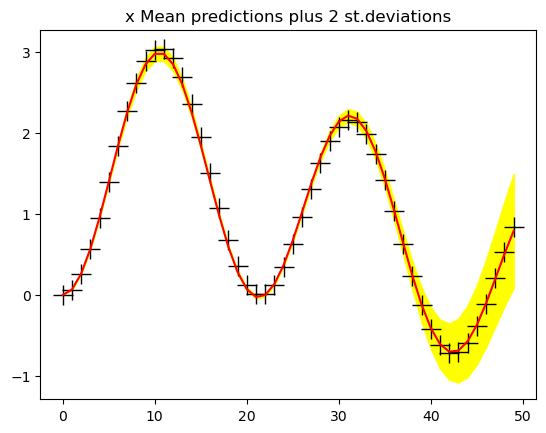

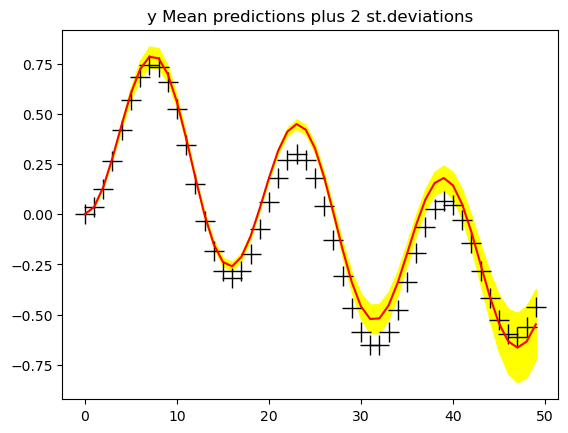


Test set: Avg. loss: 0.0001

Train Epoch: 35050 	Loss: 1922.544312	 881.095093	 1041.449261
Train Epoch: 35100 	Loss: 1914.429443	 876.676025	 1037.753391
Train Epoch: 35150 	Loss: 1913.008301	 872.884460	 1040.123940
Train Epoch: 35200 	Loss: 1924.884399	 871.621948	 1053.262424
Train Epoch: 35250 	Loss: 1909.185425	 868.368408	 1040.816975
Train Epoch: 35300 	Loss: 1911.927856	 842.952881	 1068.974972
Train Epoch: 35350 	Loss: 1916.630615	 864.573730	 1052.056885
Train Epoch: 35400 	Loss: 1913.397461	 856.885254	 1056.512165
Train Epoch: 35450 	Loss: 1913.416016	 855.431824	 1057.984257
Train Epoch: 35500 	Loss: 1921.453125	 872.949768	 1048.503399
Train Epoch: 35550 	Loss: 1920.418335	 868.372681	 1052.045631
Train Epoch: 35600 	Loss: 1921.679688	 870.400330	 1051.279449
Train Epoch: 35650 	Loss: 1919.479492	 857.819763	 1061.659813
Train Epoch: 35700 	Loss: 1913.903809	 858.680725	 1055.223179
Train Epoch: 35750 	Loss: 1924.211914	 875.451965	 1048.760033
Train Epoch: 35800 	Loss:

<Figure size 640x480 with 0 Axes>

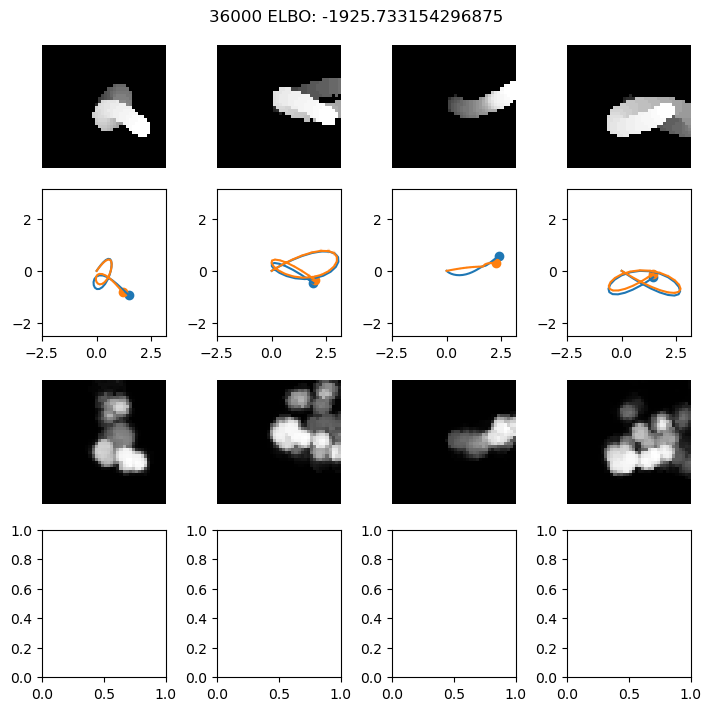

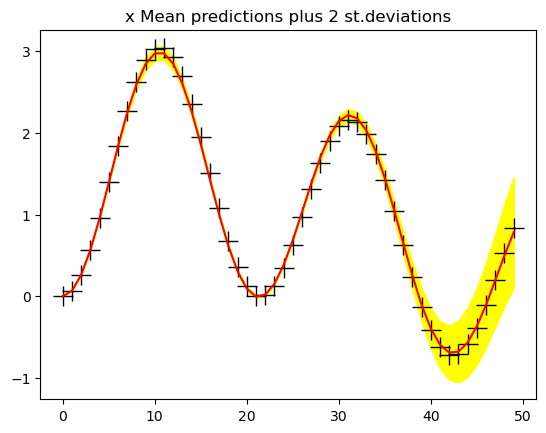

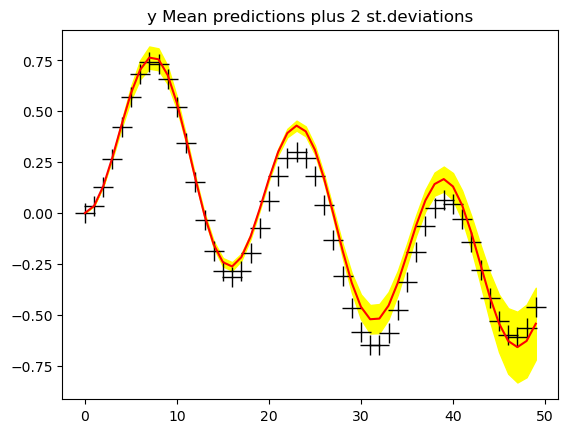


Test set: Avg. loss: 0.0001

Train Epoch: 36050 	Loss: 1909.996216	 869.300781	 1040.695477
Train Epoch: 36100 	Loss: 1905.456055	 857.275574	 1048.180389
Train Epoch: 36150 	Loss: 1922.470703	 870.460938	 1052.009773
Train Epoch: 36200 	Loss: 1920.556030	 867.343506	 1053.212547
Train Epoch: 36250 	Loss: 1907.255615	 846.431946	 1060.823727
Train Epoch: 36300 	Loss: 1938.840820	 885.800537	 1053.040314
Train Epoch: 36350 	Loss: 1931.335205	 882.029907	 1049.305344
Train Epoch: 36400 	Loss: 1917.909058	 860.985962	 1056.923103
Train Epoch: 36450 	Loss: 1910.994629	 861.665955	 1049.328709
Train Epoch: 36500 	Loss: 1932.720947	 886.823059	 1045.897865
Train Epoch: 36550 	Loss: 1918.048584	 859.989441	 1058.059216
Train Epoch: 36600 	Loss: 1919.089844	 862.162170	 1056.927586
Train Epoch: 36650 	Loss: 1917.146729	 871.166565	 1045.980072
Train Epoch: 36700 	Loss: 1920.980469	 868.630920	 1052.349567
Train Epoch: 36750 	Loss: 1919.093994	 863.870911	 1055.223179
Train Epoch: 36800 	Loss:

<Figure size 640x480 with 0 Axes>

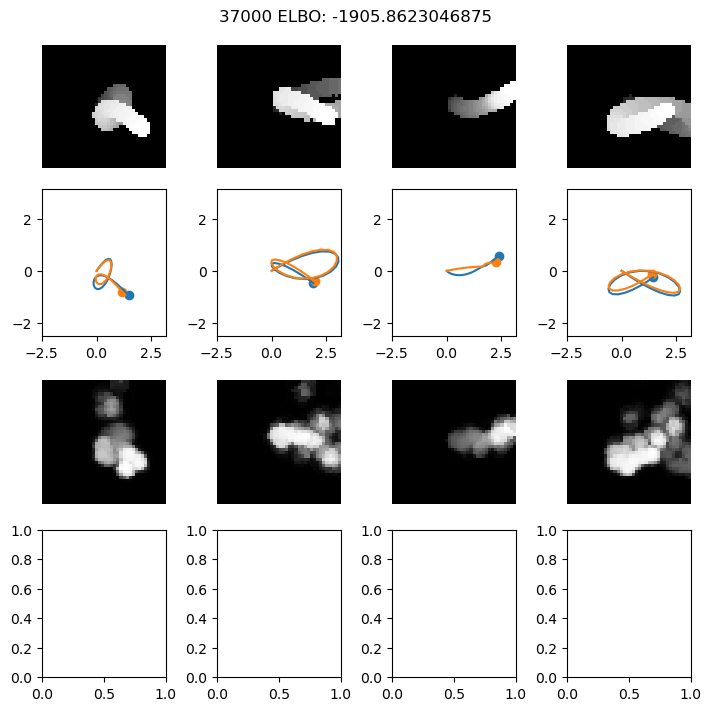

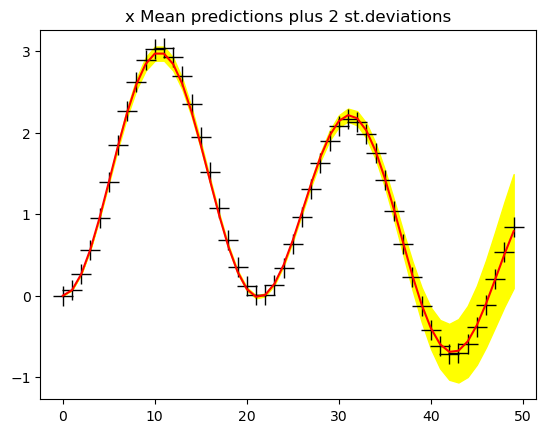

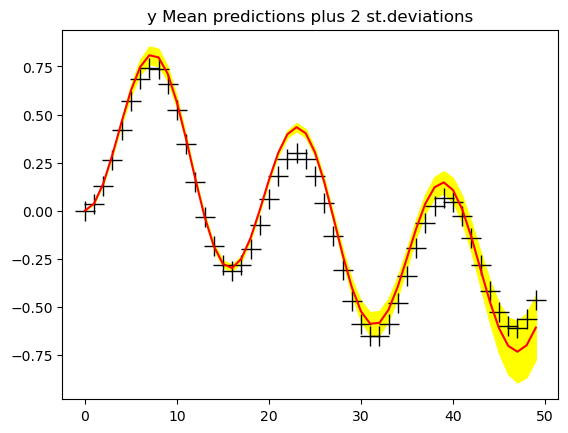


Test set: Avg. loss: 0.0001

Train Epoch: 37050 	Loss: 1903.996948	 848.531494	 1055.465412
Train Epoch: 37100 	Loss: 1928.490723	 879.796082	 1048.694611
Train Epoch: 37150 	Loss: 1914.245117	 858.440918	 1055.804157
Train Epoch: 37200 	Loss: 1918.170654	 855.347839	 1062.822723
Train Epoch: 37250 	Loss: 1910.596802	 857.634521	 1052.962303
Train Epoch: 37300 	Loss: 1919.332764	 863.478333	 1055.854511
Train Epoch: 37350 	Loss: 1929.479736	 876.308289	 1053.171349
Train Epoch: 37400 	Loss: 1909.270874	 849.850220	 1059.420681
Train Epoch: 37450 	Loss: 1910.175049	 852.974304	 1057.200718
Train Epoch: 37500 	Loss: 1908.878540	 852.874390	 1056.004143
Train Epoch: 37550 	Loss: 1917.760254	 868.111816	 1049.648476
Train Epoch: 37600 	Loss: 1920.904053	 860.027527	 1060.876465
Train Epoch: 37650 	Loss: 1932.851318	 882.917053	 1049.934292
Train Epoch: 37700 	Loss: 1920.792847	 872.316772	 1048.476028
Train Epoch: 37750 	Loss: 1919.843140	 871.260620	 1048.582554
Train Epoch: 37800 	Loss:

<Figure size 640x480 with 0 Axes>

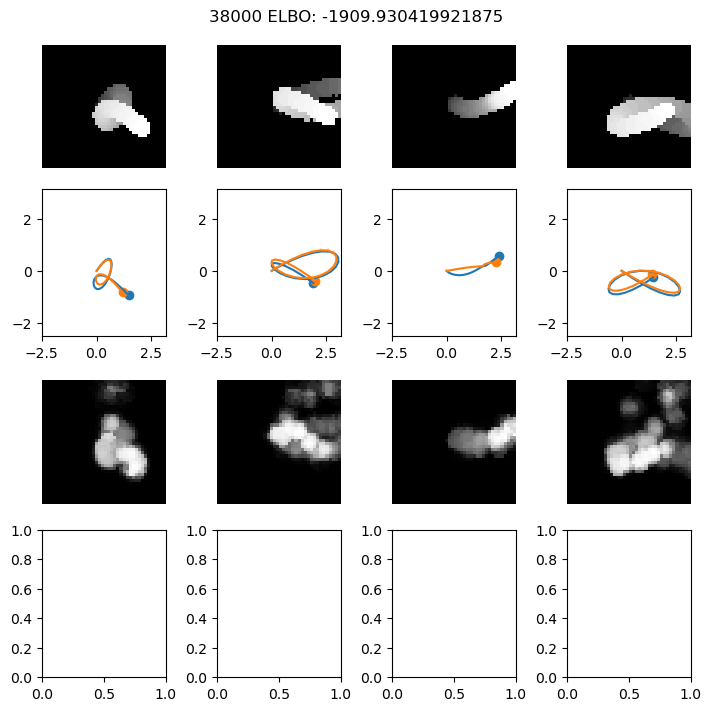

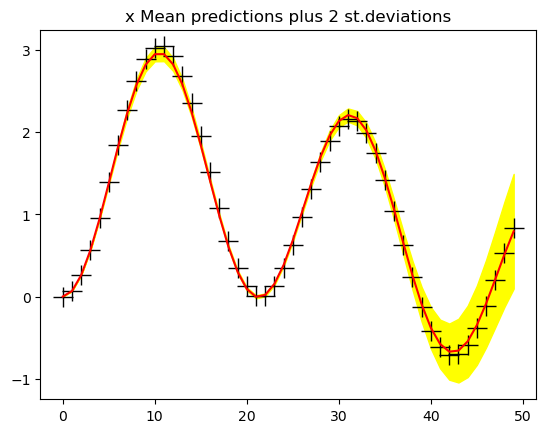

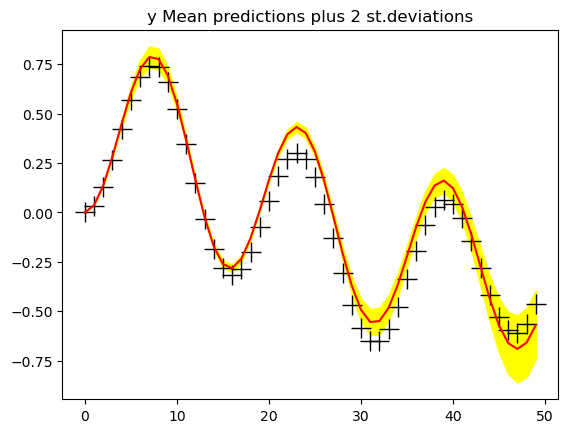


Test set: Avg. loss: 0.0001

Train Epoch: 38050 	Loss: 1923.788574	 868.607239	 1055.181408
Train Epoch: 38100 	Loss: 1917.285522	 864.429077	 1052.856445
Train Epoch: 38150 	Loss: 1925.589844	 872.235718	 1053.354168
Train Epoch: 38200 	Loss: 1923.714844	 868.619141	 1055.095673
Train Epoch: 38250 	Loss: 1915.204102	 856.361389	 1058.842754
Train Epoch: 38300 	Loss: 1908.303711	 850.817993	 1057.485676
Train Epoch: 38350 	Loss: 1916.194946	 853.411865	 1062.783051
Train Epoch: 38400 	Loss: 1908.987793	 859.555054	 1049.432755
Train Epoch: 38450 	Loss: 1925.898682	 869.455261	 1056.443501
Train Epoch: 38500 	Loss: 1922.036621	 872.649048	 1049.387550
Train Epoch: 38550 	Loss: 1924.730713	 867.162170	 1057.568455
Train Epoch: 38600 	Loss: 1907.218262	 847.591492	 1059.626675
Train Epoch: 38650 	Loss: 1924.333496	 870.566345	 1053.767204
Train Epoch: 38700 	Loss: 1912.020752	 852.773071	 1059.247684
Train Epoch: 38750 	Loss: 1906.043457	 845.991394	 1060.052109
Train Epoch: 38800 	Loss:

<Figure size 640x480 with 0 Axes>

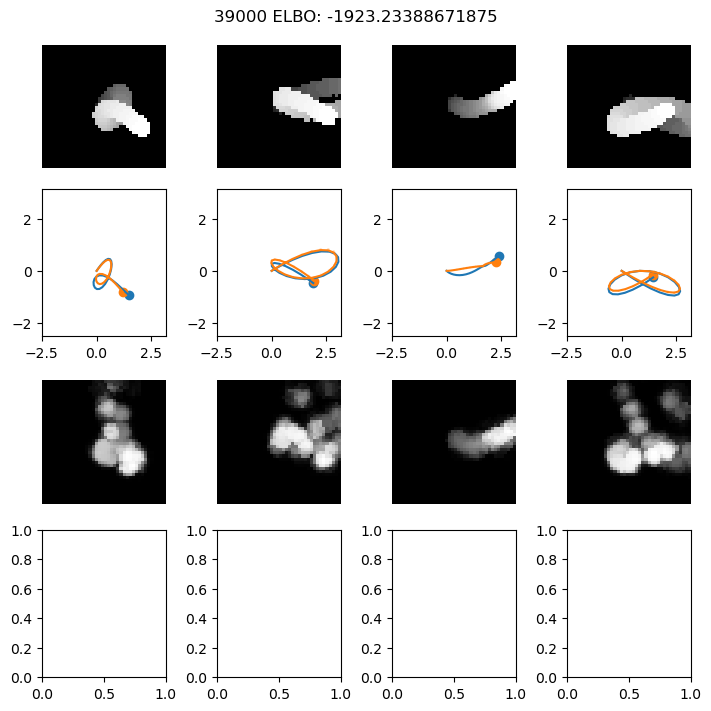

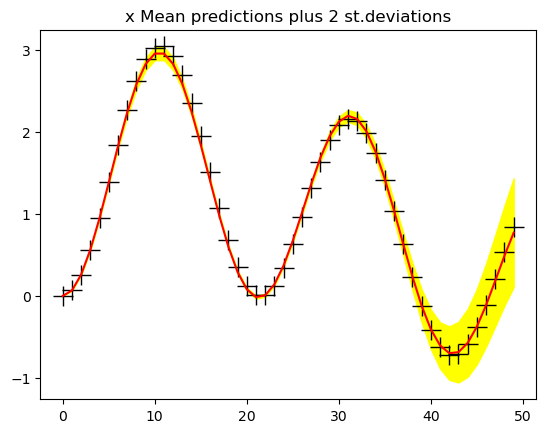

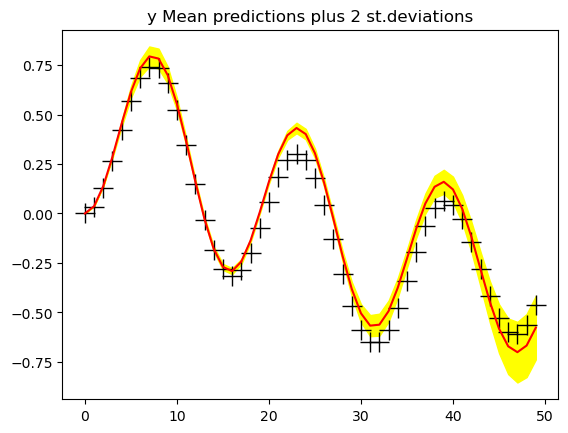


Test set: Avg. loss: 0.0001

Train Epoch: 39050 	Loss: 1910.350830	 852.759583	 1057.591152
Train Epoch: 39100 	Loss: 1904.536621	 844.288208	 1060.248375
Train Epoch: 39150 	Loss: 1920.047119	 865.241028	 1054.806042
Train Epoch: 39200 	Loss: 1926.337158	 872.979614	 1053.357506
Train Epoch: 39250 	Loss: 1917.550781	 866.321960	 1051.228905
Train Epoch: 39300 	Loss: 1914.963379	 858.851746	 1056.111717
Train Epoch: 39350 	Loss: 1921.764648	 864.091980	 1057.672596
Train Epoch: 39400 	Loss: 1920.294678	 864.377197	 1055.917454
Train Epoch: 39450 	Loss: 1920.646484	 859.573425	 1061.073112
Train Epoch: 39500 	Loss: 1913.378174	 861.619690	 1051.758575
Train Epoch: 39550 	Loss: 1924.693848	 865.518127	 1059.175777
Train Epoch: 39600 	Loss: 1912.794434	 856.276855	 1056.517601
Train Epoch: 39650 	Loss: 1916.147949	 862.984741	 1053.163242
Train Epoch: 39700 	Loss: 1907.199829	 847.804688	 1059.395123
Train Epoch: 39750 	Loss: 1915.783203	 855.142090	 1060.641098
Train Epoch: 39800 	Loss:

<Figure size 640x480 with 0 Axes>

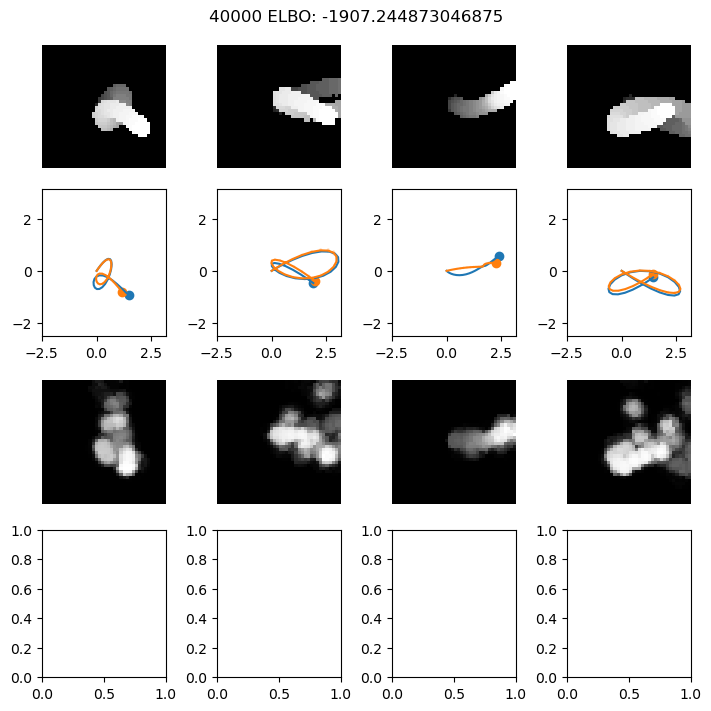

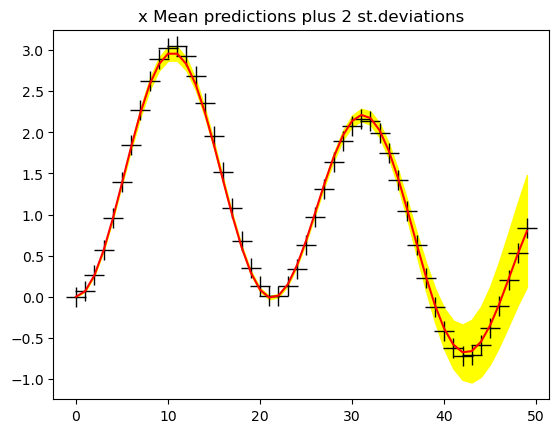

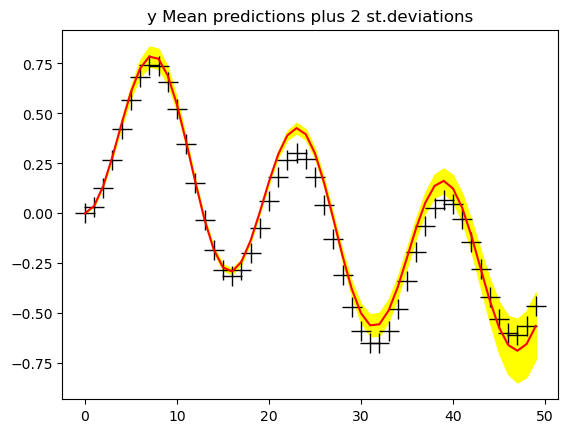


Test set: Avg. loss: 0.0001

Train Epoch: 40050 	Loss: 1925.059204	 871.560913	 1053.498268
Train Epoch: 40100 	Loss: 1905.828125	 852.853333	 1052.974701
Train Epoch: 40150 	Loss: 1925.497070	 872.456238	 1053.040791
Train Epoch: 40200 	Loss: 1910.674805	 853.290222	 1057.384682
Train Epoch: 40250 	Loss: 1918.657227	 864.315796	 1054.341412
Train Epoch: 40300 	Loss: 1927.138916	 878.402649	 1048.736191
Train Epoch: 40350 	Loss: 1920.787964	 874.994873	 1045.793056
Train Epoch: 40400 	Loss: 1920.988403	 859.790649	 1061.197758
Train Epoch: 40450 	Loss: 1917.084717	 853.421875	 1063.662815
Train Epoch: 40500 	Loss: 1907.974121	 858.599854	 1049.374294
Train Epoch: 40550 	Loss: 1925.677734	 873.464233	 1052.213478
Train Epoch: 40600 	Loss: 1908.581787	 852.954529	 1055.627346
Train Epoch: 40650 	Loss: 1911.833862	 844.303955	 1067.529869
Train Epoch: 40700 	Loss: 1913.110229	 853.005249	 1060.104942
Train Epoch: 40750 	Loss: 1901.005615	 837.792236	 1063.213348
Train Epoch: 40800 	Loss:

<Figure size 640x480 with 0 Axes>

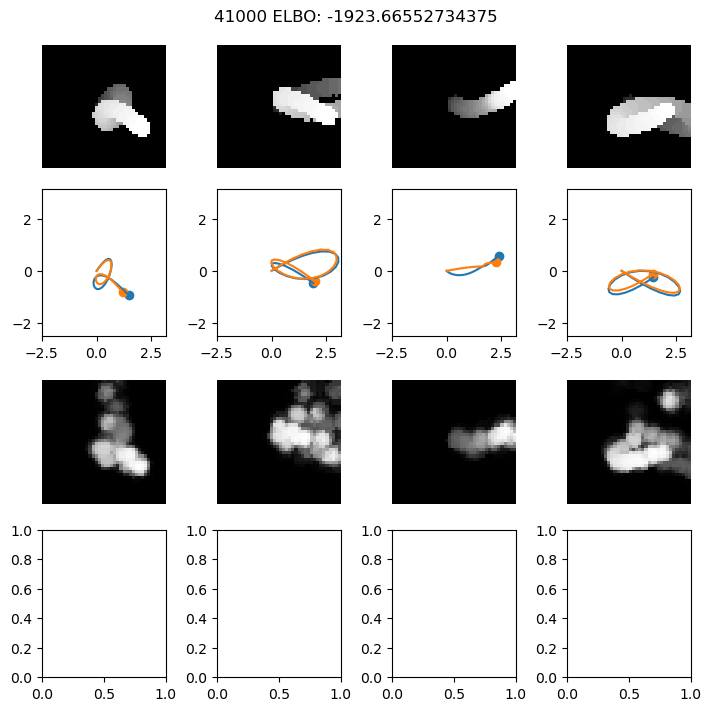

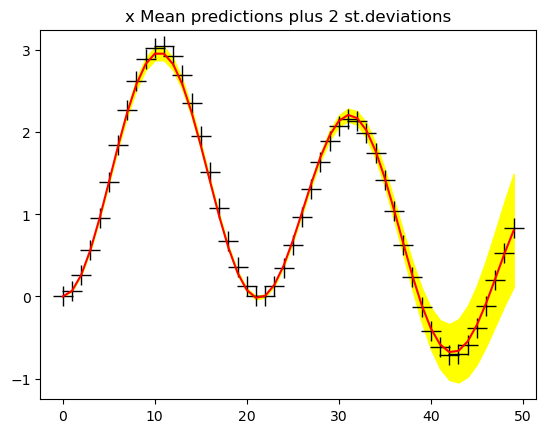

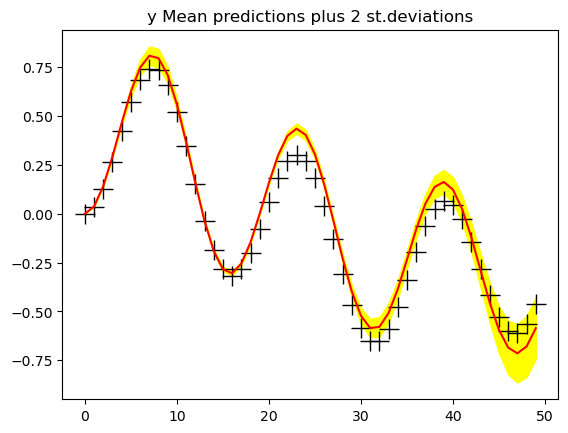


Test set: Avg. loss: 0.0001

Train Epoch: 41050 	Loss: 1917.719971	 869.735840	 1047.984123
Train Epoch: 41100 	Loss: 1905.564819	 848.747192	 1056.817627
Train Epoch: 41150 	Loss: 1913.514404	 857.454773	 1056.059647
Train Epoch: 41200 	Loss: 1908.828979	 852.771118	 1056.057835
Train Epoch: 41250 	Loss: 1913.593140	 859.794922	 1053.798199
Train Epoch: 41300 	Loss: 1902.662842	 849.225159	 1053.437710
Train Epoch: 41350 	Loss: 1912.850708	 857.460571	 1055.390167
Train Epoch: 41400 	Loss: 1894.036621	 839.481628	 1054.555035
Train Epoch: 41450 	Loss: 1912.248291	 845.590149	 1066.658211
Train Epoch: 41500 	Loss: 1921.318481	 867.862183	 1053.456306
Train Epoch: 41550 	Loss: 1909.584961	 849.900757	 1059.684181
Train Epoch: 41600 	Loss: 1912.077637	 850.580261	 1061.497307
Train Epoch: 41650 	Loss: 1918.136719	 848.554443	 1069.582272
Train Epoch: 41700 	Loss: 1919.134033	 845.432495	 1073.701572
Train Epoch: 41750 	Loss: 1924.093018	 869.090149	 1055.002785
Train Epoch: 41800 	Loss:

<Figure size 640x480 with 0 Axes>

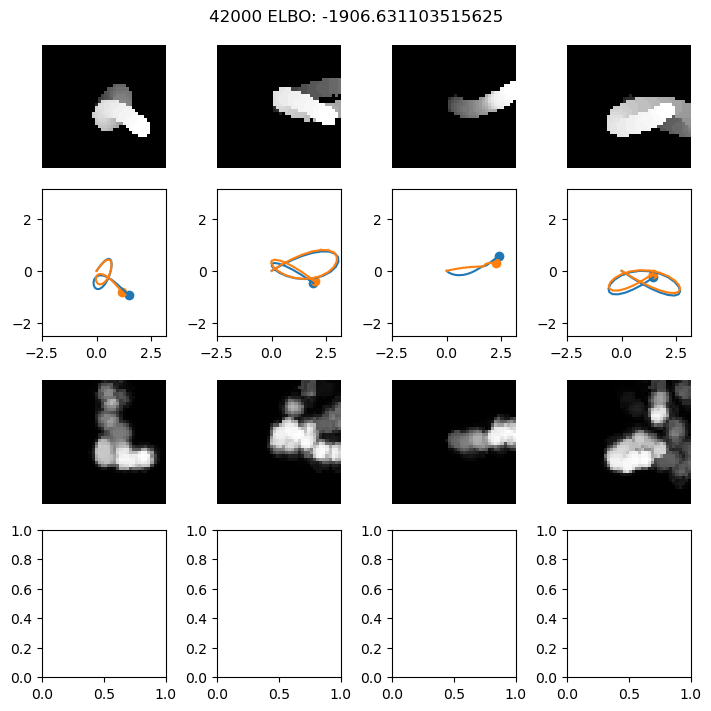

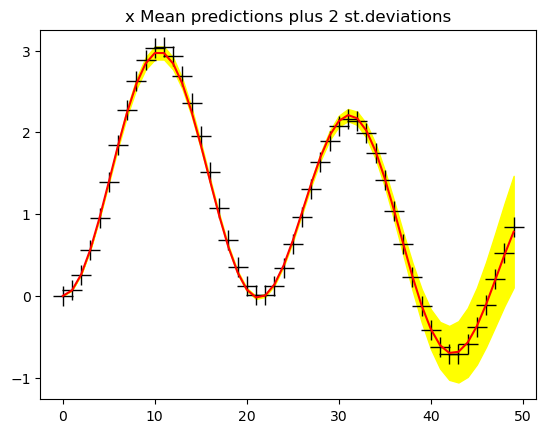

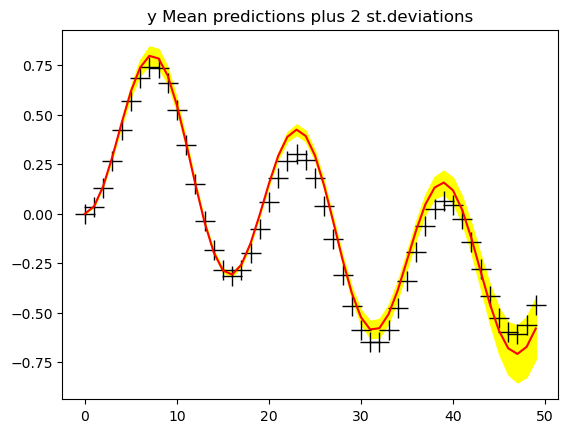


Test set: Avg. loss: 0.0001

Train Epoch: 42050 	Loss: 1910.856689	 856.351562	 1054.505157
Train Epoch: 42100 	Loss: 1920.056885	 858.375061	 1061.681747
Train Epoch: 42150 	Loss: 1914.148438	 861.852478	 1052.295876
Train Epoch: 42200 	Loss: 1913.807739	 854.434692	 1059.373093
Train Epoch: 42250 	Loss: 1914.871948	 866.464478	 1048.407459
Train Epoch: 42300 	Loss: 1902.161255	 841.061646	 1061.099625
Train Epoch: 42350 	Loss: 1905.535889	 851.756592	 1053.779316
Train Epoch: 42400 	Loss: 1913.844604	 851.983765	 1061.860847
Train Epoch: 42450 	Loss: 1915.754028	 868.487427	 1047.266579
Train Epoch: 42500 	Loss: 1924.756226	 871.844116	 1052.912140
Train Epoch: 42550 	Loss: 1917.130493	 855.049438	 1062.081051
Train Epoch: 42600 	Loss: 1913.907715	 842.086731	 1071.820927
Train Epoch: 42650 	Loss: 1920.077881	 864.455017	 1055.622959
Train Epoch: 42700 	Loss: 1924.498901	 870.967529	 1053.531361
Train Epoch: 42750 	Loss: 1917.812988	 863.484985	 1054.327965
Train Epoch: 42800 	Loss:

<Figure size 640x480 with 0 Axes>

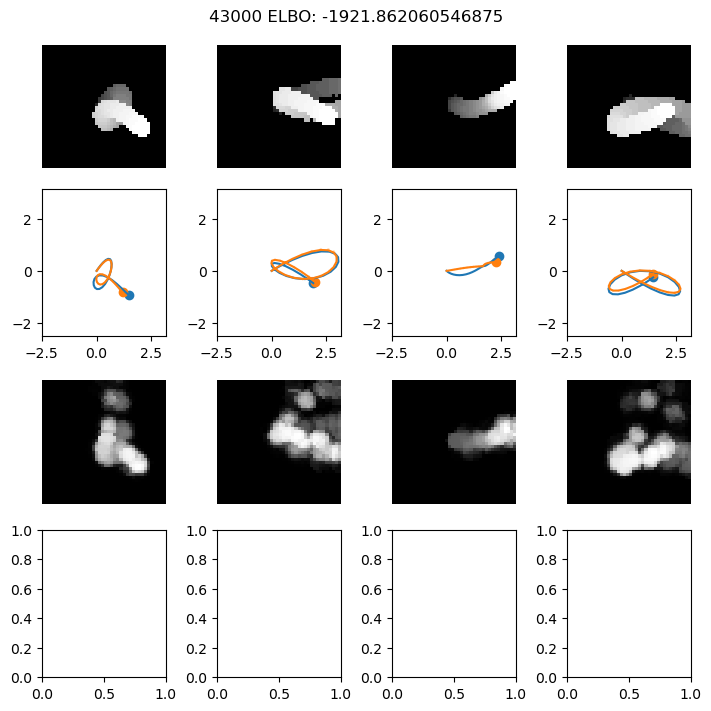

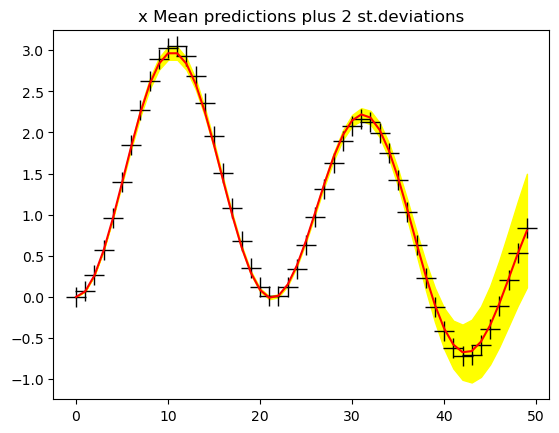

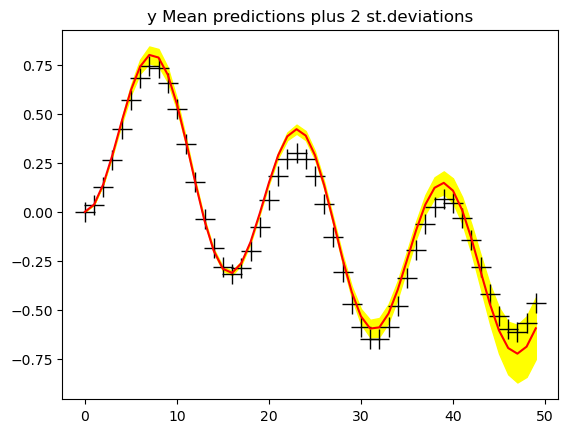


Test set: Avg. loss: 0.0001

Train Epoch: 43050 	Loss: 1903.572754	 848.880676	 1054.692173
Train Epoch: 43100 	Loss: 1927.548950	 872.944824	 1054.604149
Train Epoch: 43150 	Loss: 1913.070068	 855.775085	 1057.294941
Train Epoch: 43200 	Loss: 1914.853149	 856.384399	 1058.468723
Train Epoch: 43250 	Loss: 1907.447510	 847.632202	 1059.815311
Train Epoch: 43300 	Loss: 1907.440796	 864.772583	 1042.668247
Train Epoch: 43350 	Loss: 1924.068359	 870.528992	 1053.539467
Train Epoch: 43400 	Loss: 1901.069336	 837.909363	 1063.160038
Train Epoch: 43450 	Loss: 1922.343262	 868.164246	 1054.179096
Train Epoch: 43500 	Loss: 1903.930664	 847.156738	 1056.773949
Train Epoch: 43550 	Loss: 1908.521240	 854.319153	 1054.202175
Train Epoch: 43600 	Loss: 1916.005859	 856.863464	 1059.142303
Train Epoch: 43650 	Loss: 1921.185059	 865.881165	 1055.303955
Train Epoch: 43700 	Loss: 1914.686401	 857.805054	 1056.881332
Train Epoch: 43750 	Loss: 1924.968750	 850.894836	 1074.073982
Train Epoch: 43800 	Loss:

<Figure size 640x480 with 0 Axes>

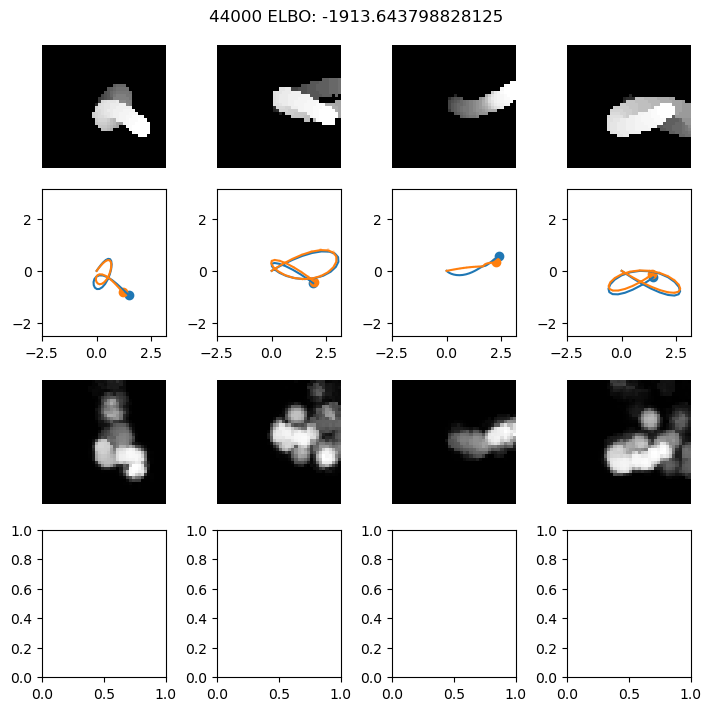

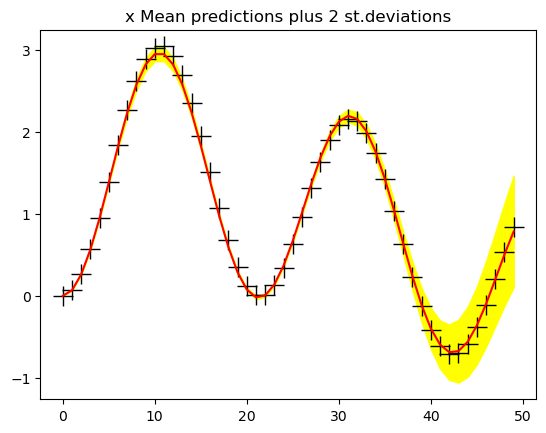

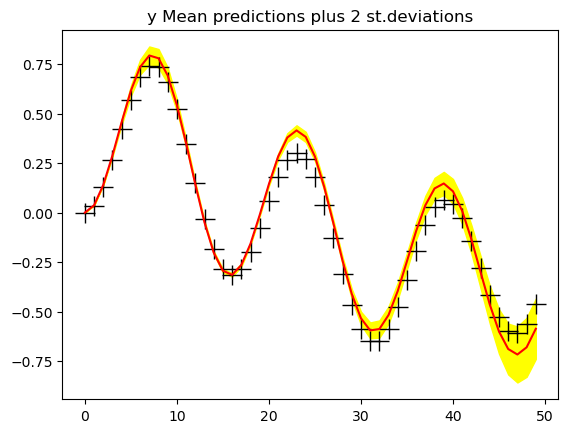


Test set: Avg. loss: 0.0001

Train Epoch: 44050 	Loss: 1917.469604	 837.606079	 1079.863548
Train Epoch: 44100 	Loss: 1911.458008	 853.740173	 1057.717896
Train Epoch: 44150 	Loss: 1931.138672	 876.074158	 1055.064487
Train Epoch: 44200 	Loss: 1917.204712	 860.026611	 1057.178116
Train Epoch: 44250 	Loss: 1921.975342	 863.676086	 1058.299160
Train Epoch: 44300 	Loss: 1911.926636	 843.599854	 1068.326759
Train Epoch: 44350 	Loss: 1911.926270	 855.696716	 1056.229591
Train Epoch: 44400 	Loss: 1901.462402	 848.695618	 1052.766800
Train Epoch: 44450 	Loss: 1901.222412	 846.426270	 1054.796124
Train Epoch: 44500 	Loss: 1912.718262	 861.244690	 1051.473522
Train Epoch: 44550 	Loss: 1902.749756	 845.925720	 1056.824112
Train Epoch: 44600 	Loss: 1912.138794	 859.230103	 1052.908707
Train Epoch: 44650 	Loss: 1901.895142	 842.466431	 1059.428692
Train Epoch: 44700 	Loss: 1912.042236	 850.565918	 1061.476326
Train Epoch: 44750 	Loss: 1919.869995	 857.774658	 1062.095356
Train Epoch: 44800 	Loss:

<Figure size 640x480 with 0 Axes>

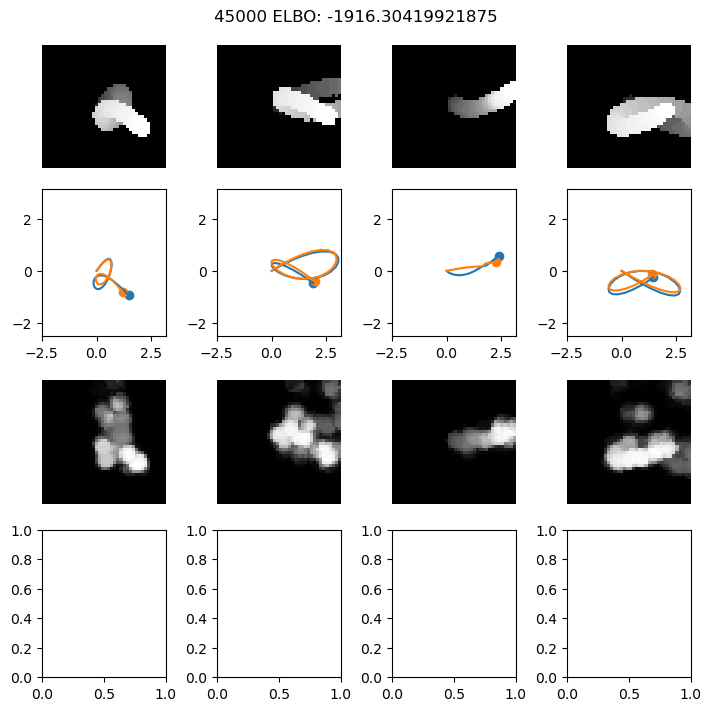

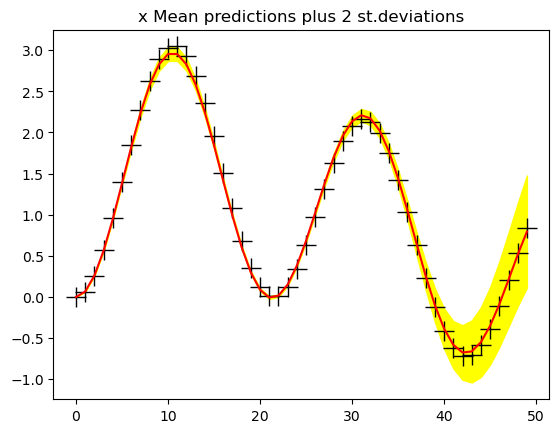

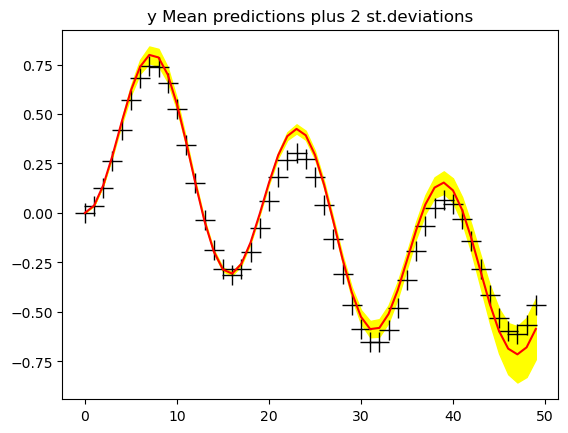


Test set: Avg. loss: 0.0001

Train Epoch: 45050 	Loss: 1908.899902	 856.282471	 1052.617455
Train Epoch: 45100 	Loss: 1911.946167	 843.880371	 1068.065834
Train Epoch: 45150 	Loss: 1911.114990	 857.432373	 1053.682613
Train Epoch: 45200 	Loss: 1910.315186	 855.659973	 1054.655266
Train Epoch: 45250 	Loss: 1914.596191	 840.799866	 1073.796368
Train Epoch: 45300 	Loss: 1908.266479	 842.320557	 1065.945911
Train Epoch: 45350 	Loss: 1911.903320	 853.612976	 1058.290291
Train Epoch: 45400 	Loss: 1903.568848	 834.035950	 1069.532871


KeyboardInterrupt: 

In [9]:

    args_steps=50000 #Number of steps of Adam
    args_modellt=50. #time scale of model to fit to data
    args_base_dir="./" #folder within a new dir is made for each run
    args_l1=0.3
    args_l2=0.4
    args_d1=0.02
    args_d2=0.01

    run_experiment(args_steps,args_modellt,args_base_dir,args_l1,args_l2,args_d1,args_d2)